In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
from PIL import Image

In [2]:
def get_input_pattern(gate_type):
    gate_types = ["LOW", "AND", "AND2_PN", "BUF1", 
              "AND2_NP", "BUF2", "XOR", "OR",
              "NOR", "XNOR", "NOT2", "NAND2_NP",
              "NOT1", "NAND2_PN", "NAND", "HIGH"]
    index = gate_types.index(gate_type)
    res = ""
    for i in range(4):
        res = str(index%2) + res
        index >>= 1
    return np.array(list(res))

In [3]:
def plotting(function_type, weights):
    amin = -1.5
    amax = 1.5
    resolution = 0.01
    
    cmap = ListedColormap(('blue', 'red'))
    a, b = np.meshgrid(np.arange(amin, amax, resolution), np.arange(amin, amax, resolution))
    if weights.shape[-1] == 4:
        input_k = np.stack([a, b, a*b, np.ones(a.shape)], axis = len(a.shape)) # w1x1+w2x2+w3x1x2+w4
    if weights.shape[-1] == 3:
        input_k = np.stack([a, b, a*b], axis = len(a.shape)) # w1x1+w2x2+w3x1x2
    z = np.sign(np.dot(input_k, weights))

    fig, ax = plt.subplots(figsize=(4,3))
    plt.xlim(amin, amax)
    plt.ylim(amin, amax)
    plt.xlabel('a')
    plt.ylabel('b')
    #plt.legend(loc = 'upper left')
    plt.tight_layout()
    ax.contourf(a, b, z, alpha = 0.3, cmap = cmap)
    
    bits = get_input_pattern(function_type)
    colors = np.where(bits=="0", "blue", "red")
    markers = np.where(bits=="0", "x", "s")
    inputs = [(-1,-1), (-1,1), (1,-1), (1,1)]
    for (x,y), c, m in zip(inputs, colors, markers):
        ax.scatter(x=x, y=y, alpha=0.8, c=c, marker=m)
    
    fig.savefig("temp.png")
    im = Image.open("temp.png").copy()
    os.system("rm temp.png")
    return im

In [4]:
class Model:
    def __init__(self, has_bias=True, learning_rate=0.05):
        self.get_model(has_bias, learning_rate)
        
    def get_model(self, has_bias, learning_rate):
        def train_activation(activation):
            t = tf.clip_by_value(activation, -1.5, 1.5)
            return t + tf.stop_gradient(tf.sign(activation) - t)
        
        with tf.name_scope('inouts'):
            self.inputs = tf.placeholder(tf.float32, shape = (None, 2), name = 'ins')
            self.outputs = tf.placeholder(tf.float32, shape = (None, 1), name = 'outs')
        with tf.variable_scope('para', reuse=tf.AUTO_REUSE):
            w = tf.get_variable("weight", [3, 1], initializer=tf.random_uniform_initializer(-0.1,0.1))
            if has_bias:
                b = tf.get_variable("bias", [1], initializer=tf.zeros_initializer())
        affined_in = tf.stack([self.inputs[:,0], self.inputs[:,1], self.inputs[:,0] * self.inputs[:,1]], axis = 1)
        w = tf.clip_by_value(w, -1, 1)
        z = tf.matmul(affined_in, w)
        if has_bias:
            z = tf.nn.bias_add(z, b)
        self.result = train_activation(z)
        
        self.loss = tf.reduce_mean(tf.square(self.result - self.outputs))
        opt = tf.train.GradientDescentOptimizer(learning_rate)
        self.opt = opt.minimize(self.loss)
    
    def training_in_order(self,x,y,val_y,max_epoch=100): # batchsize = x.shape[0]
        table = []
        success_flag = False
        val_x = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            allvars = tf.global_variables()
            b = None
            for var in allvars:
                if "Momentum" not in var.name:
                    if "weight" in var.name:
                        w = var
                    if "bias" in var.name:
                        b = var
#             while True:
#                 w_s = w.eval()
#                 if abs(w_s[0][0]) < abs(w_s[1][0] + w_s[2][0]) and abs(w_s[1][0]) < abs(w_s[0][0] + w_s[2][0]):
#                     break
#                 sess.run(tf.variables_initializer([w]))   
            
            
            if b:
                para = np.concatenate([w.eval()[:,0], b.eval()])
            else:
                para = w.eval()[:,0]
            table.append((0,0,para))
            
            for i in range(max_epoch):
                _, loss_value = sess.run((self.opt, self.loss), 
                                             feed_dict = {self.inputs: x, self.outputs: y})  
                if b:
                    para = np.concatenate([w.eval()[:,0], b.eval()])
                else:
                    para = w.eval()[:,0]
                loss = sess.run((self.loss), feed_dict={self.inputs:val_x, self.outputs:val_y})
                table.append((loss, loss_value, para))
                if loss == 0:
                    print("Satisfied! Succeed to get true functionality.")
                    success_flag=True
                    break
                if loss_value == 0 and loss != 0:
                    print("Unsatisfied! Failed to get true functionality from this set of input!")
                    break
        print("finish!")
        return success_flag, table

In [5]:
Gate = "OR" # "OR" confused with "XOR"
m = Model(False, 0.002)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
val_x = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
val_y = np.expand_dims(np.where(get_input_pattern(Gate)=="0", -1, 1), axis = 1)
print(val_y[:,0])

[-1  1  1  1]


In [7]:
index = np.random.choice(4,2, replace=True)
index = [0,1,2]
train_x, train_y = val_x[index], val_y[index]

In [11]:
_, table = m.training_in_order(train_x, train_y, val_y,50)

Unsatisfied! Failed to get true functionality from this set of input!
finish!


Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Satisfied! Succeed to get true functionality.
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Satisfied! Succeed to get true functionality.
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Satisfied! Succeed to get true functionality.
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Satisfied! Succeed to get true functionality.
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Unsatisfied! Failed to get true functionality from this set of input!
finish!
Satisfied! Succeed to get true functionality.
finish!
Sati

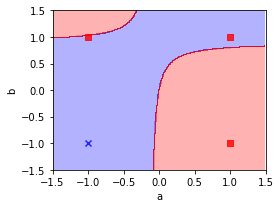

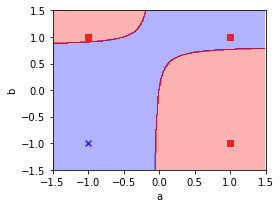

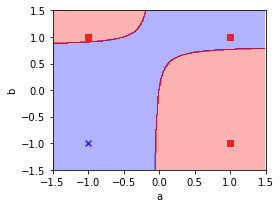

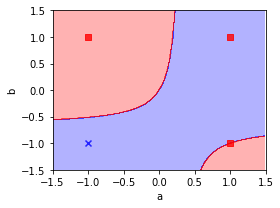

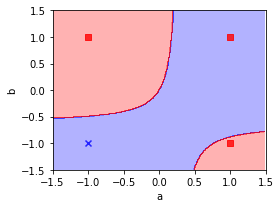

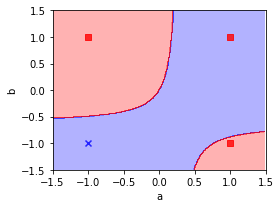

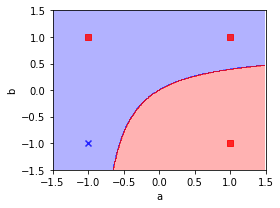

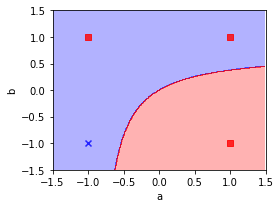

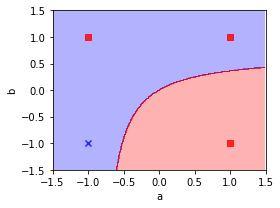

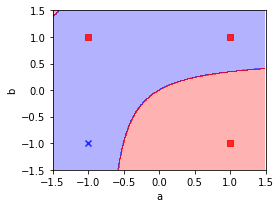

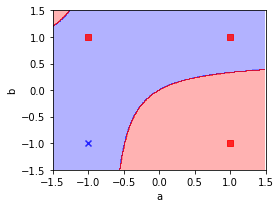

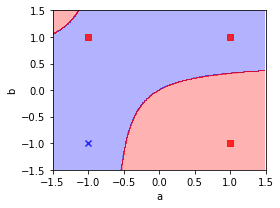

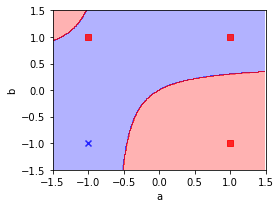

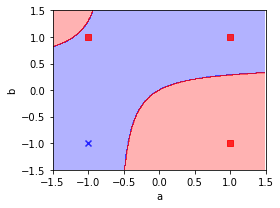

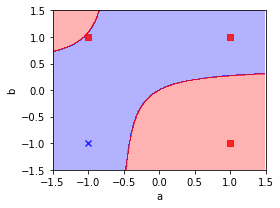

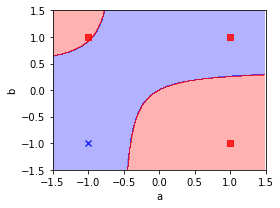

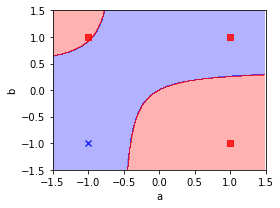

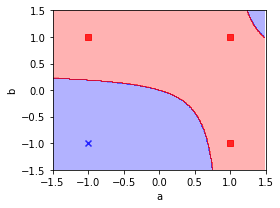

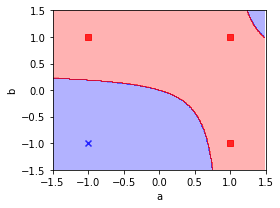

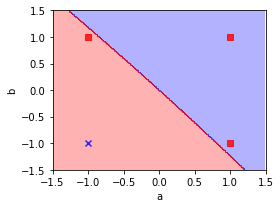

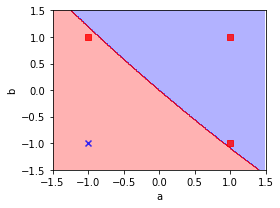

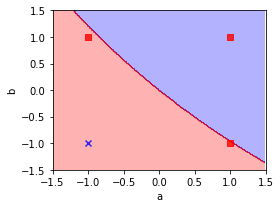

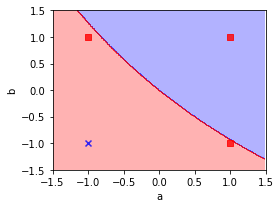

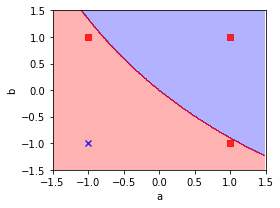

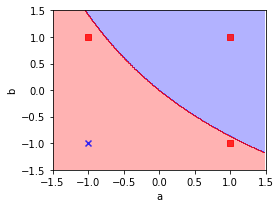

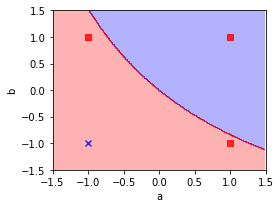

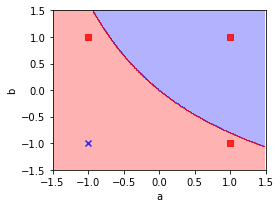

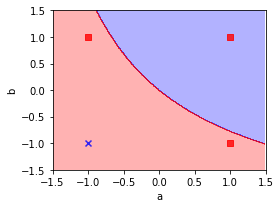

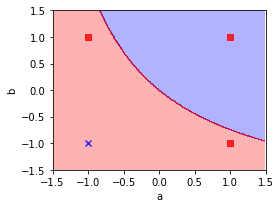

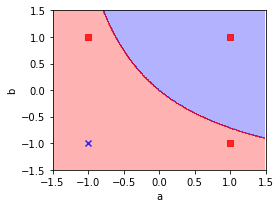

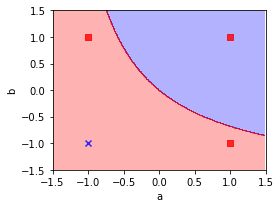

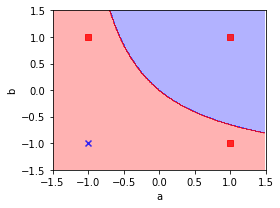

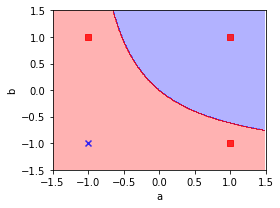

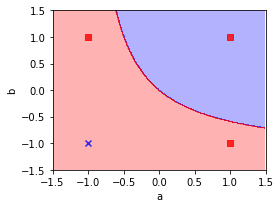

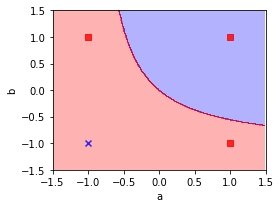

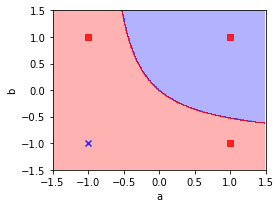

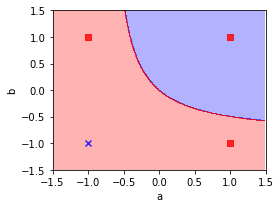

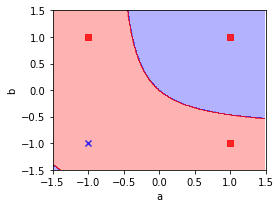

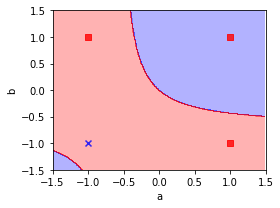

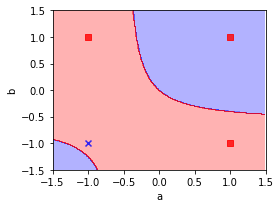

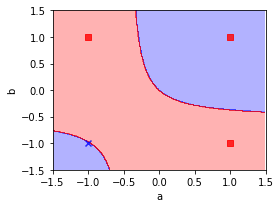

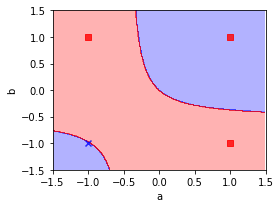

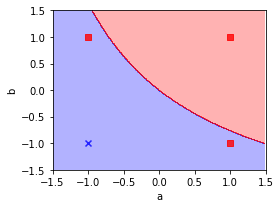

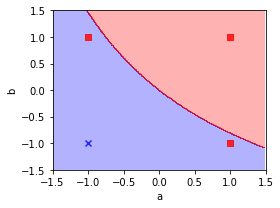

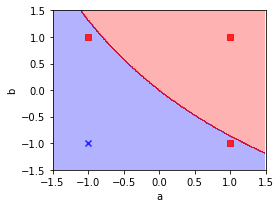

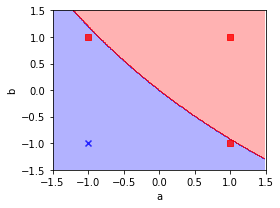

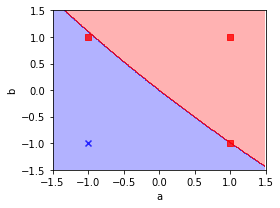

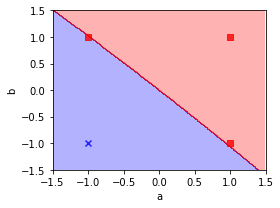

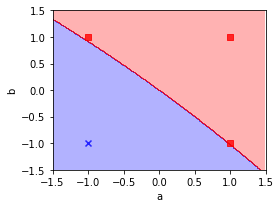

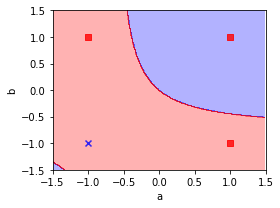

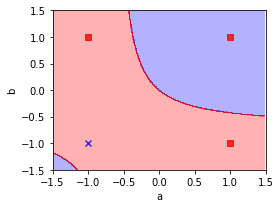

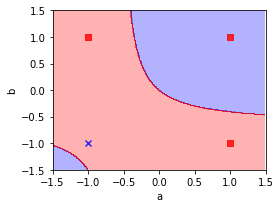

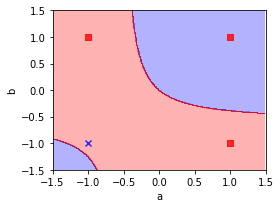

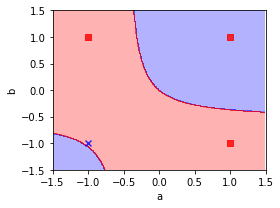

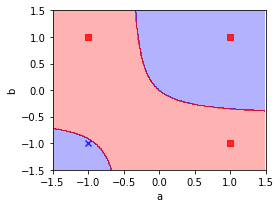

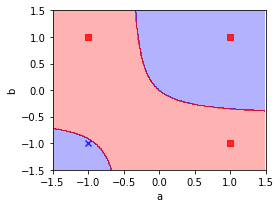

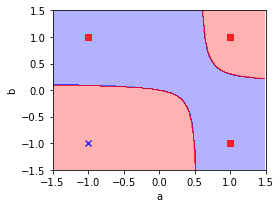

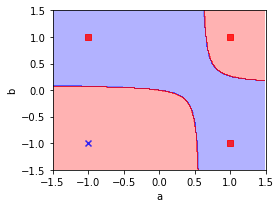

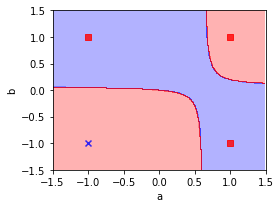

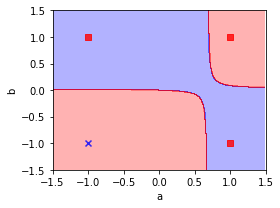

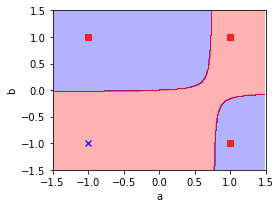

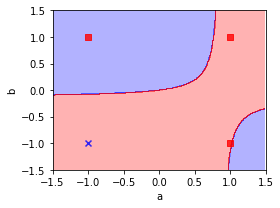

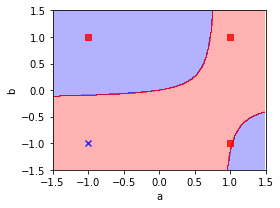

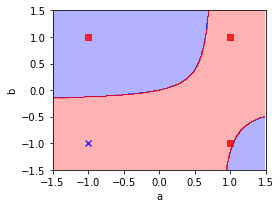

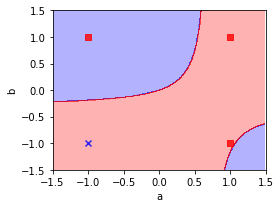

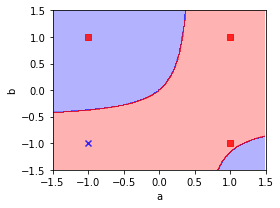

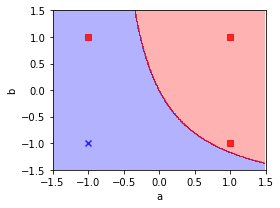

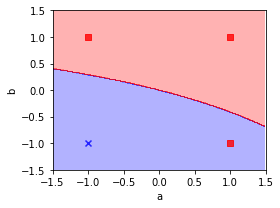

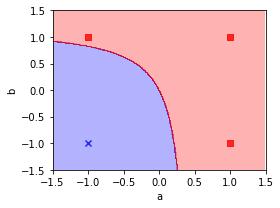

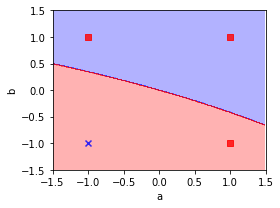

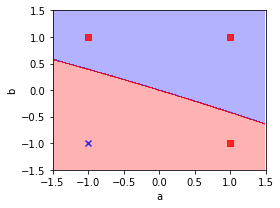

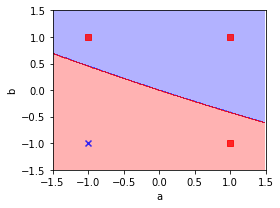

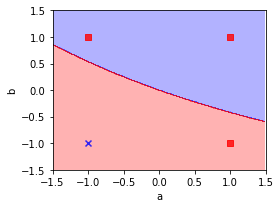

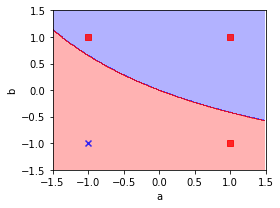

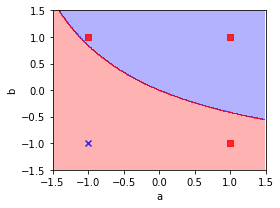

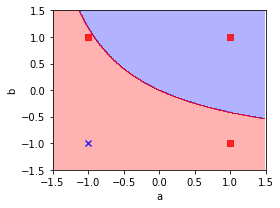

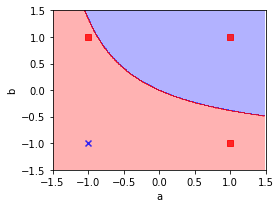

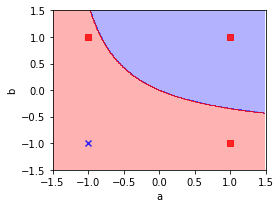

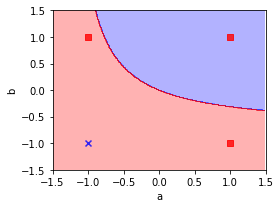

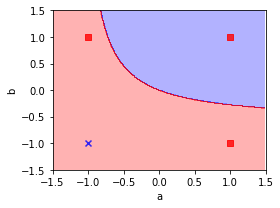

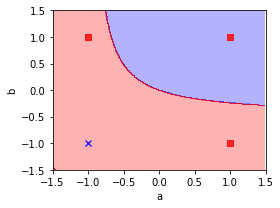

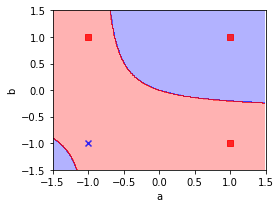

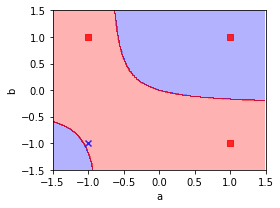

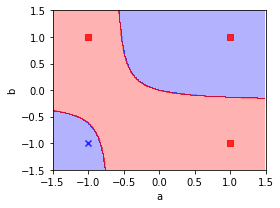

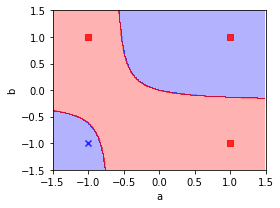

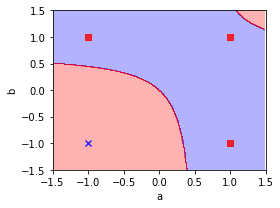

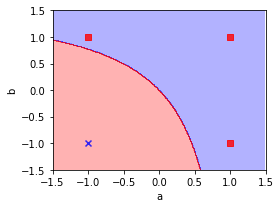

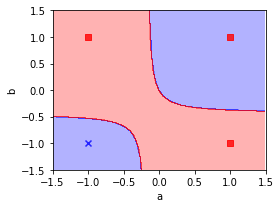

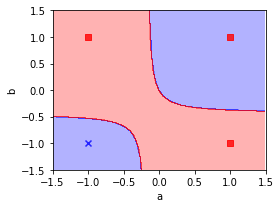

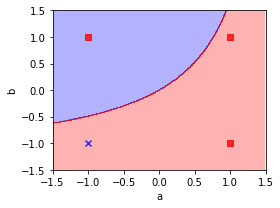

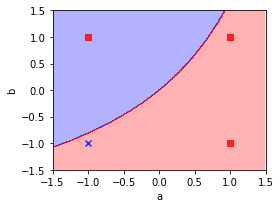

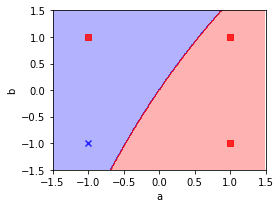

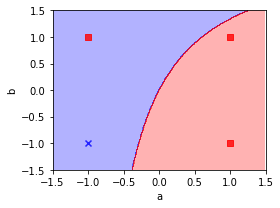

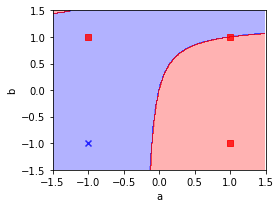

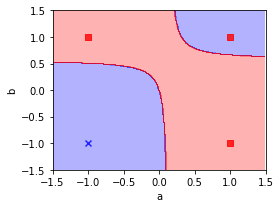

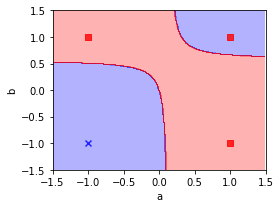

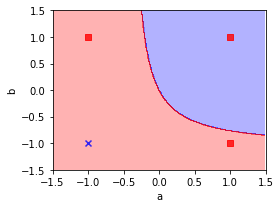

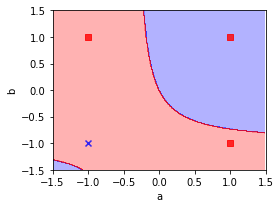

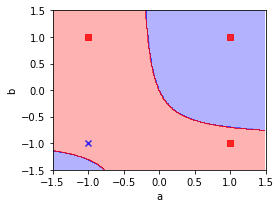

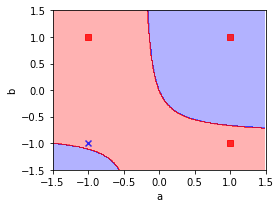

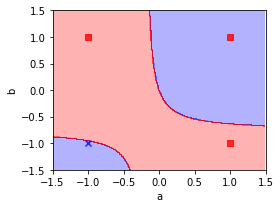

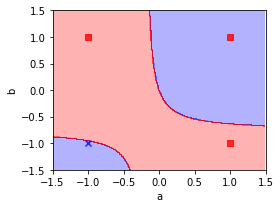

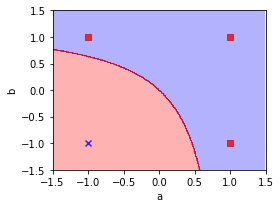

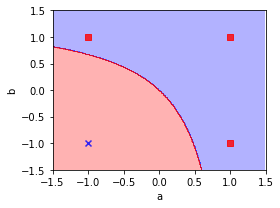

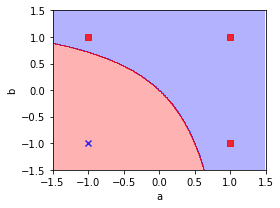

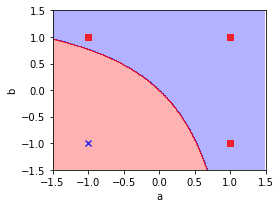

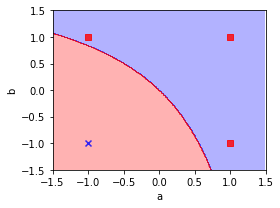

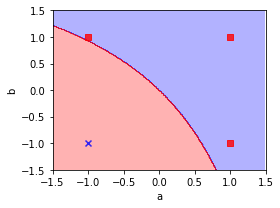

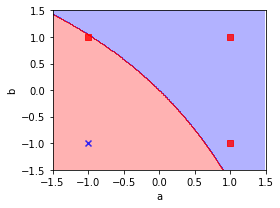

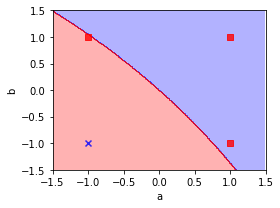

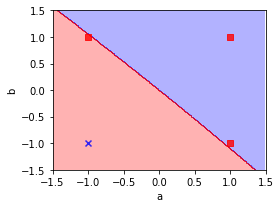

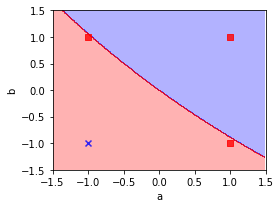

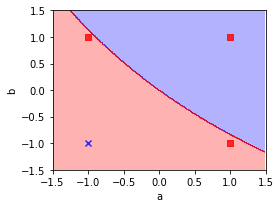

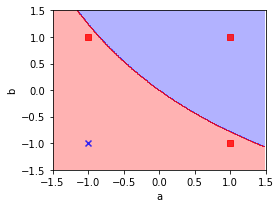

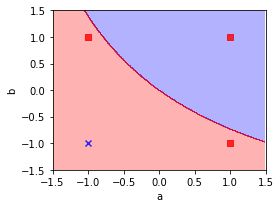

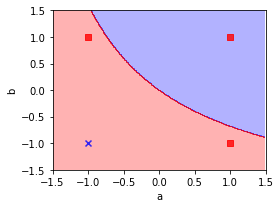

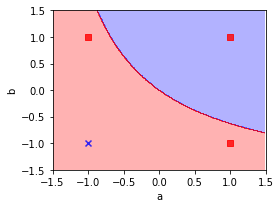

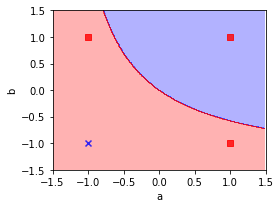

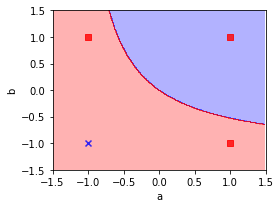

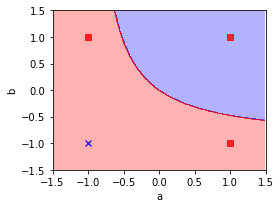

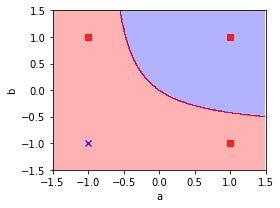

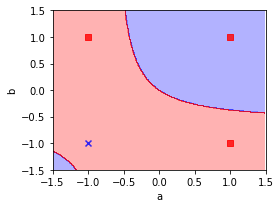

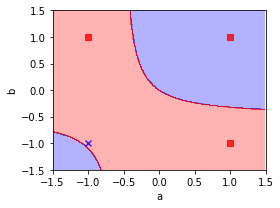

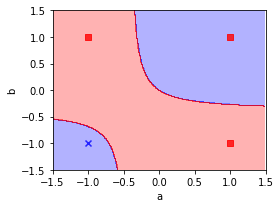

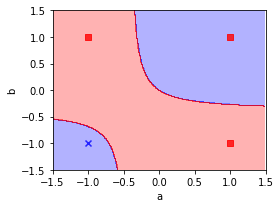

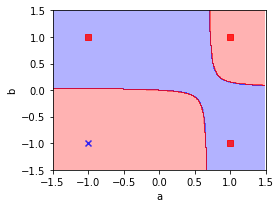

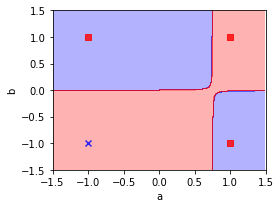

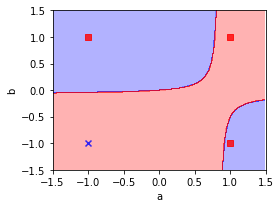

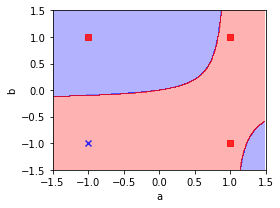

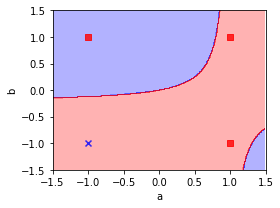

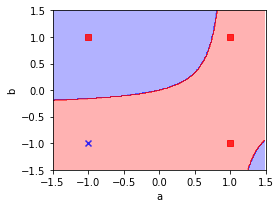

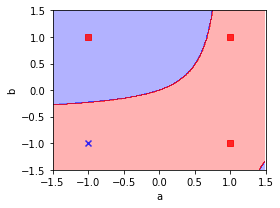

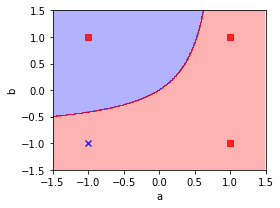

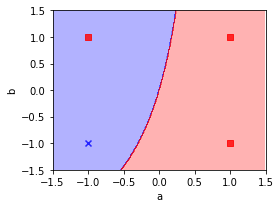

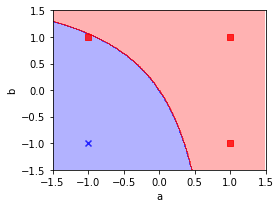

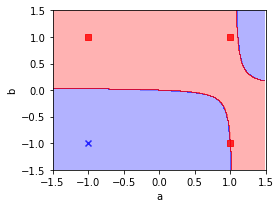

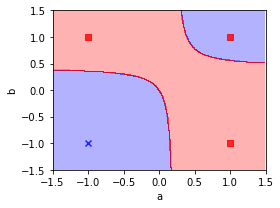

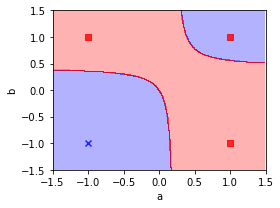

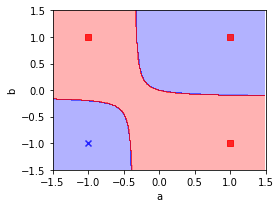

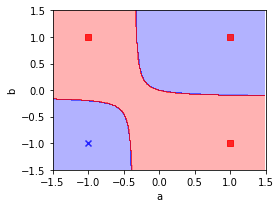

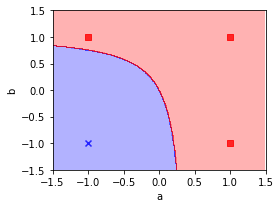

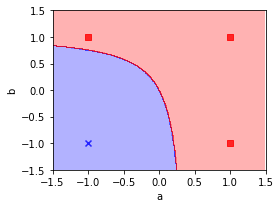

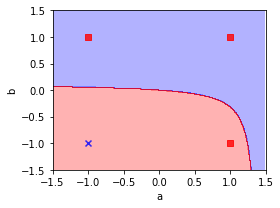

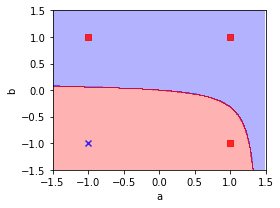

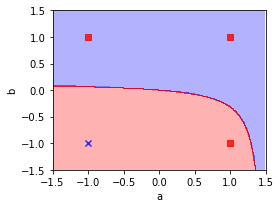

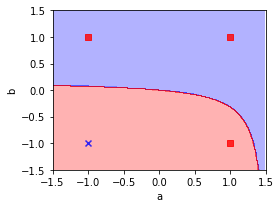

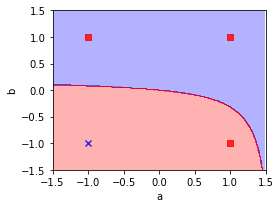

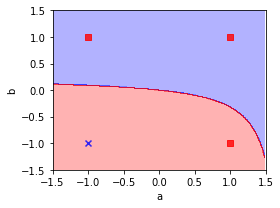

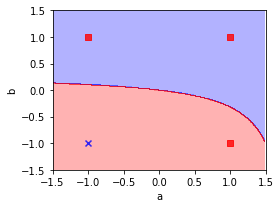

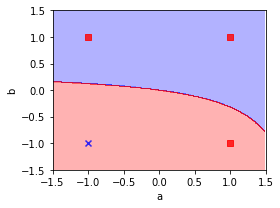

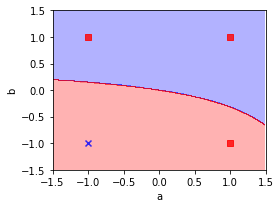

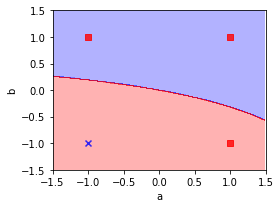

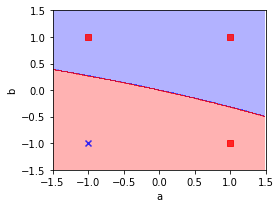

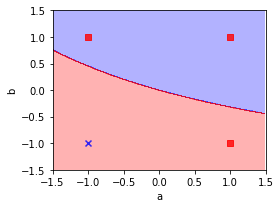

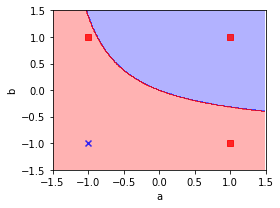

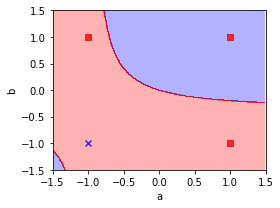

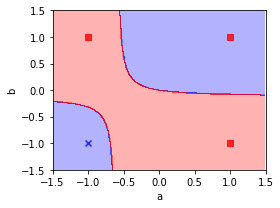

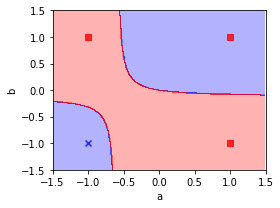

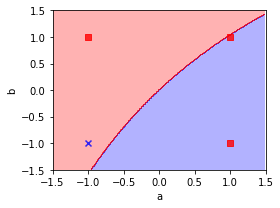

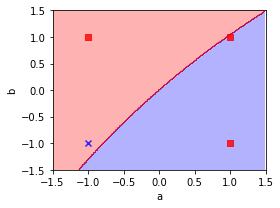

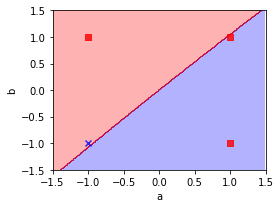

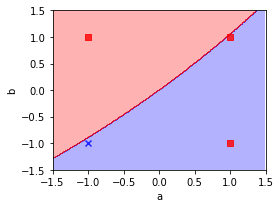

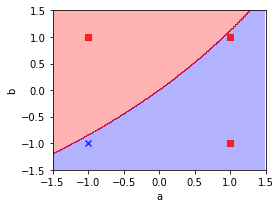

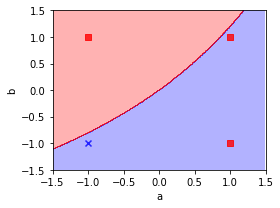

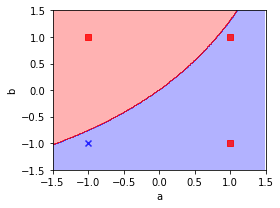

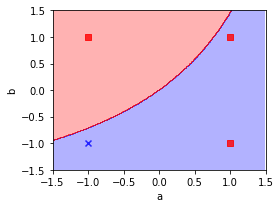

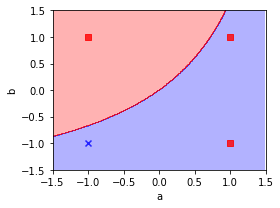

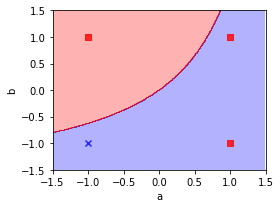

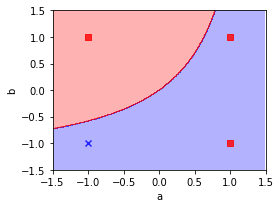

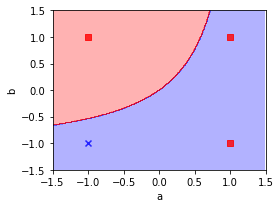

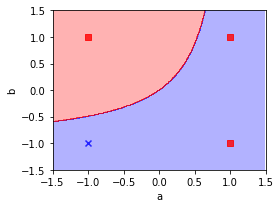

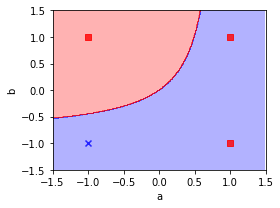

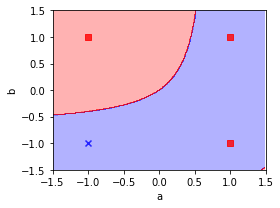

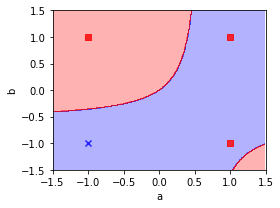

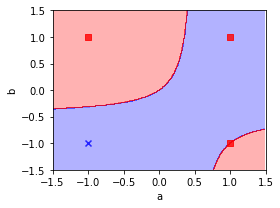

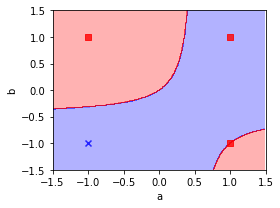

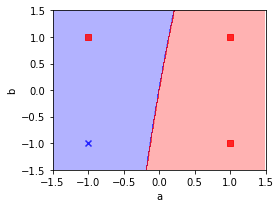

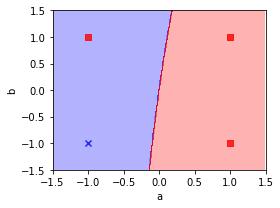

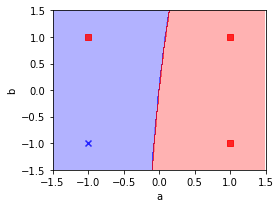

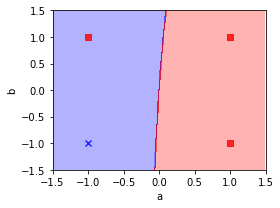

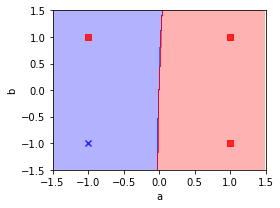

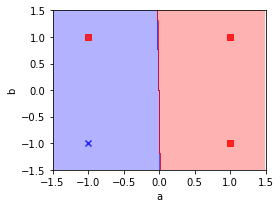

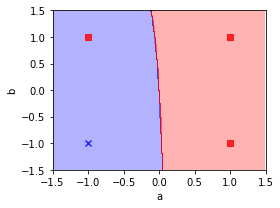

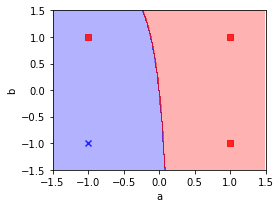

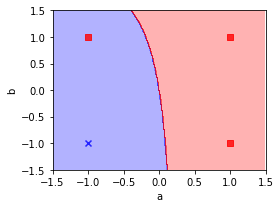

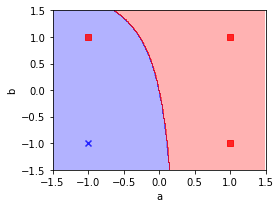

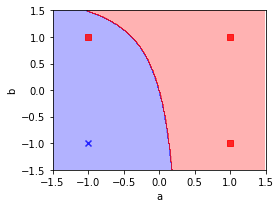

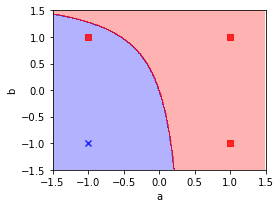

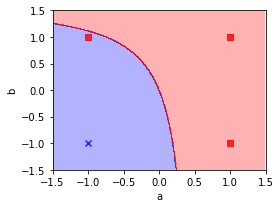

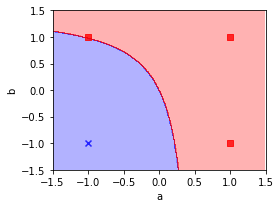

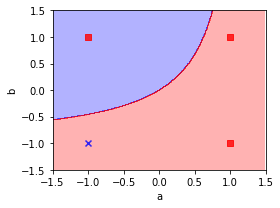

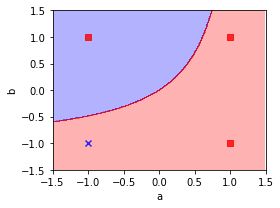

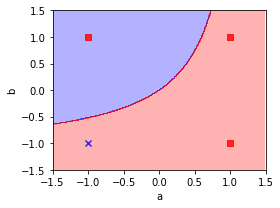

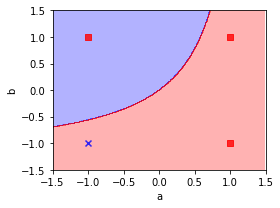

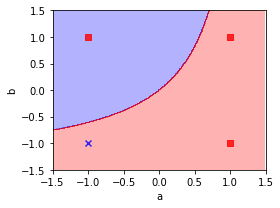

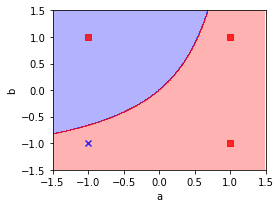

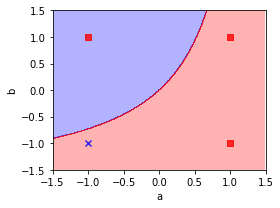

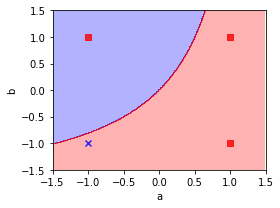

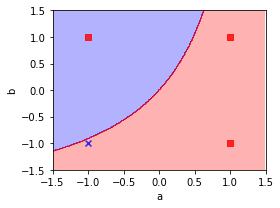

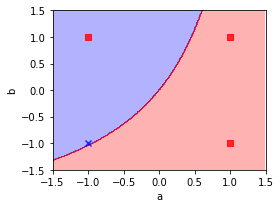

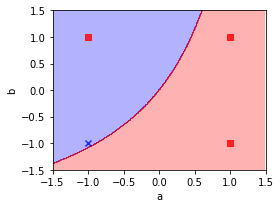

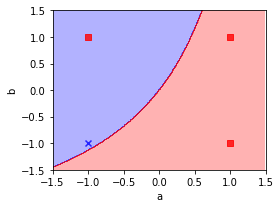

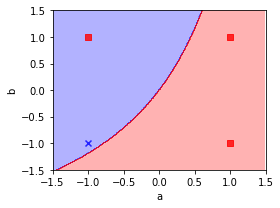

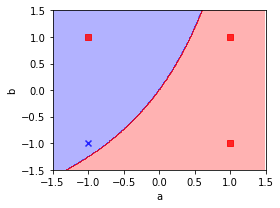

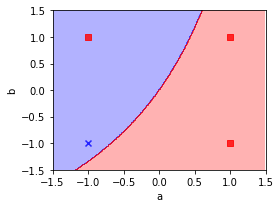

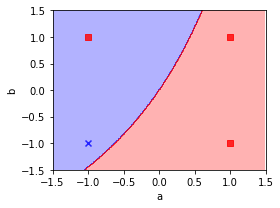

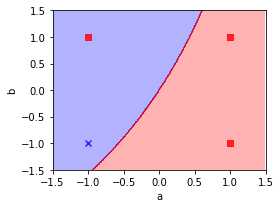

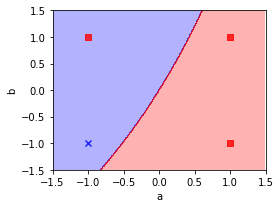

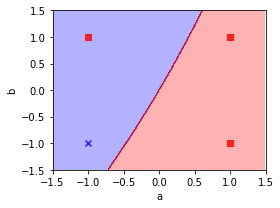

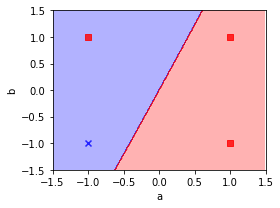

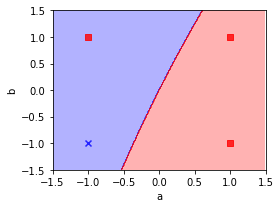

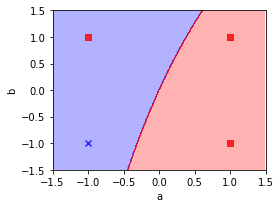

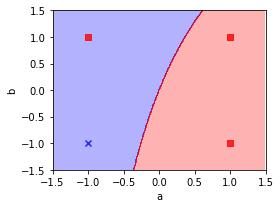

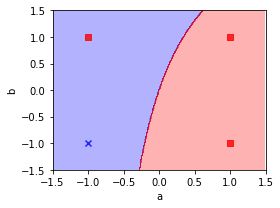

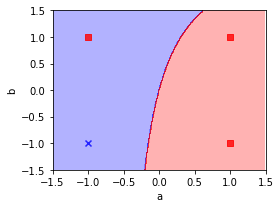

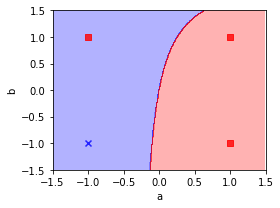

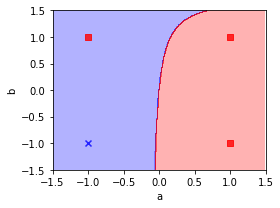

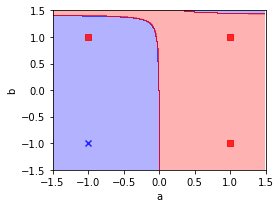

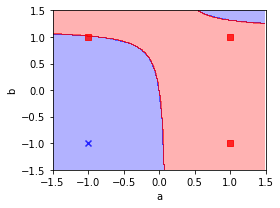

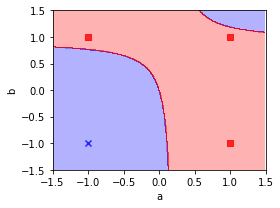

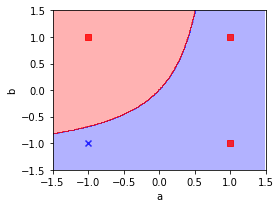

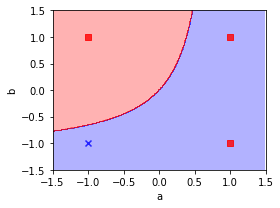

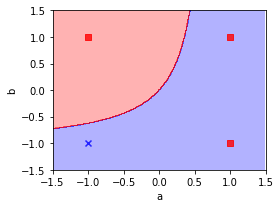

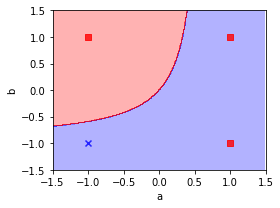

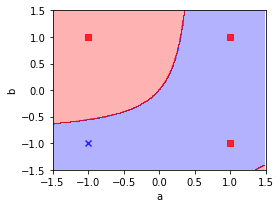

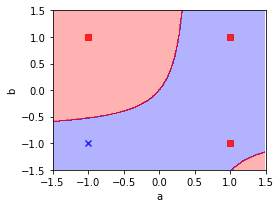

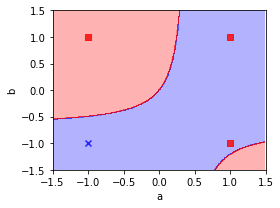

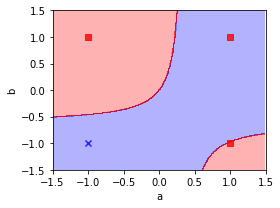

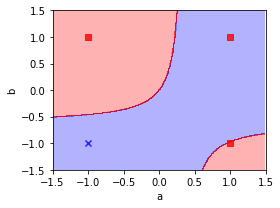

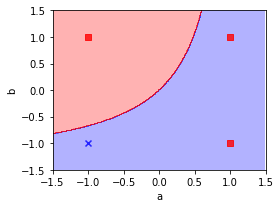

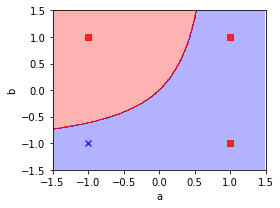

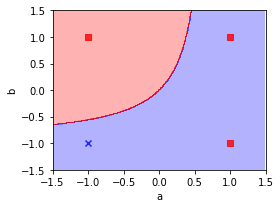

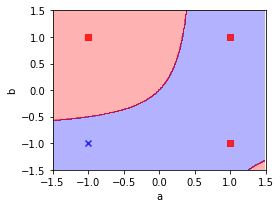

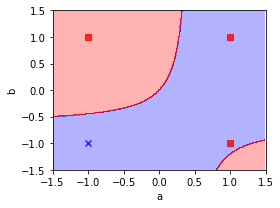

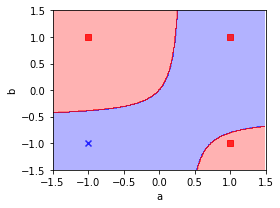

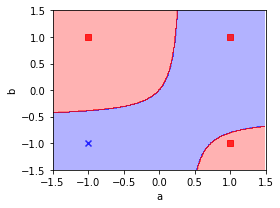

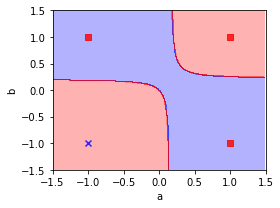

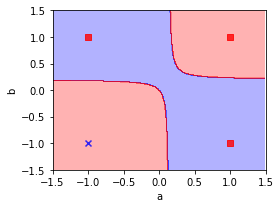

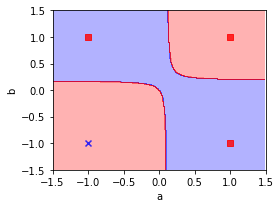

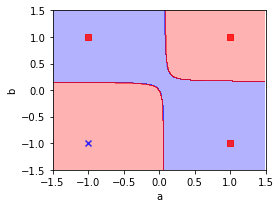

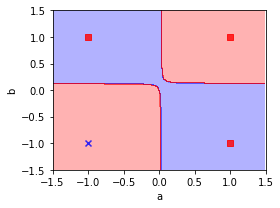

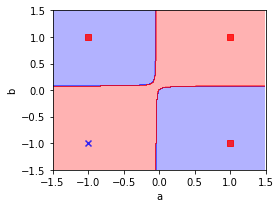

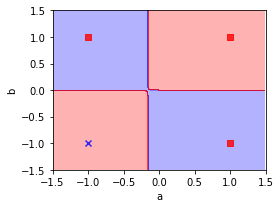

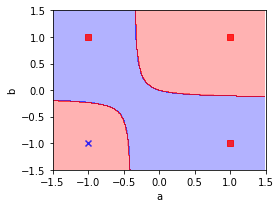

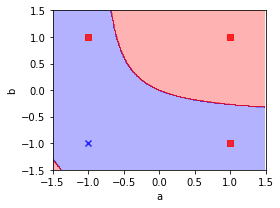

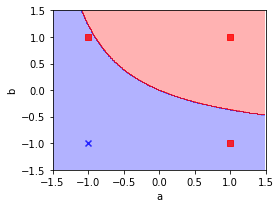

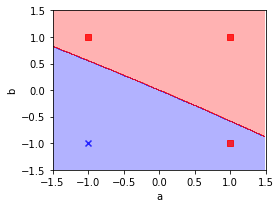

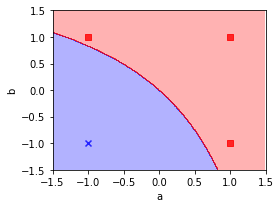

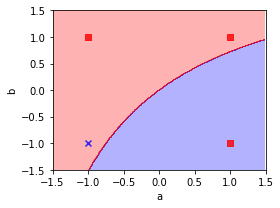

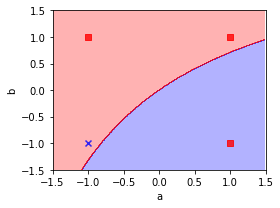

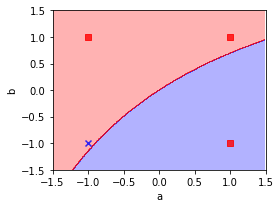

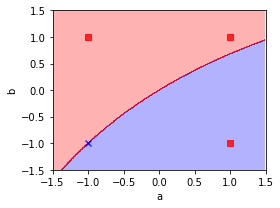

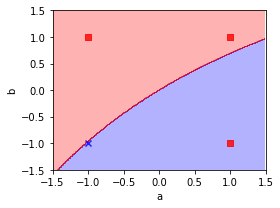

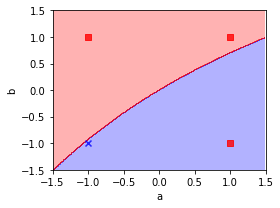

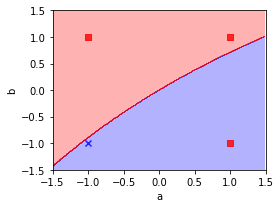

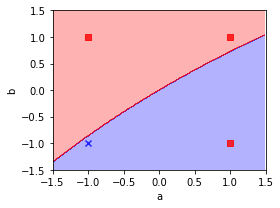

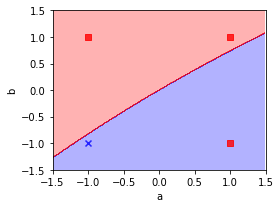

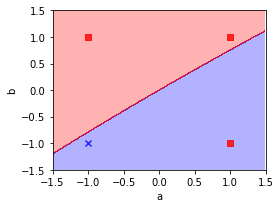

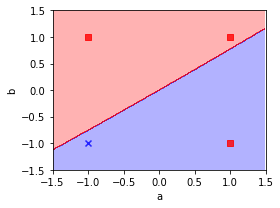

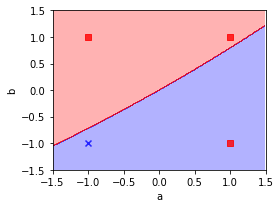

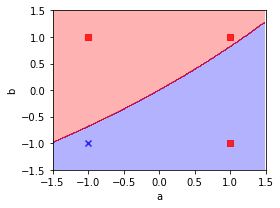

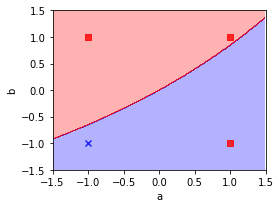

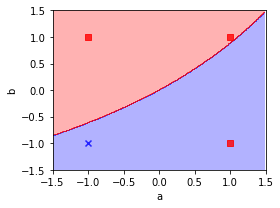

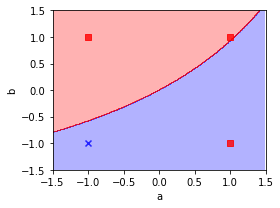

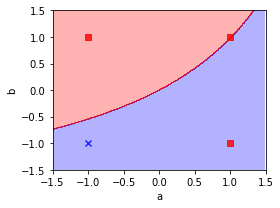

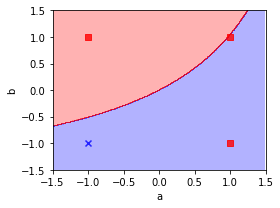

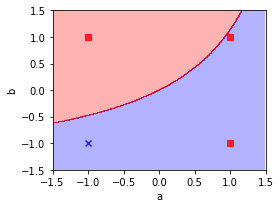

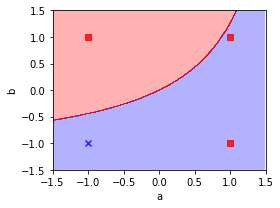

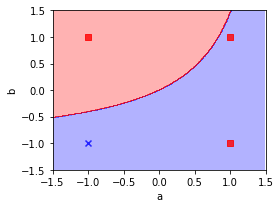

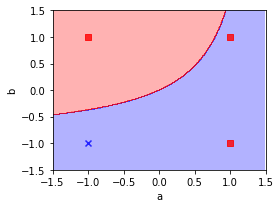

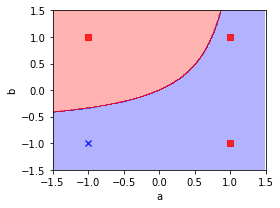

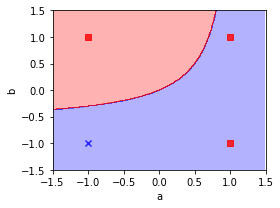

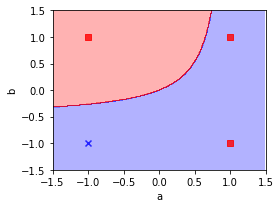

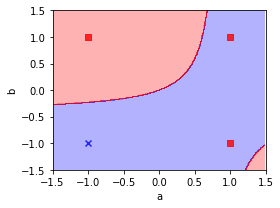

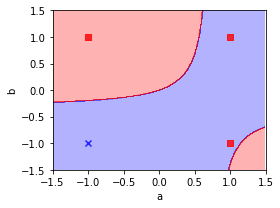

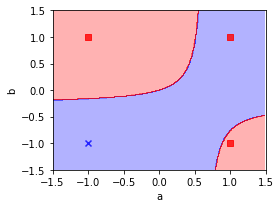

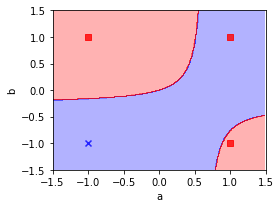

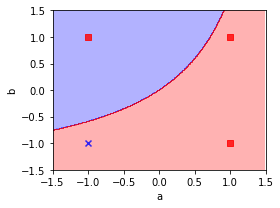

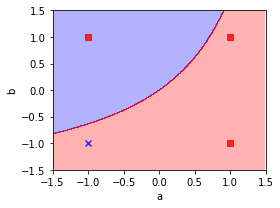

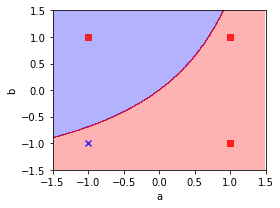

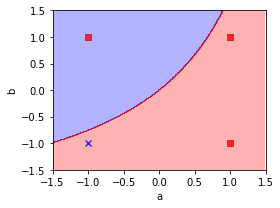

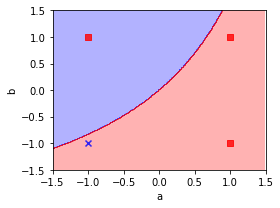

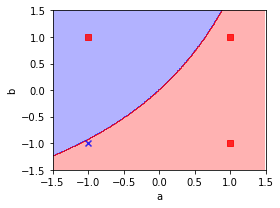

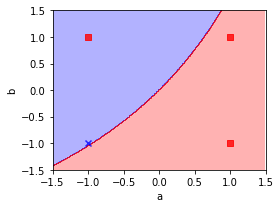

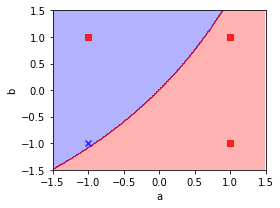

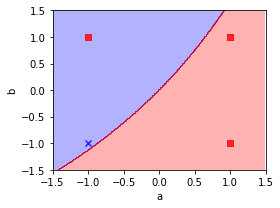

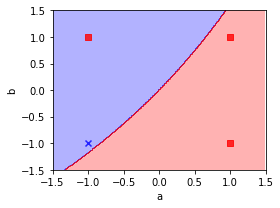

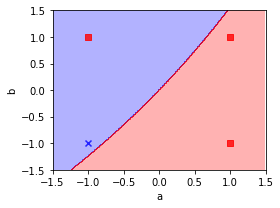

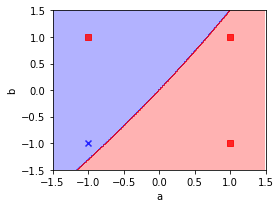

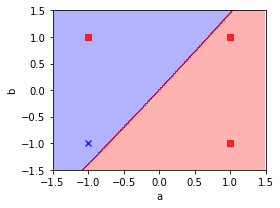

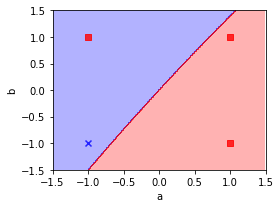

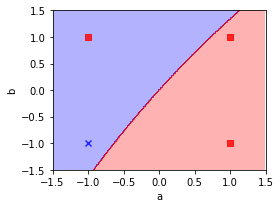

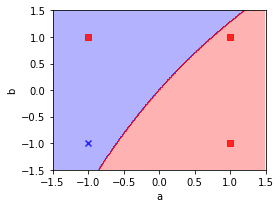

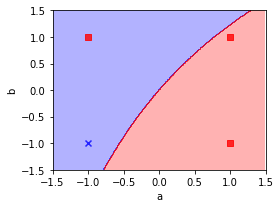

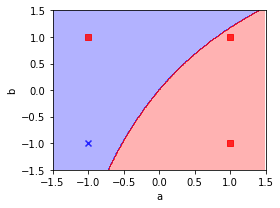

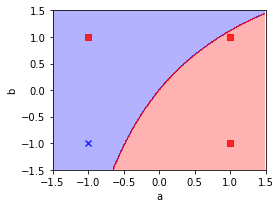

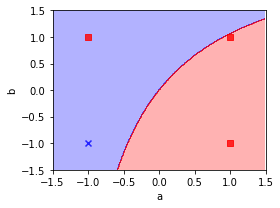

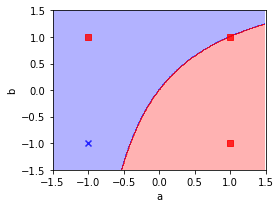

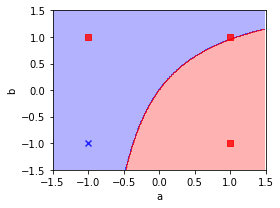

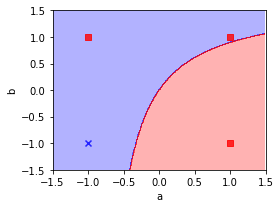

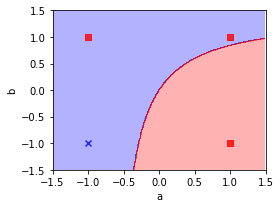

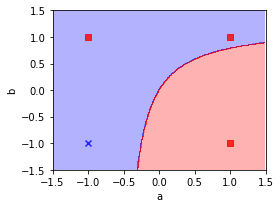

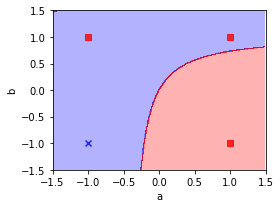

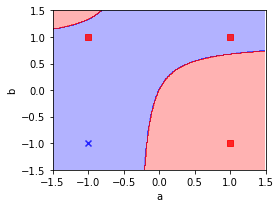

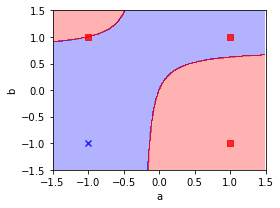

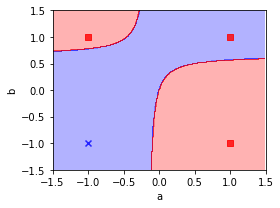

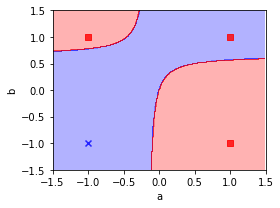

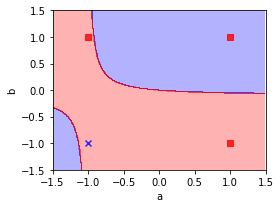

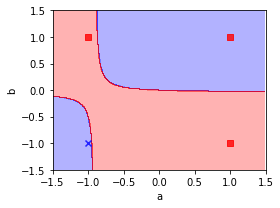

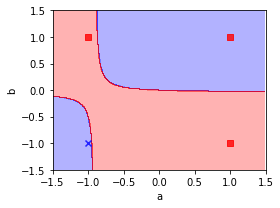

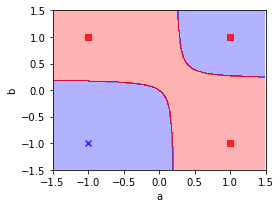

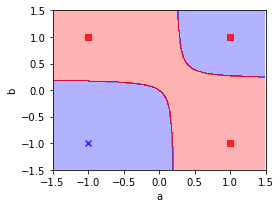

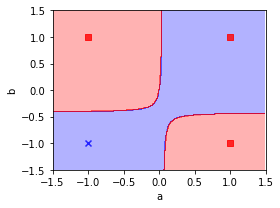

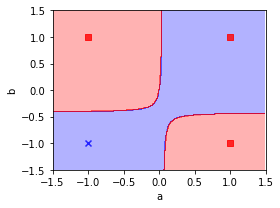

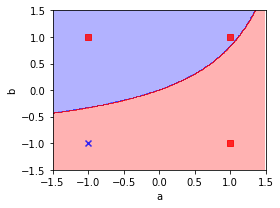

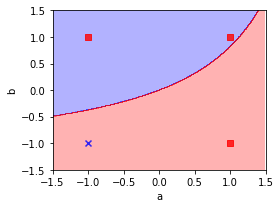

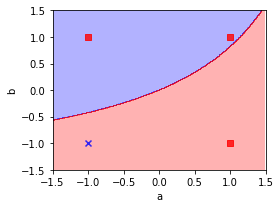

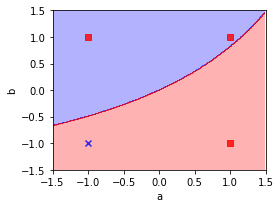

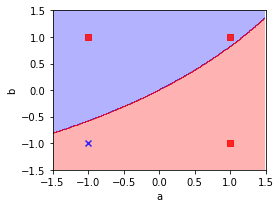

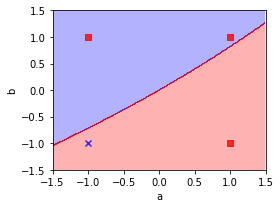

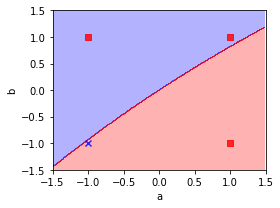

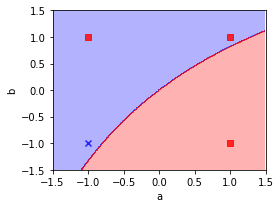

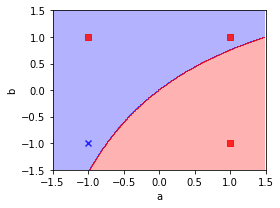

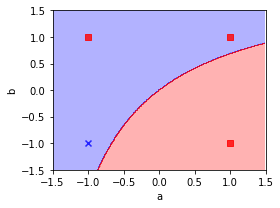

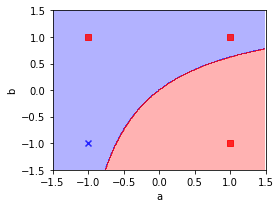

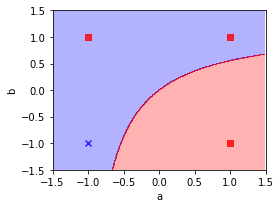

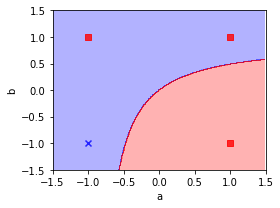

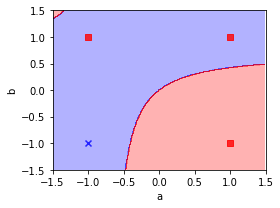

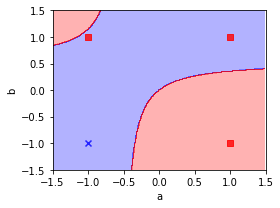

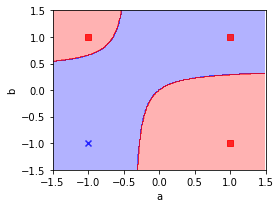

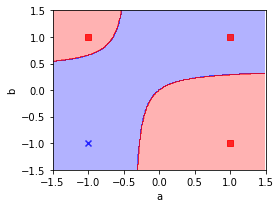

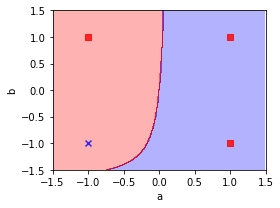

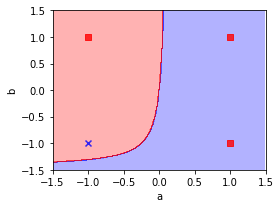

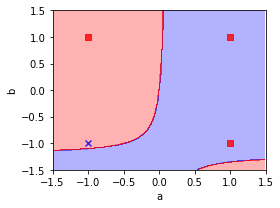

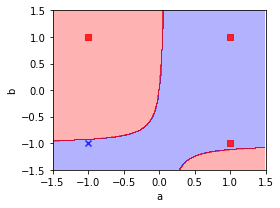

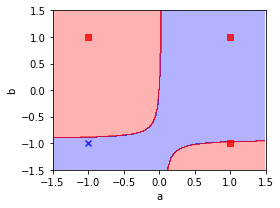

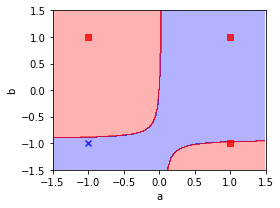

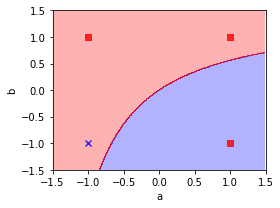

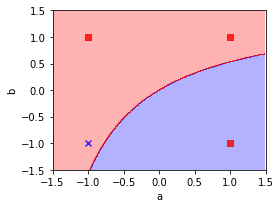

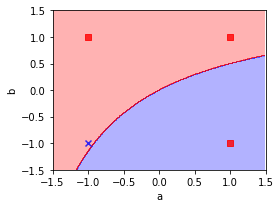

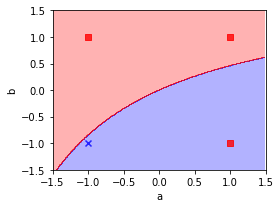

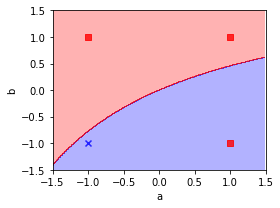

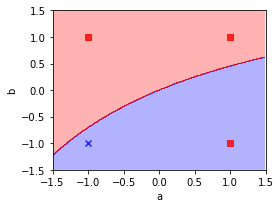

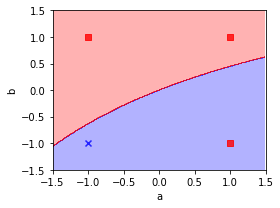

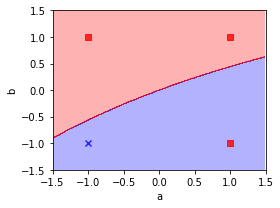

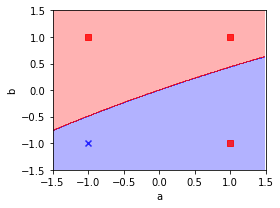

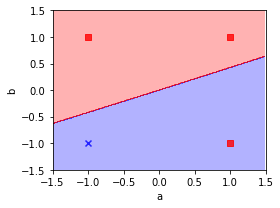

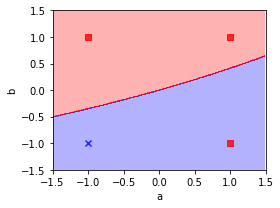

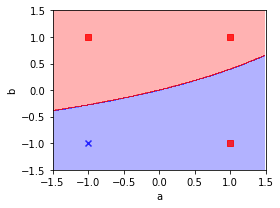

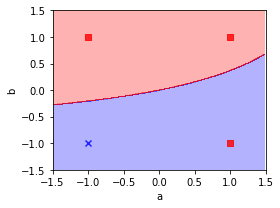

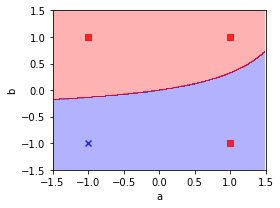

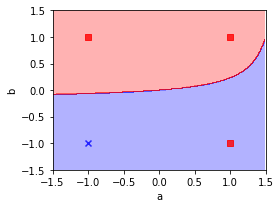

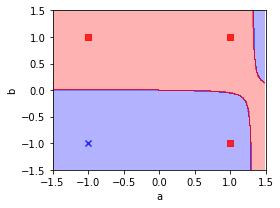

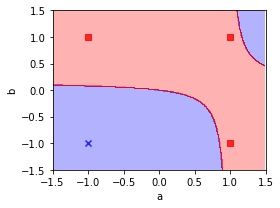

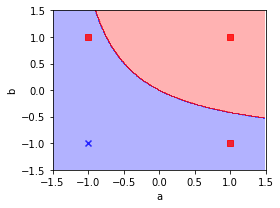

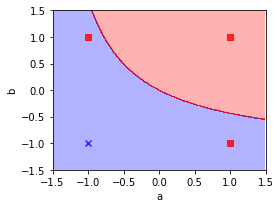

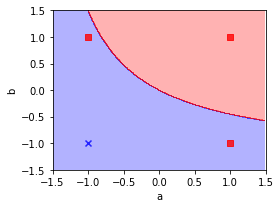

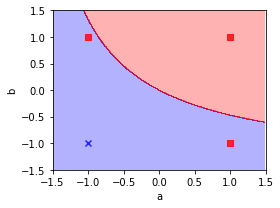

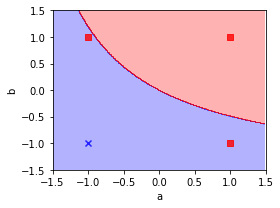

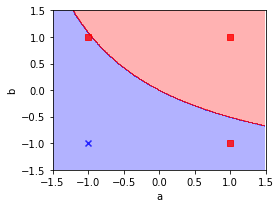

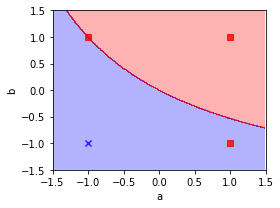

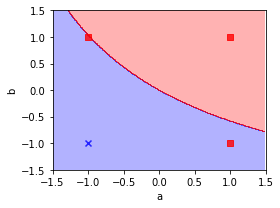

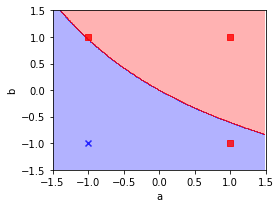

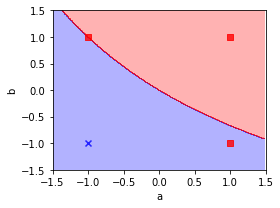

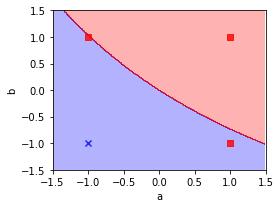

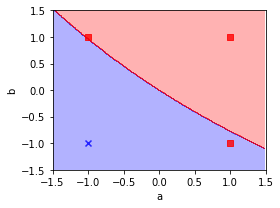

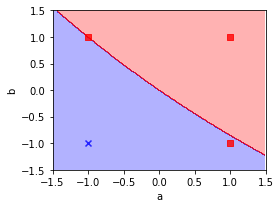

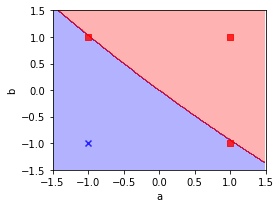

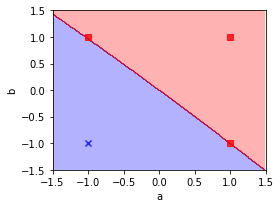

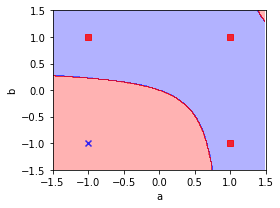

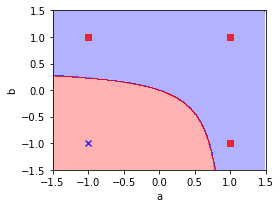

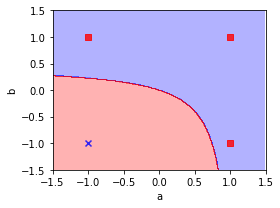

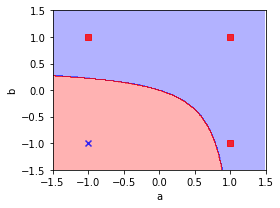

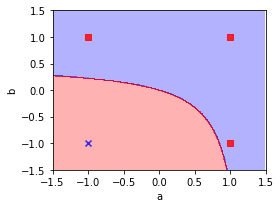

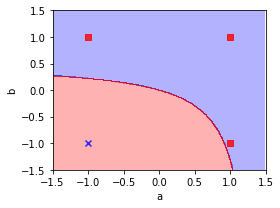

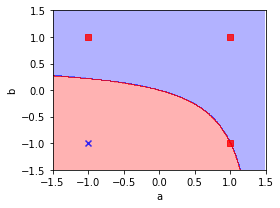

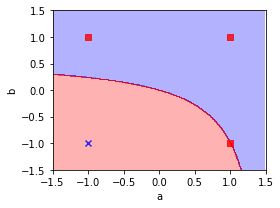

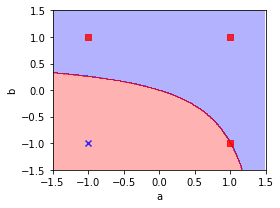

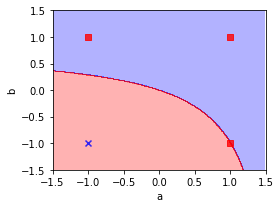

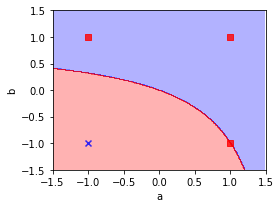

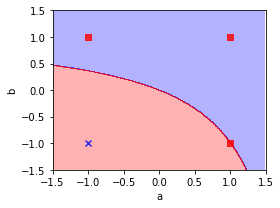

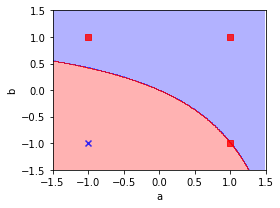

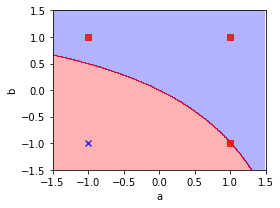

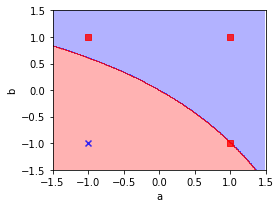

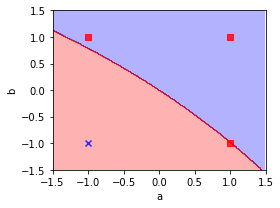

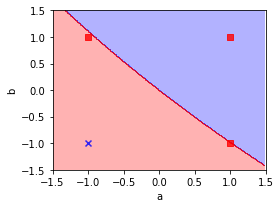

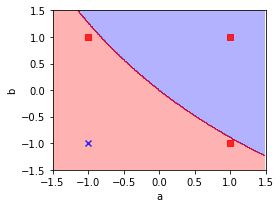

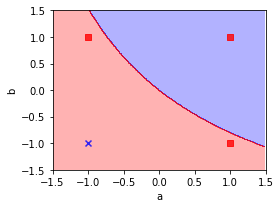

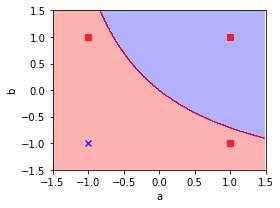

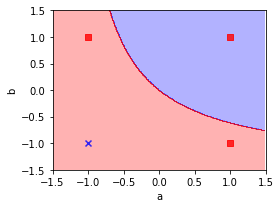

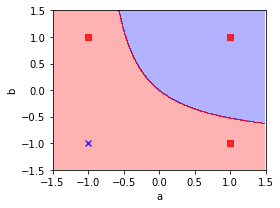

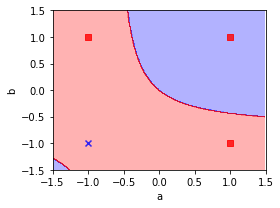

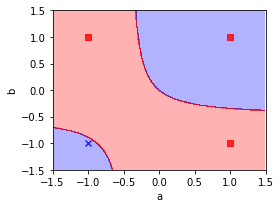

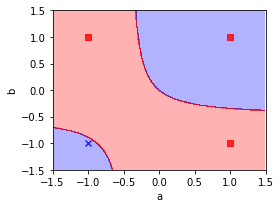

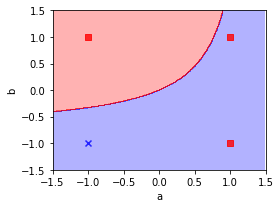

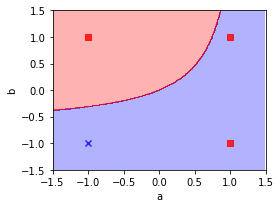

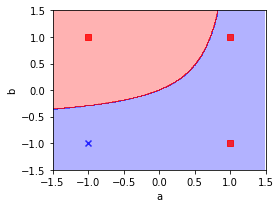

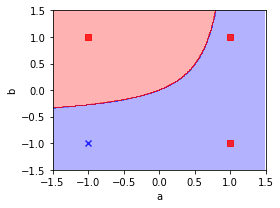

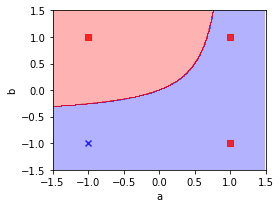

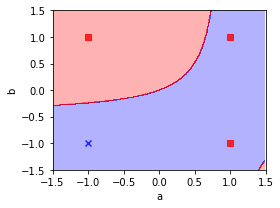

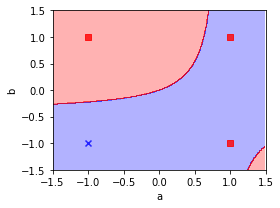

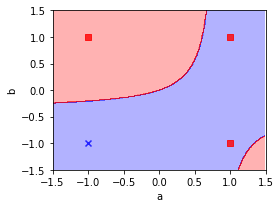

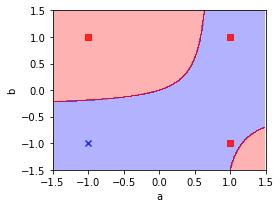

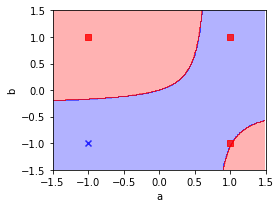

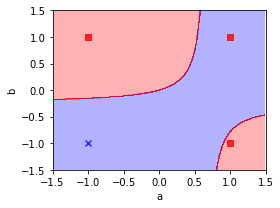

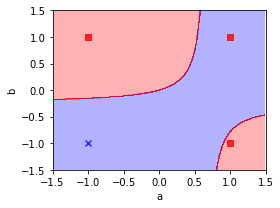

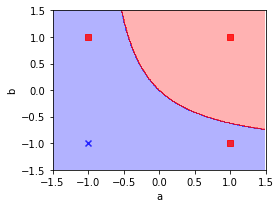

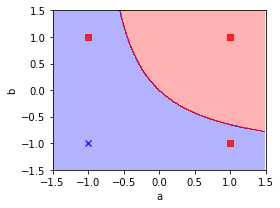

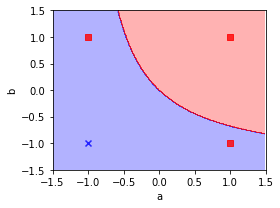

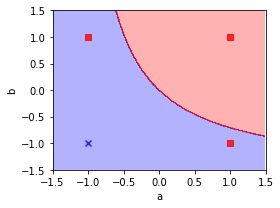

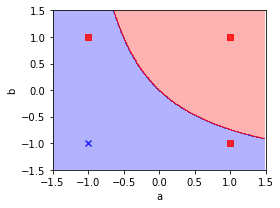

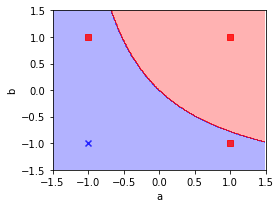

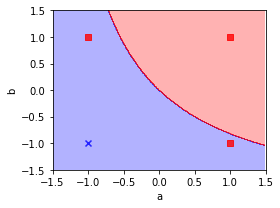

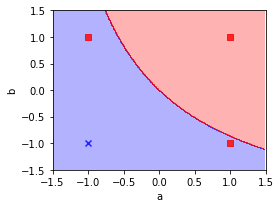

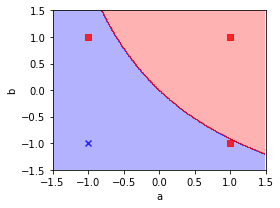

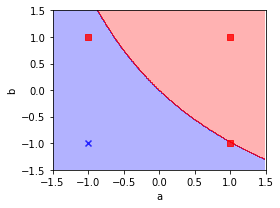

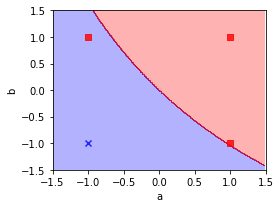

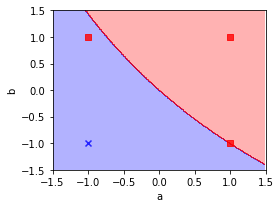

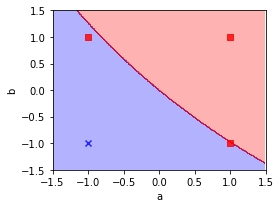

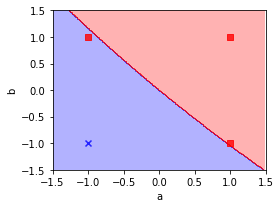

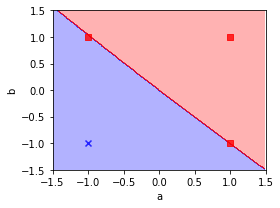

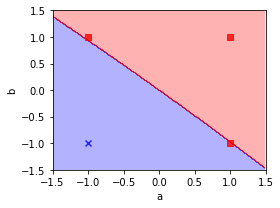

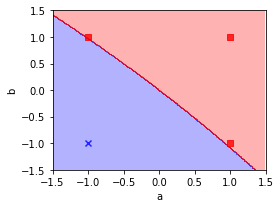

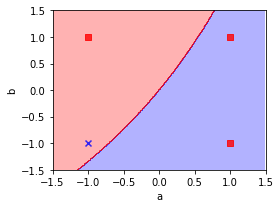

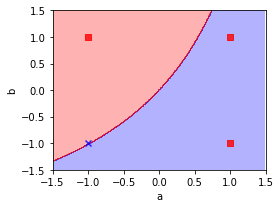

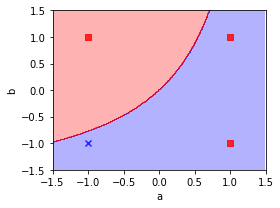

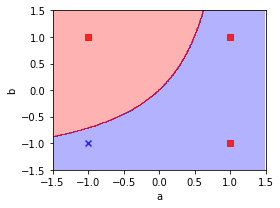

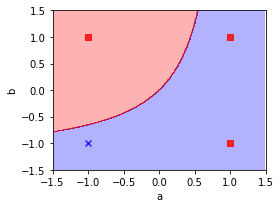

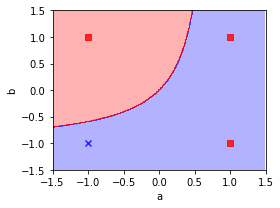

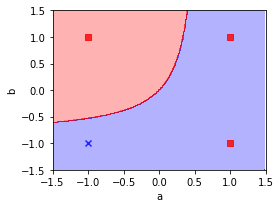

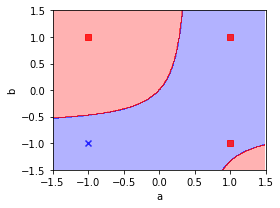

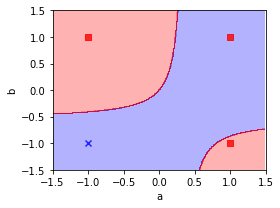

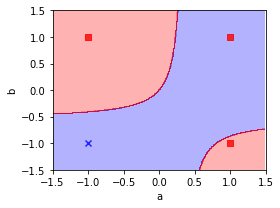

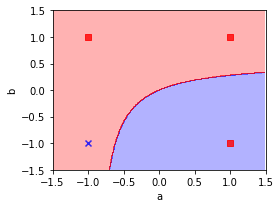

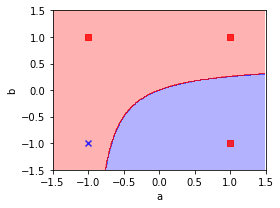

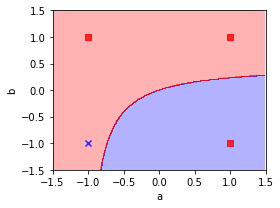

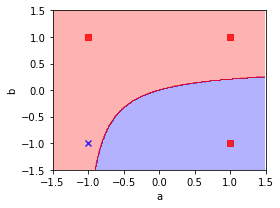

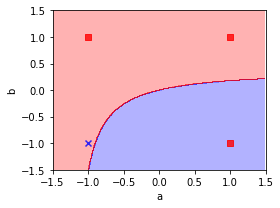

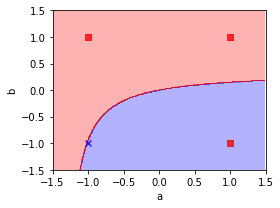

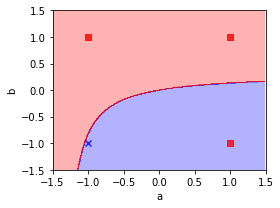

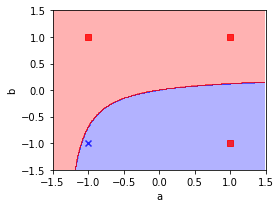

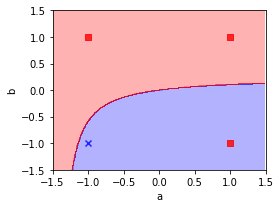

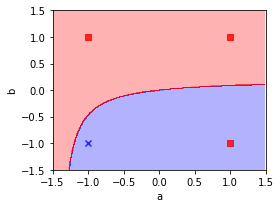

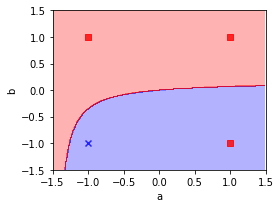

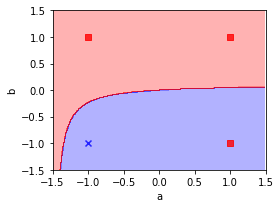

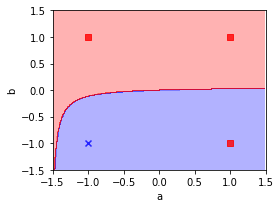

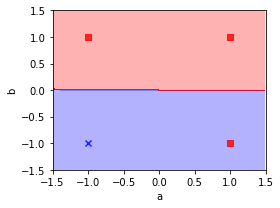

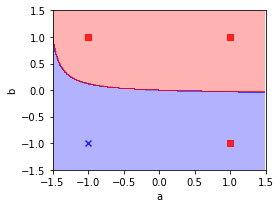

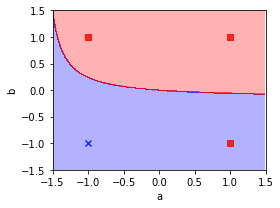

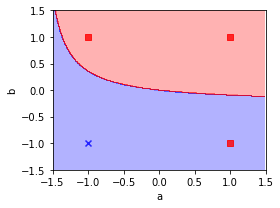

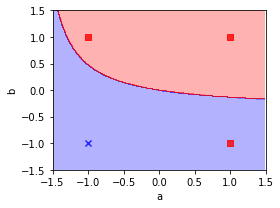

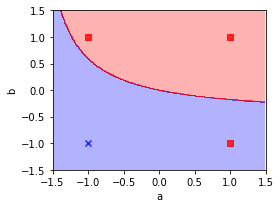

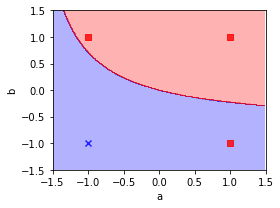

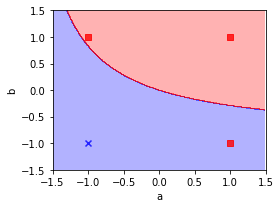

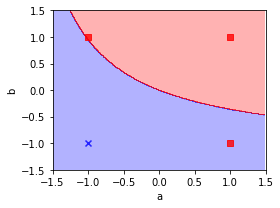

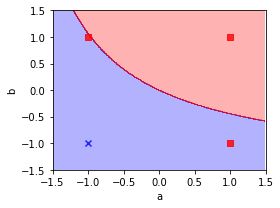

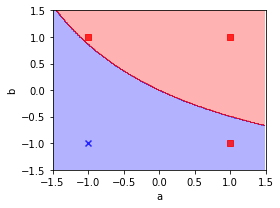

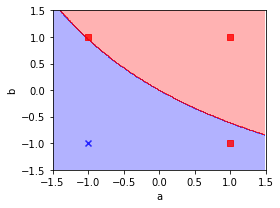

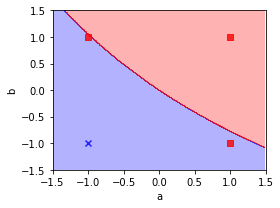

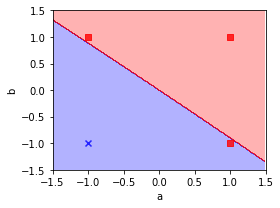

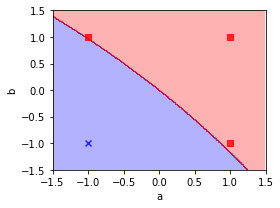

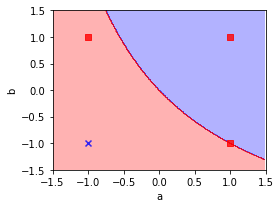

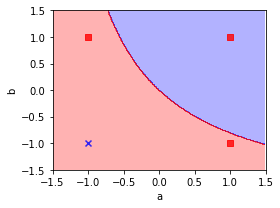

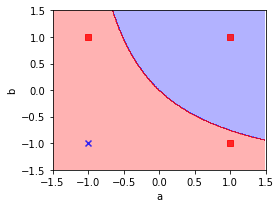

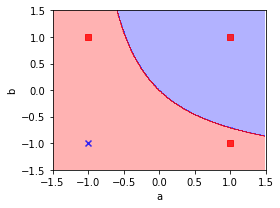

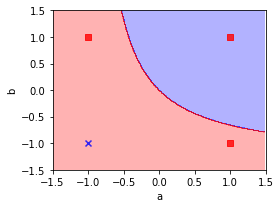

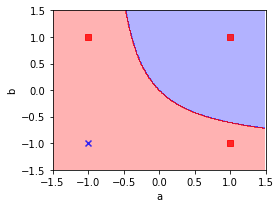

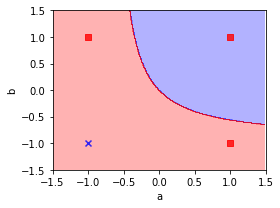

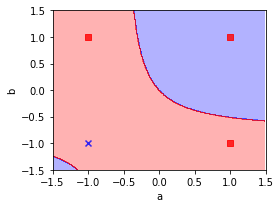

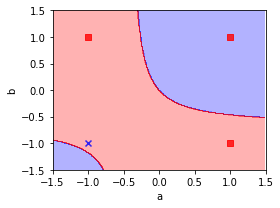

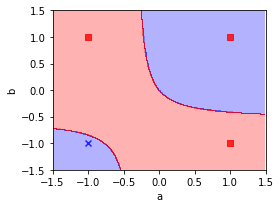

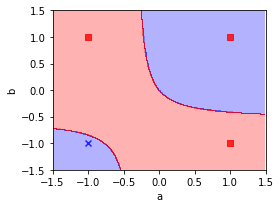

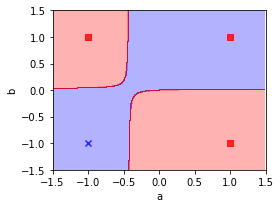

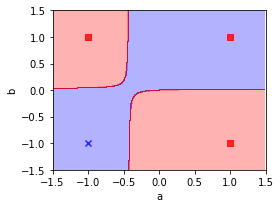

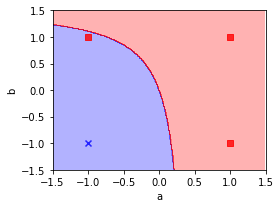

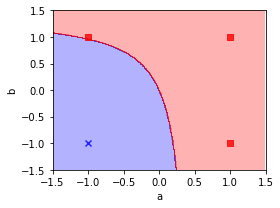

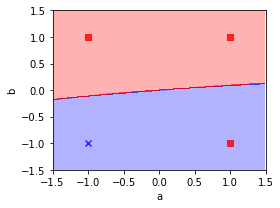

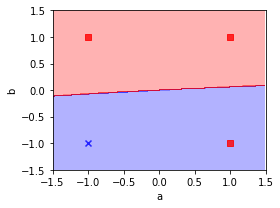

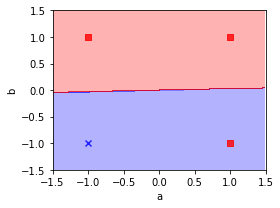

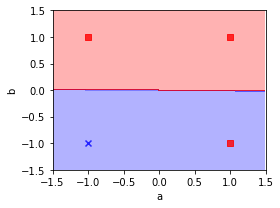

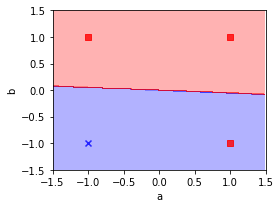

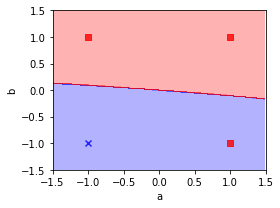

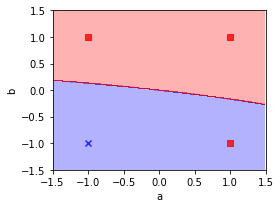

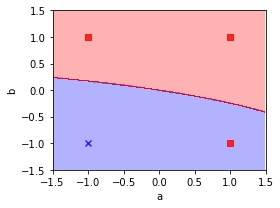

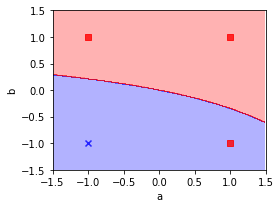

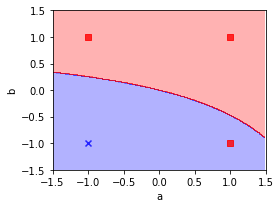

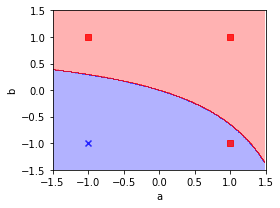

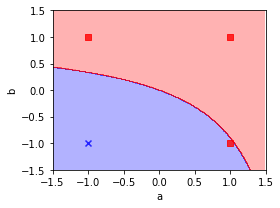

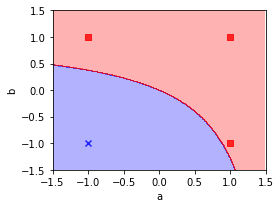

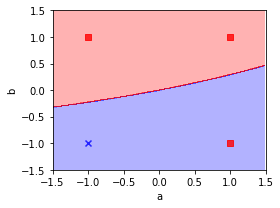

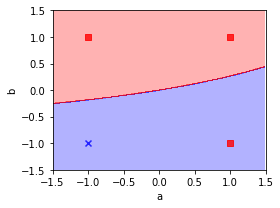

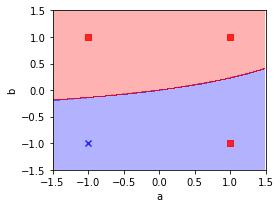

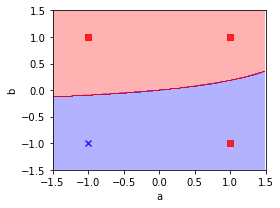

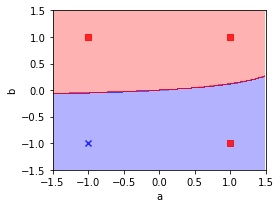

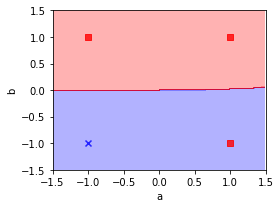

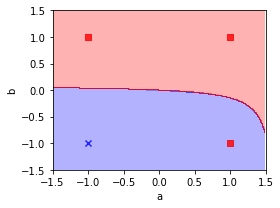

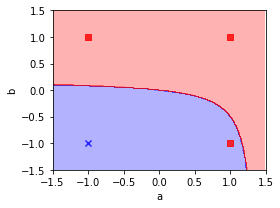

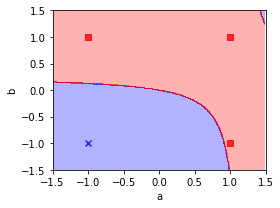

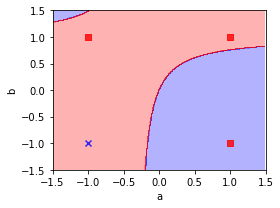

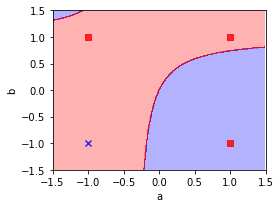

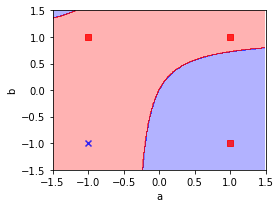

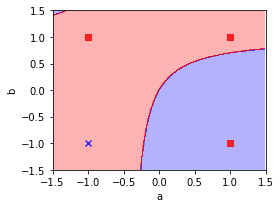

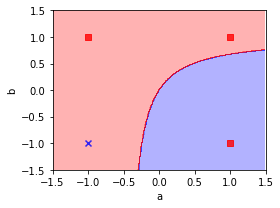

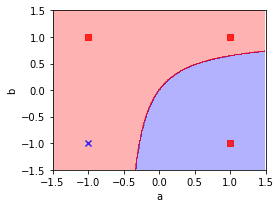

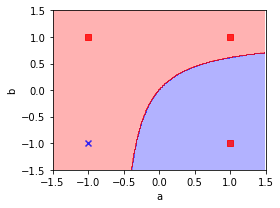

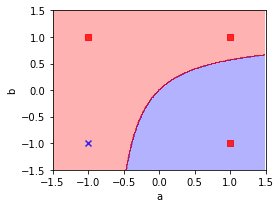

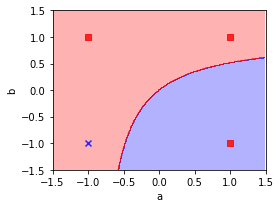

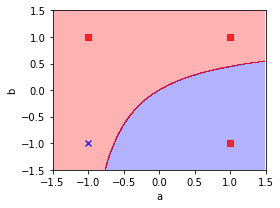

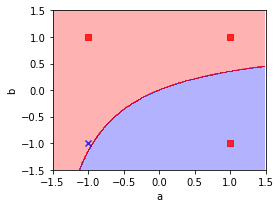

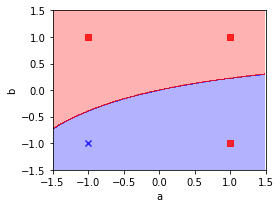

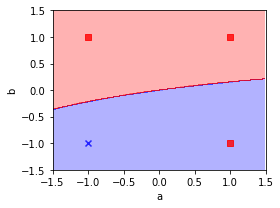

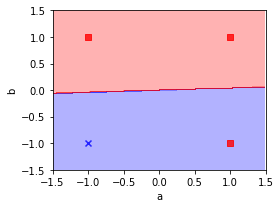

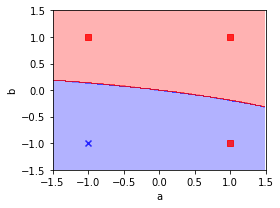

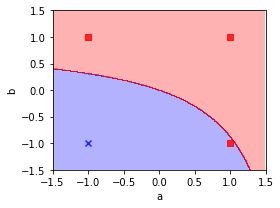

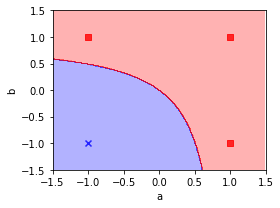

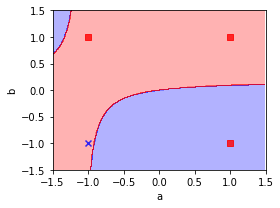

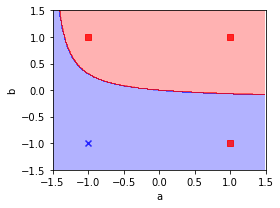

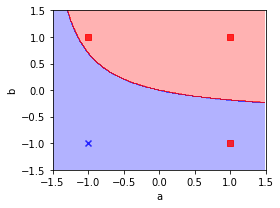

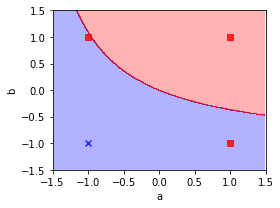

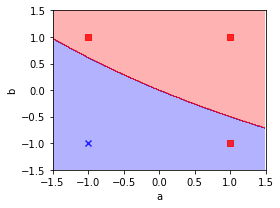

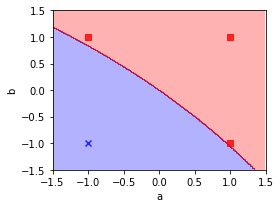

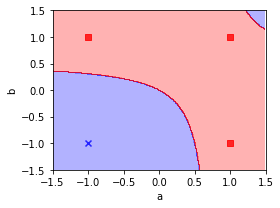

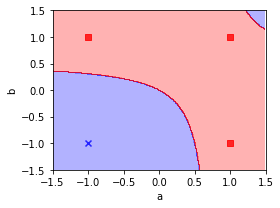

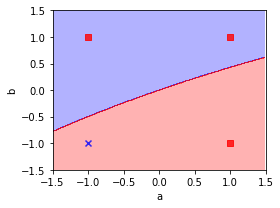

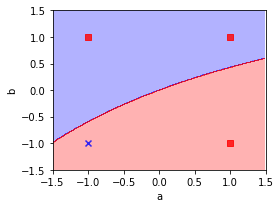

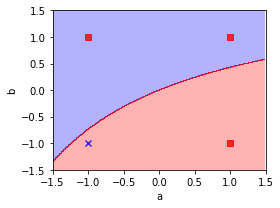

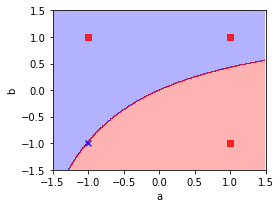

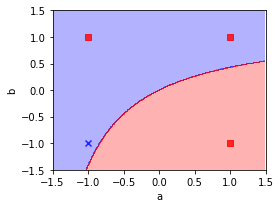

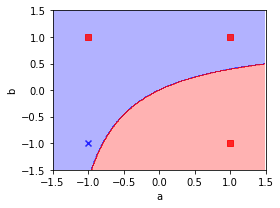

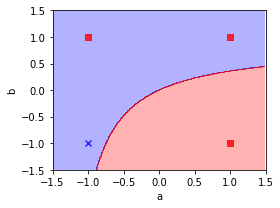

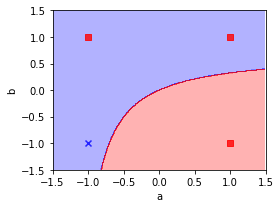

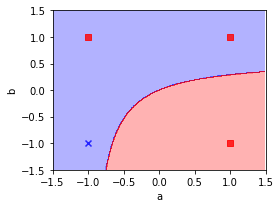

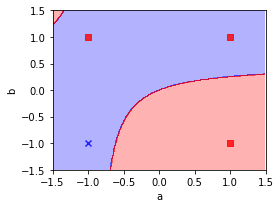

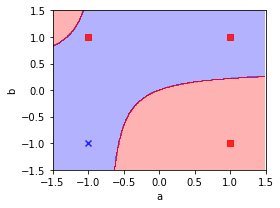

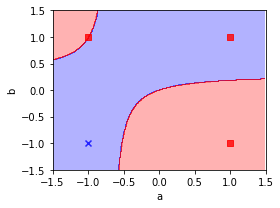

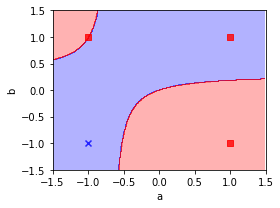

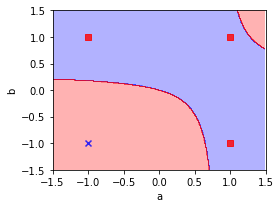

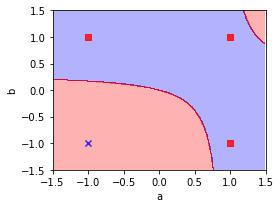

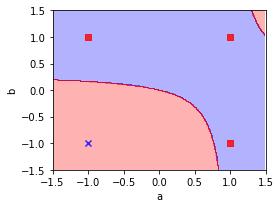

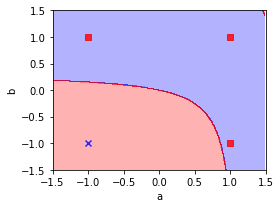

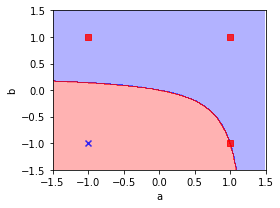

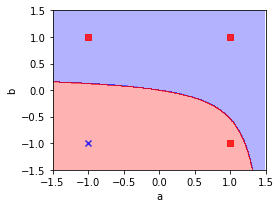

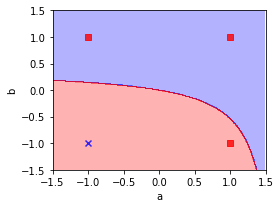

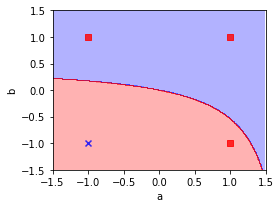

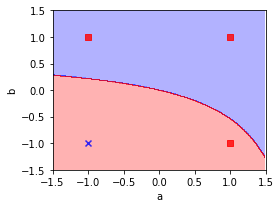

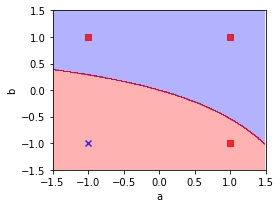

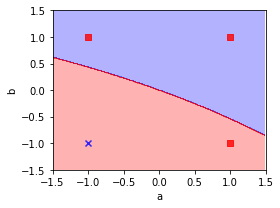

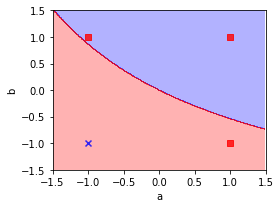

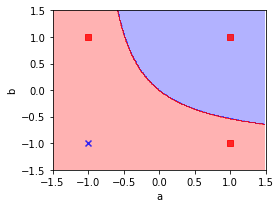

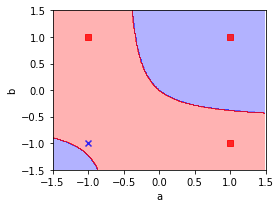

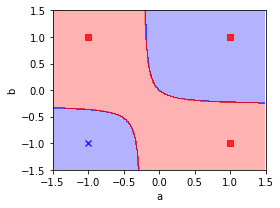

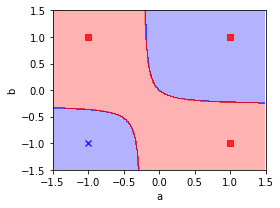

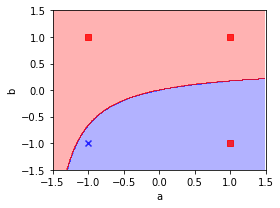

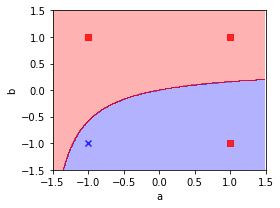

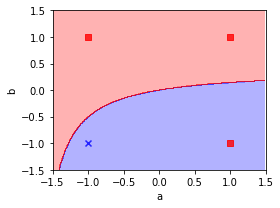

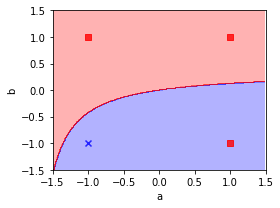

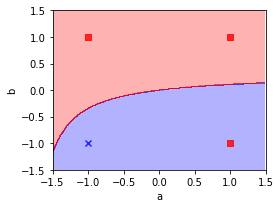

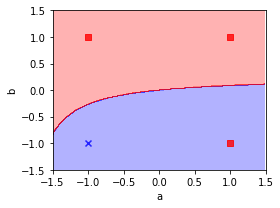

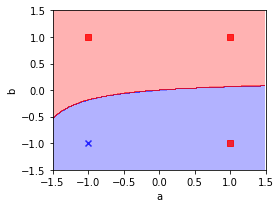

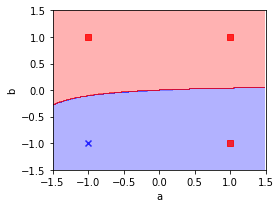

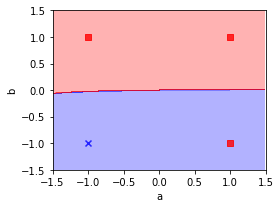

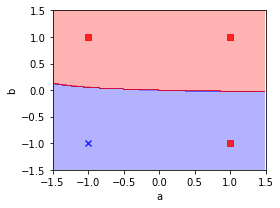

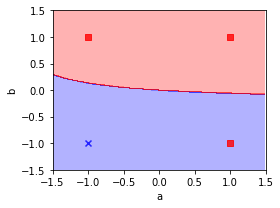

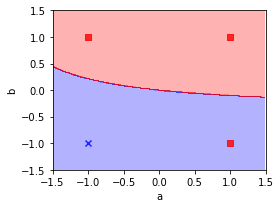

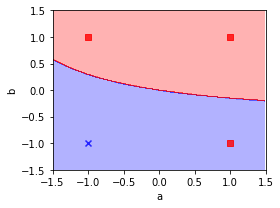

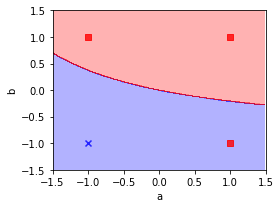

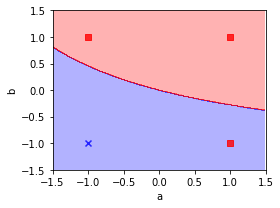

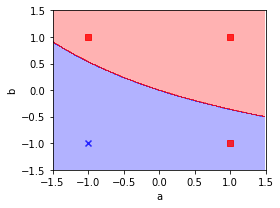

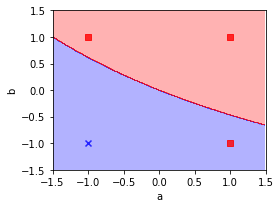

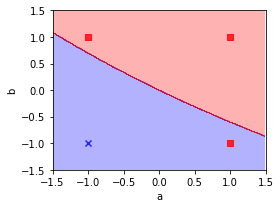

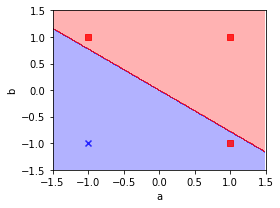

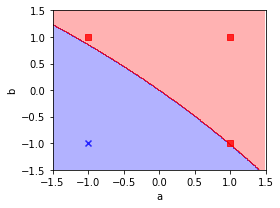

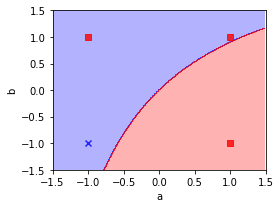

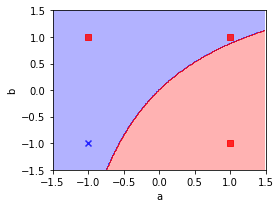

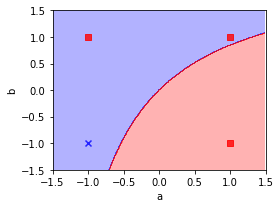

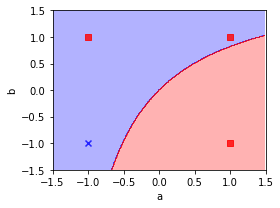

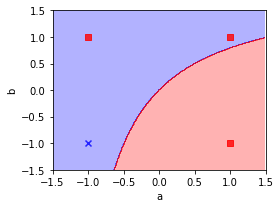

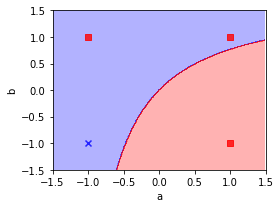

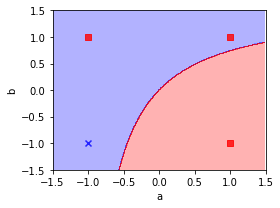

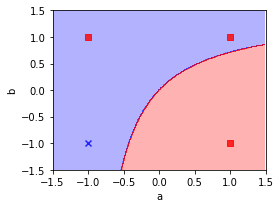

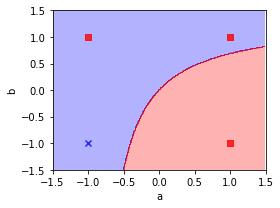

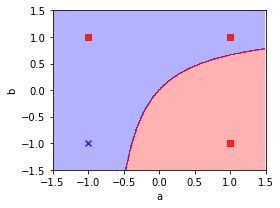

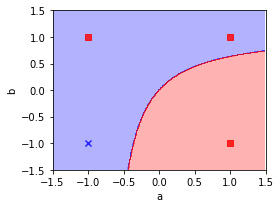

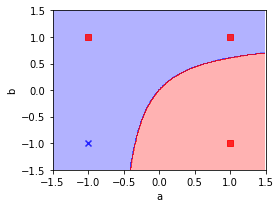

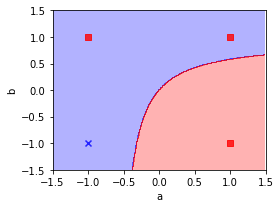

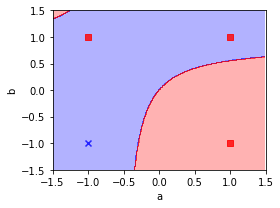

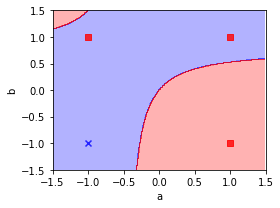

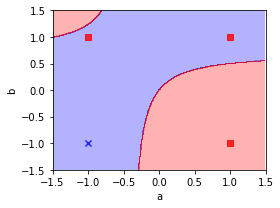

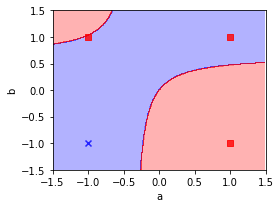

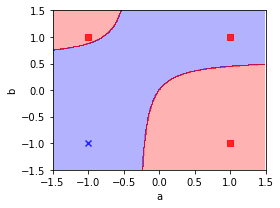

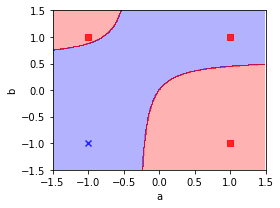

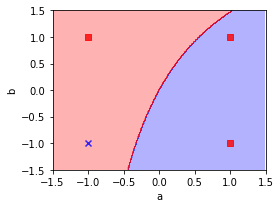

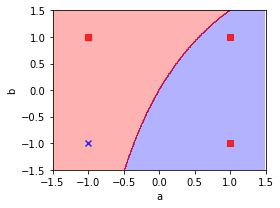

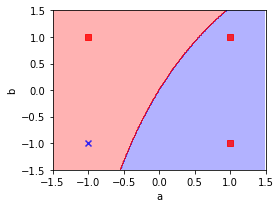

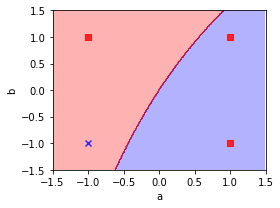

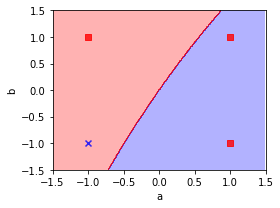

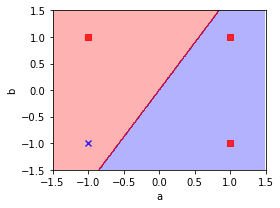

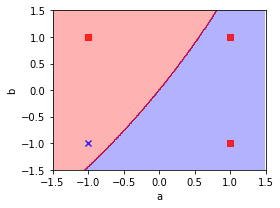

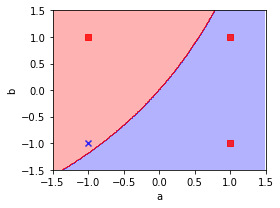

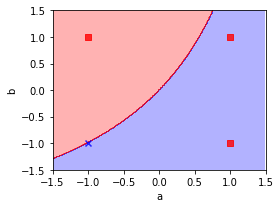

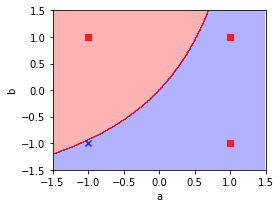

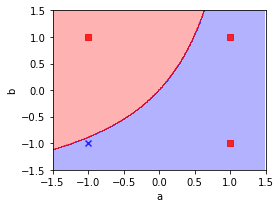

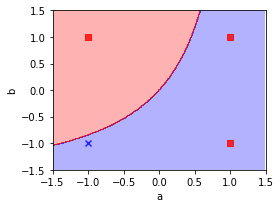

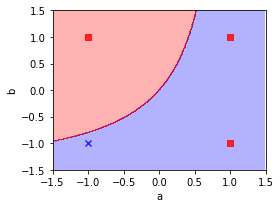

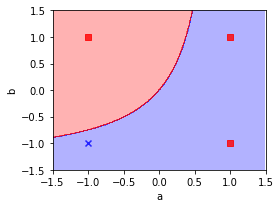

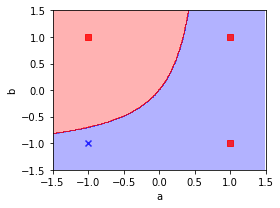

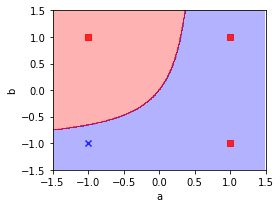

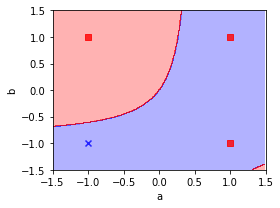

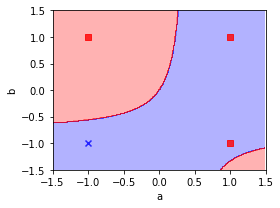

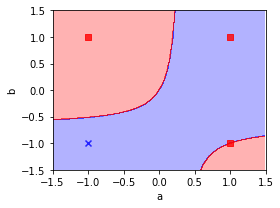

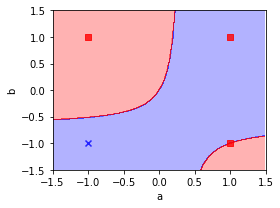

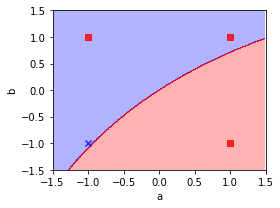

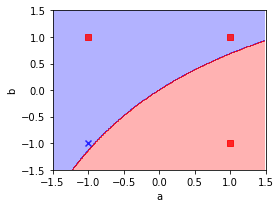

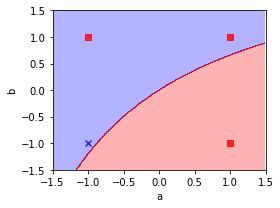

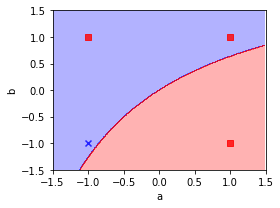

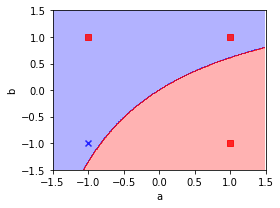

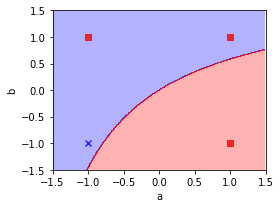

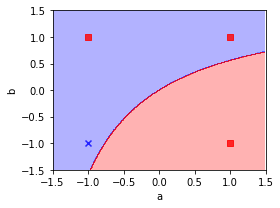

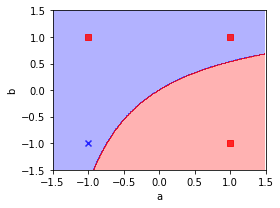

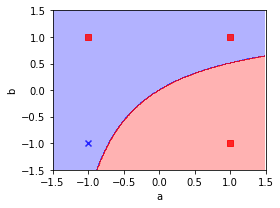

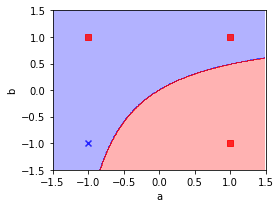

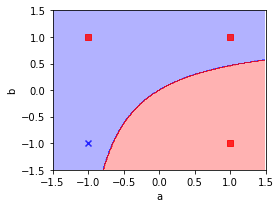

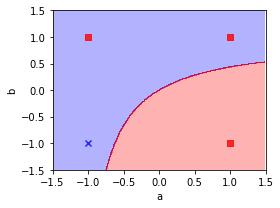

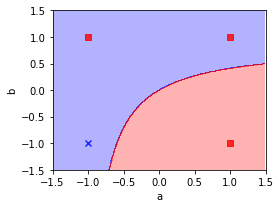

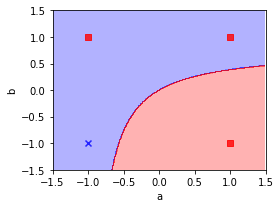

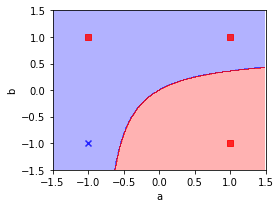

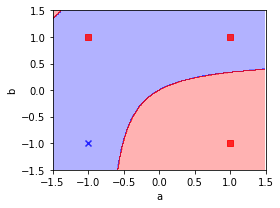

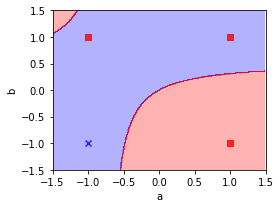

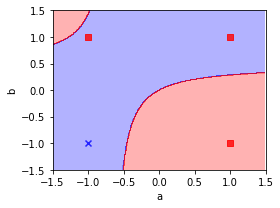

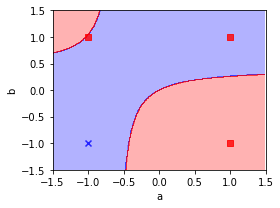

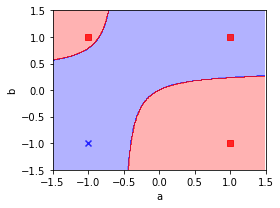

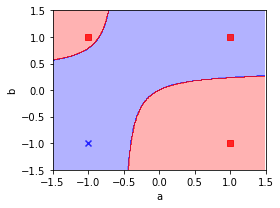

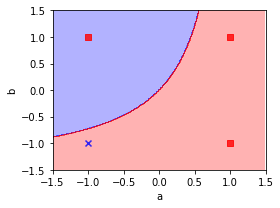

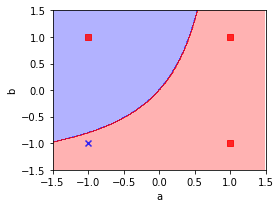

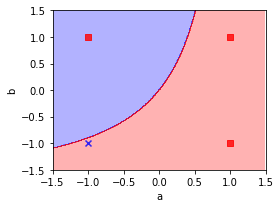

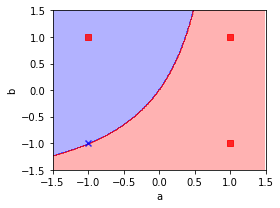

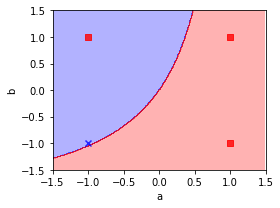

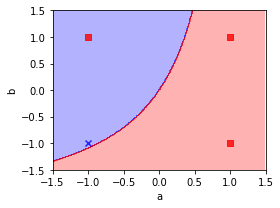

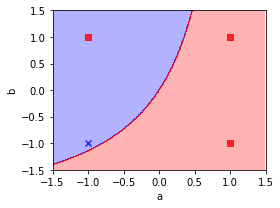

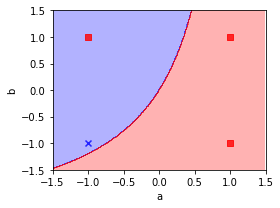

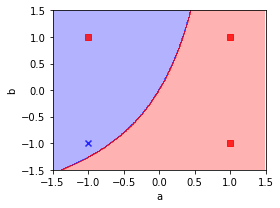

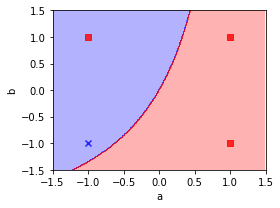

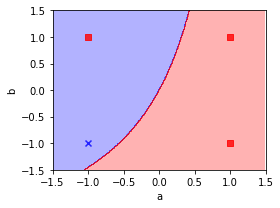

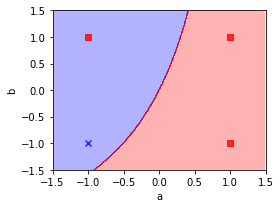

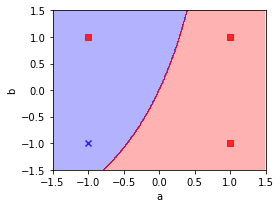

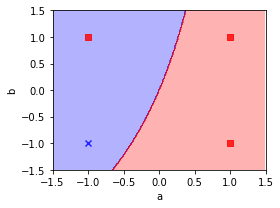

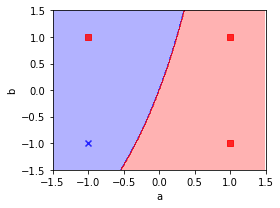

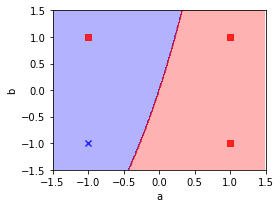

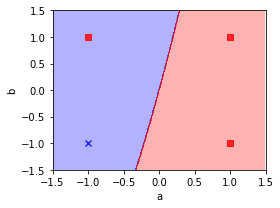

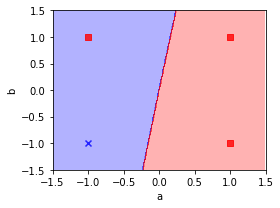

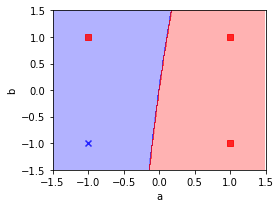

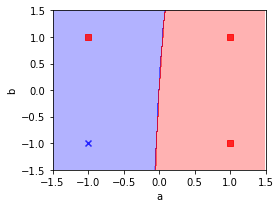

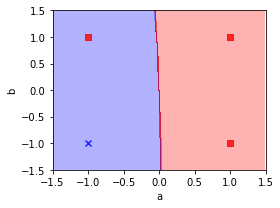

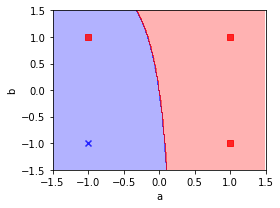

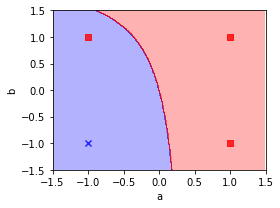

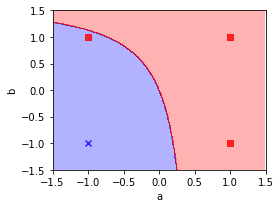

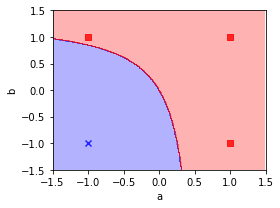

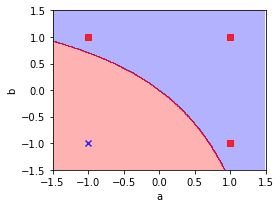

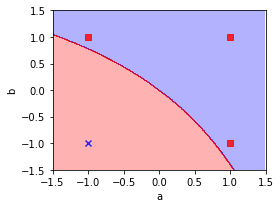

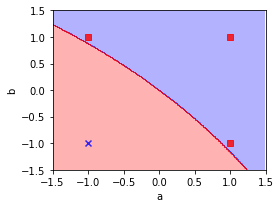

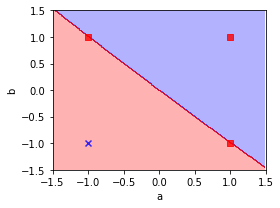

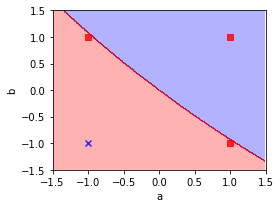

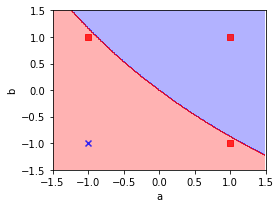

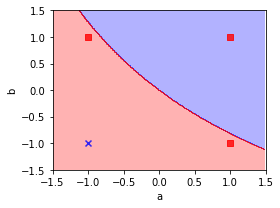

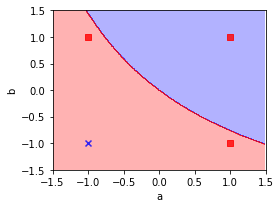

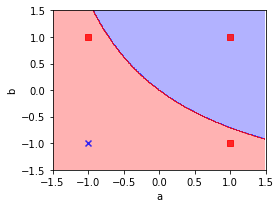

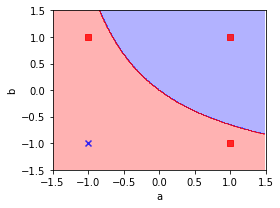

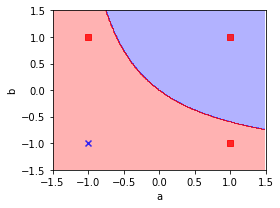

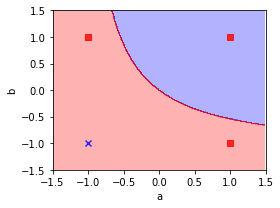

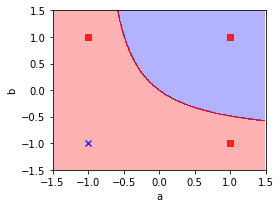

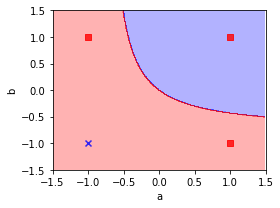

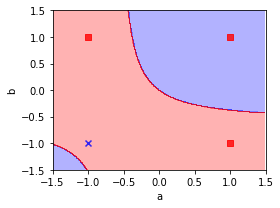

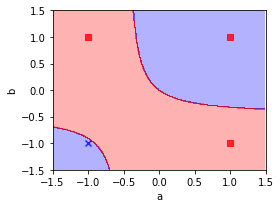

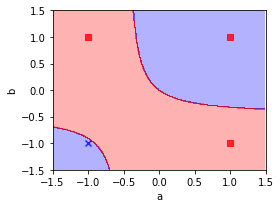

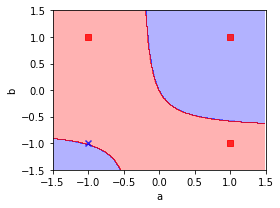

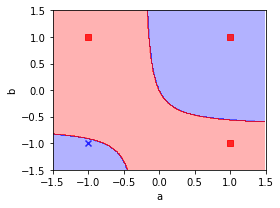

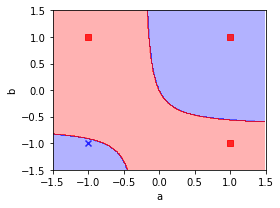

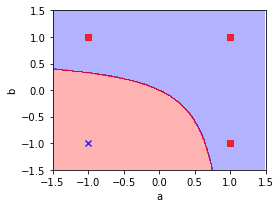

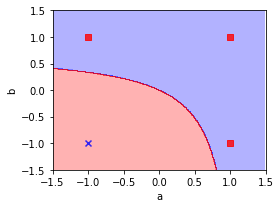

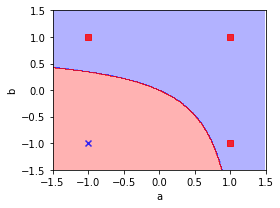

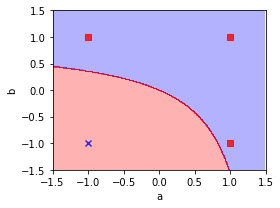

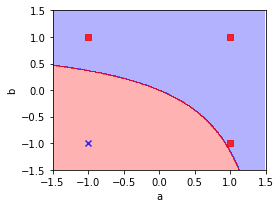

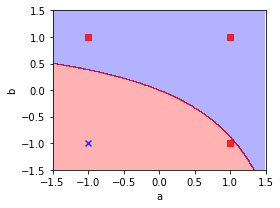

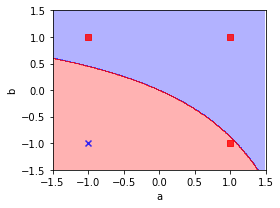

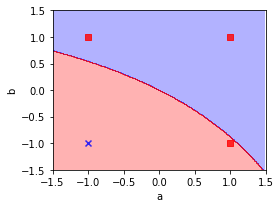

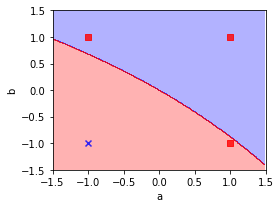

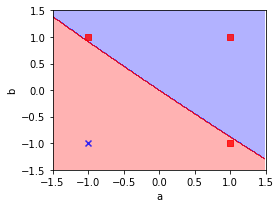

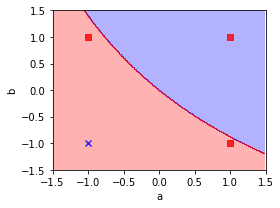

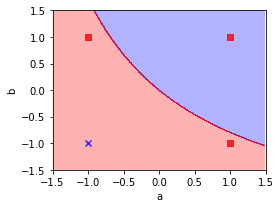

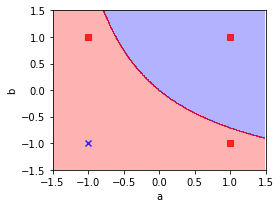

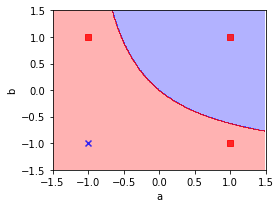

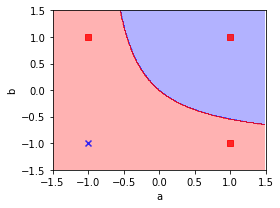

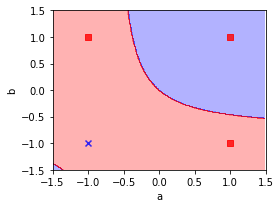

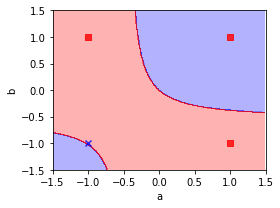

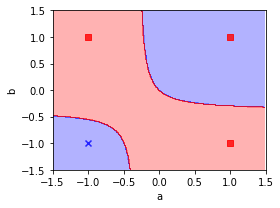

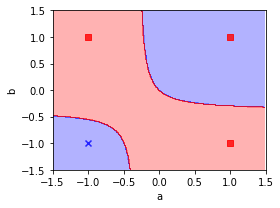

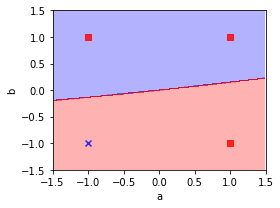

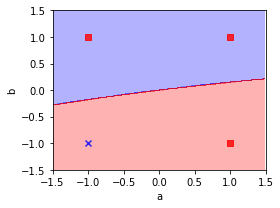

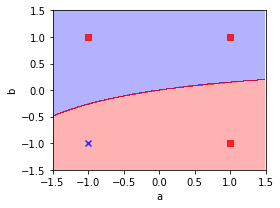

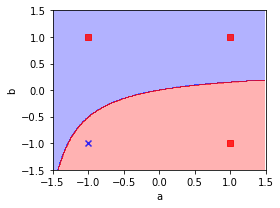

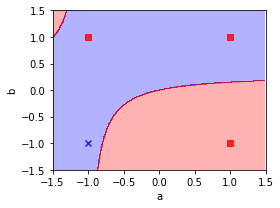

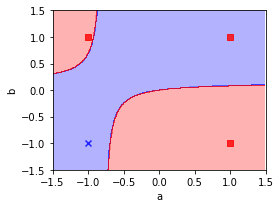

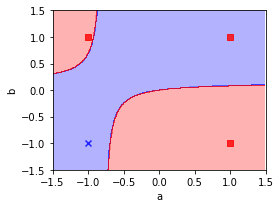

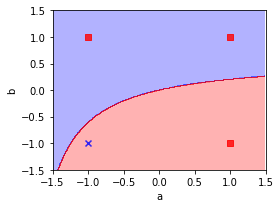

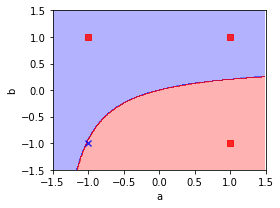

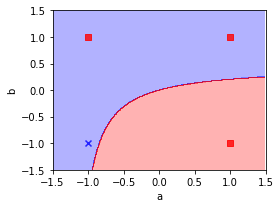

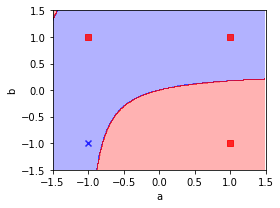

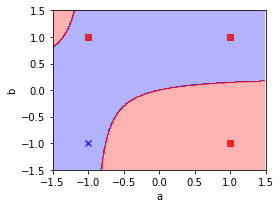

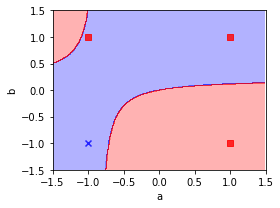

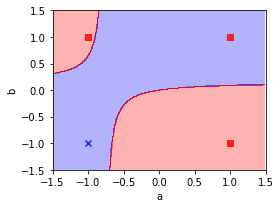

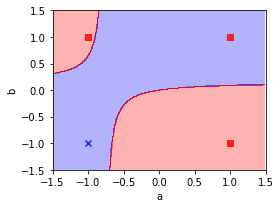

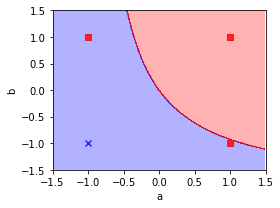

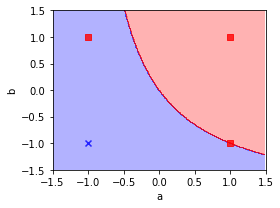

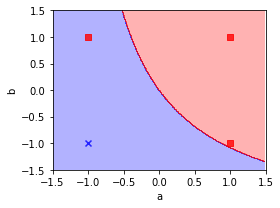

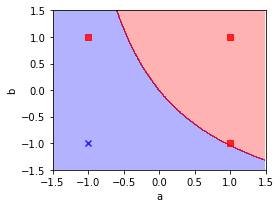

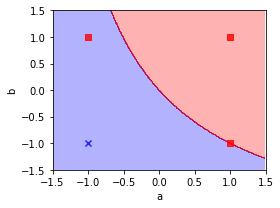

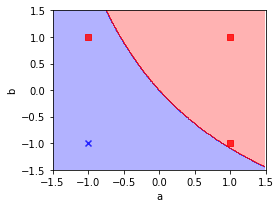

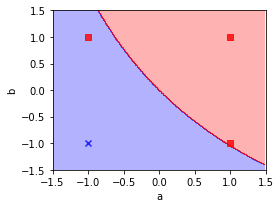

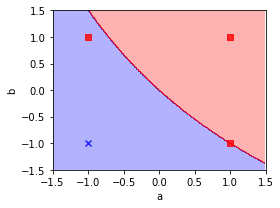

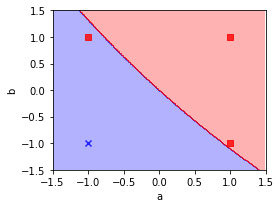

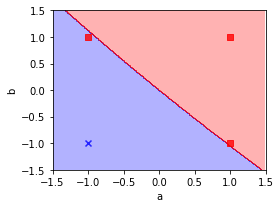

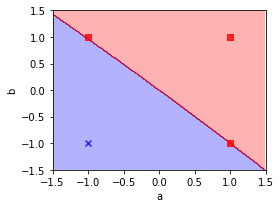

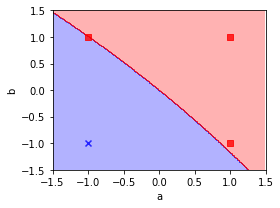

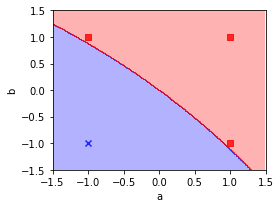

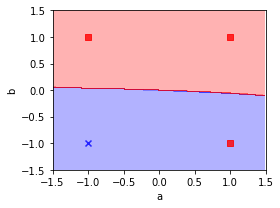

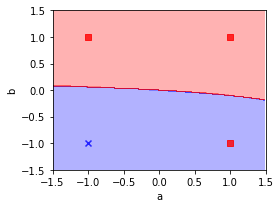

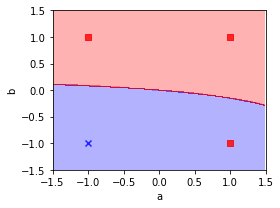

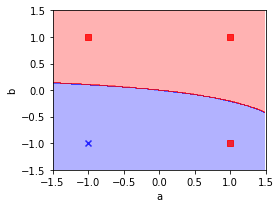

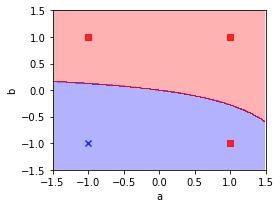

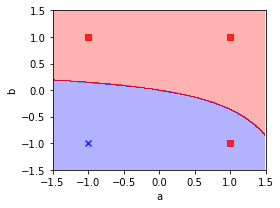

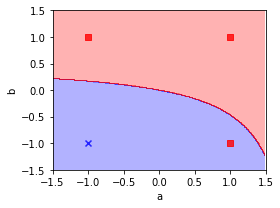

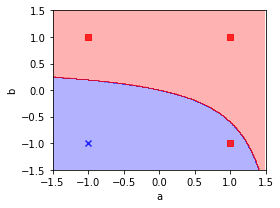

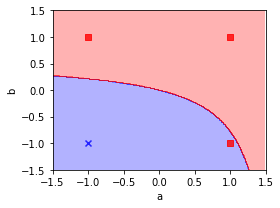

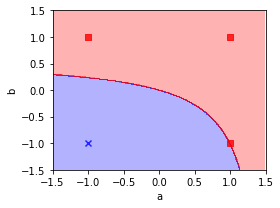

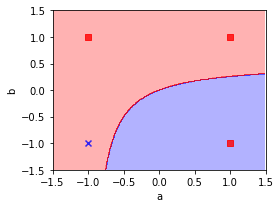

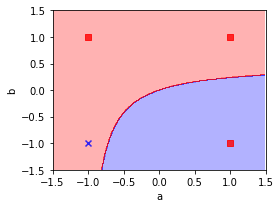

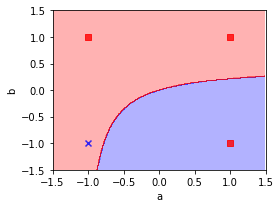

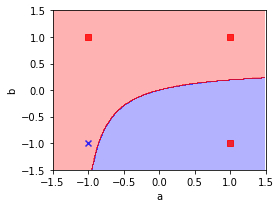

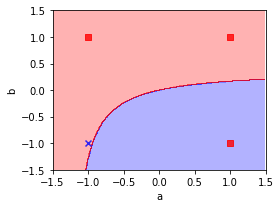

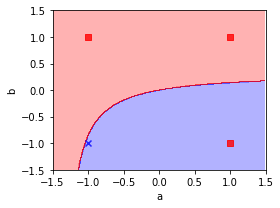

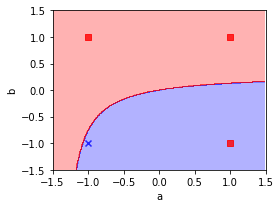

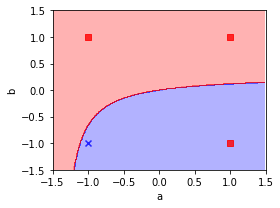

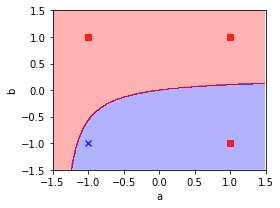

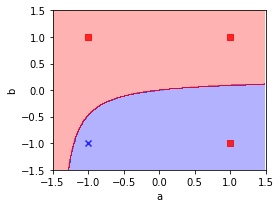

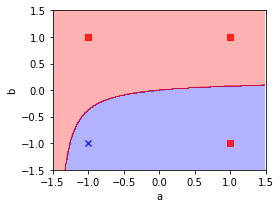

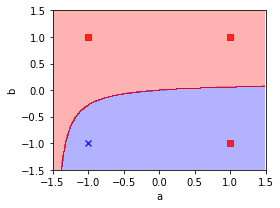

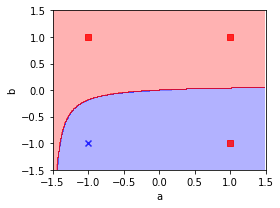

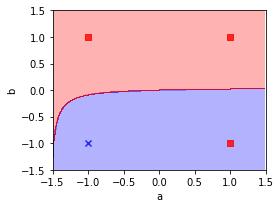

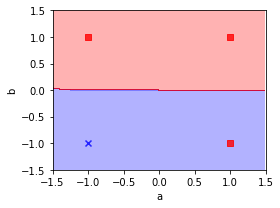

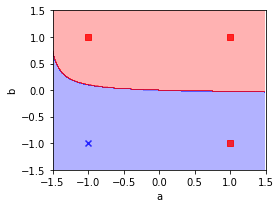

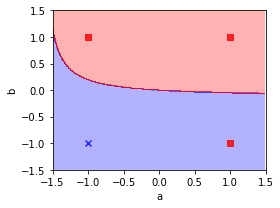

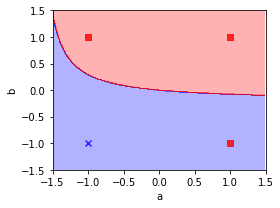

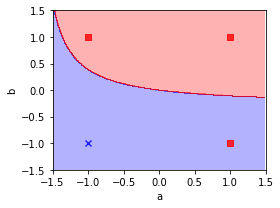

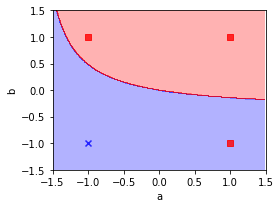

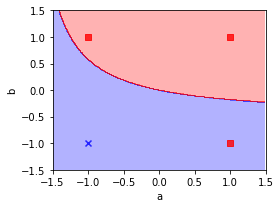

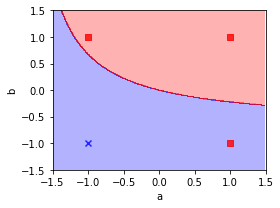

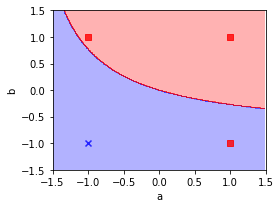

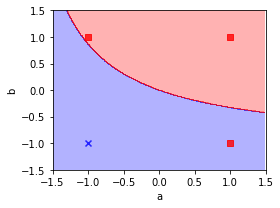

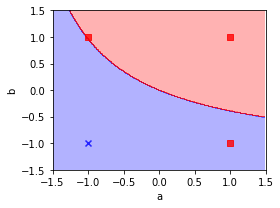

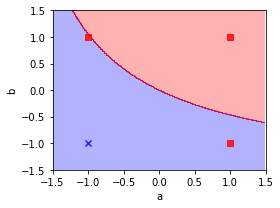

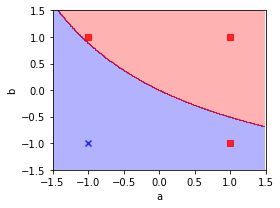

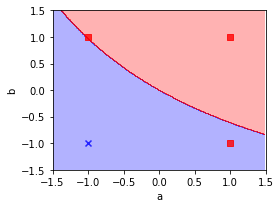

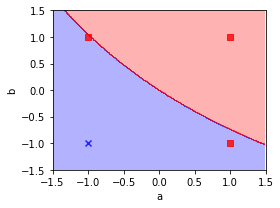

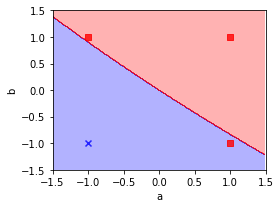

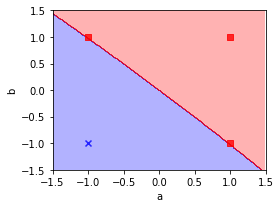

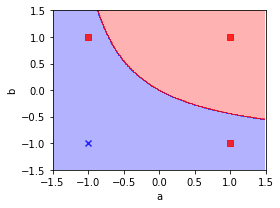

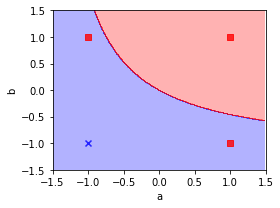

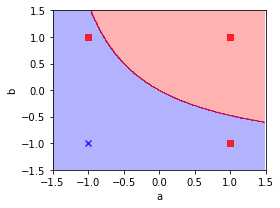

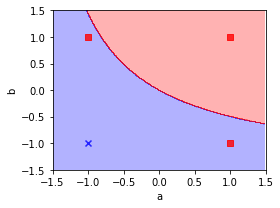

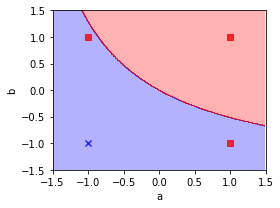

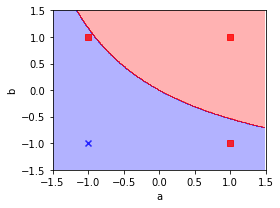

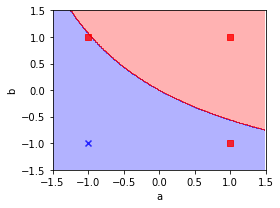

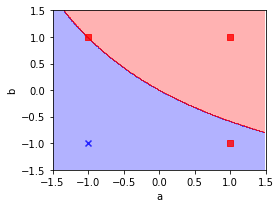

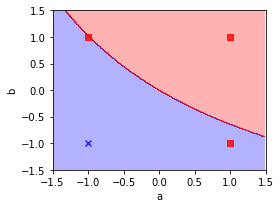

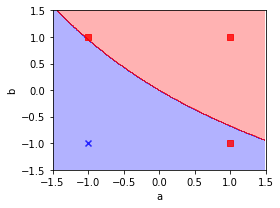

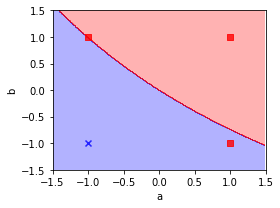

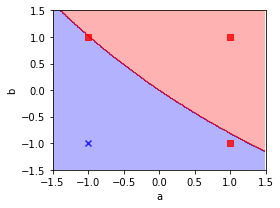

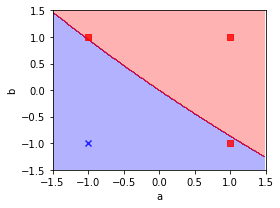

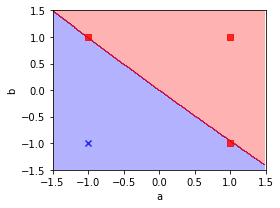

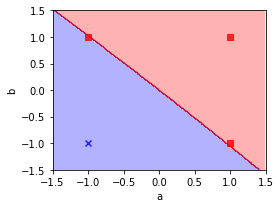

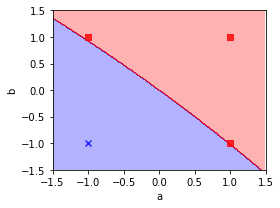

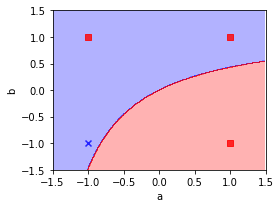

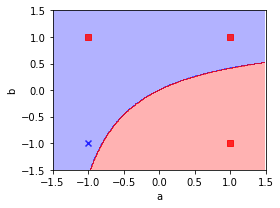

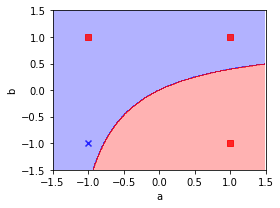

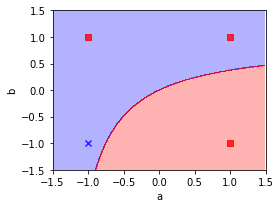

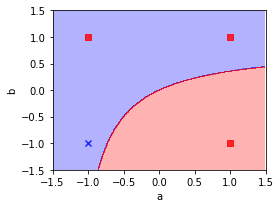

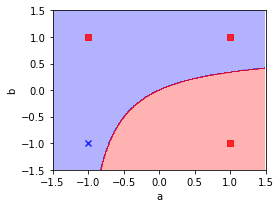

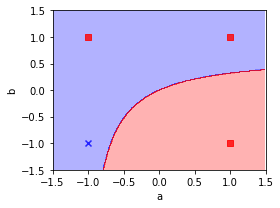

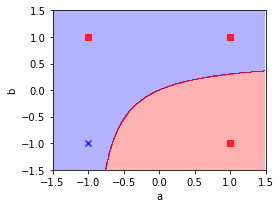

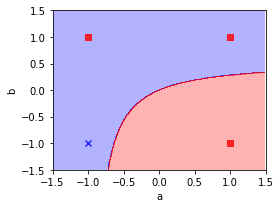

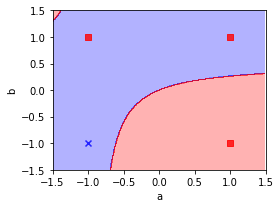

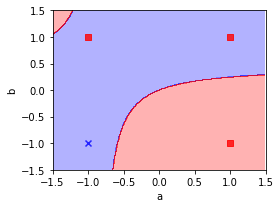

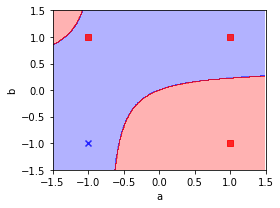

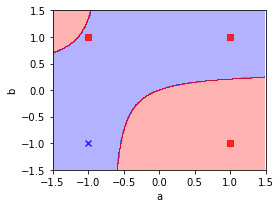

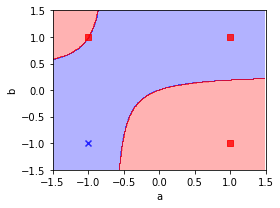

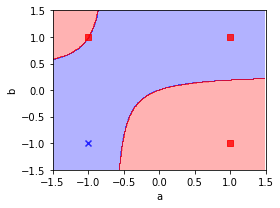

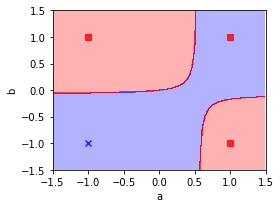

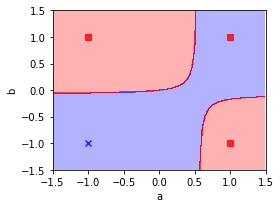

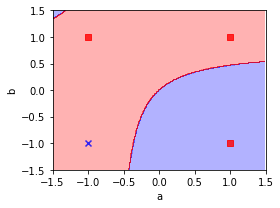

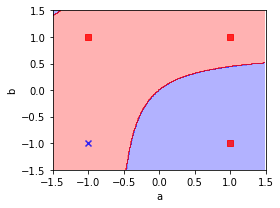

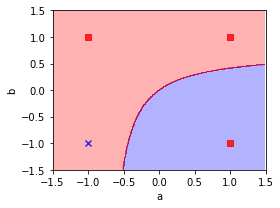

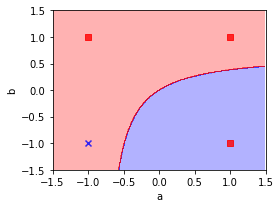

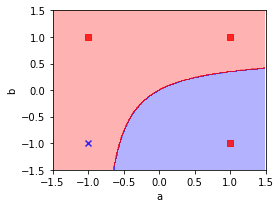

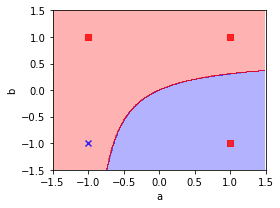

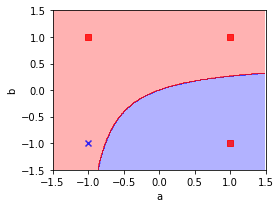

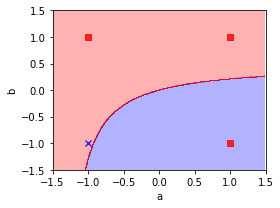

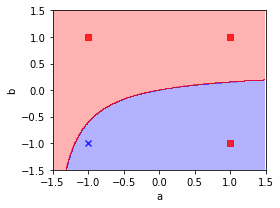

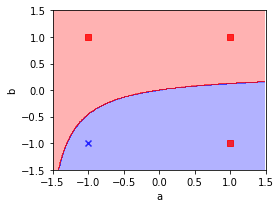

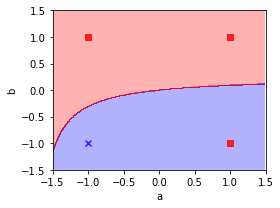

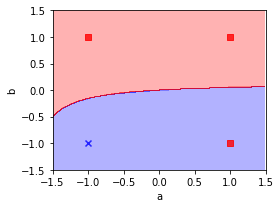

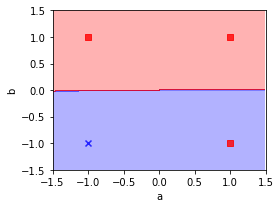

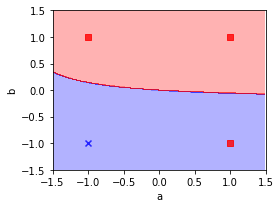

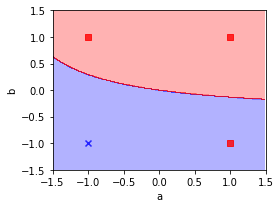

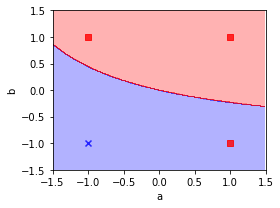

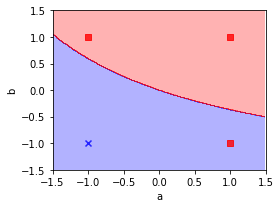

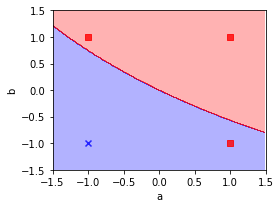

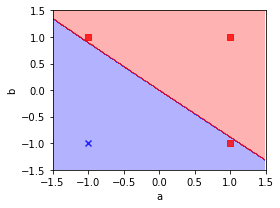

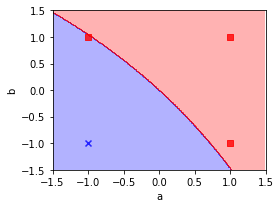

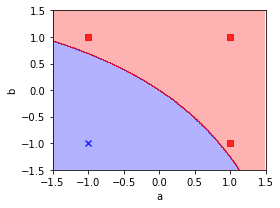

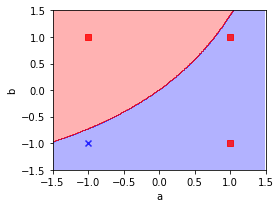

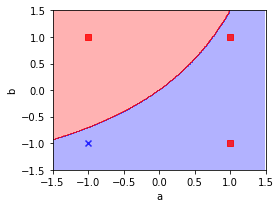

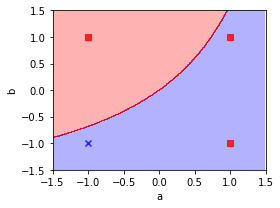

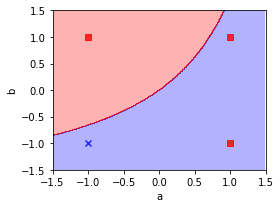

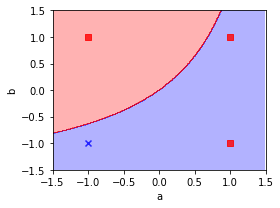

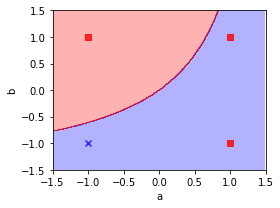

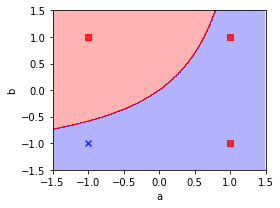

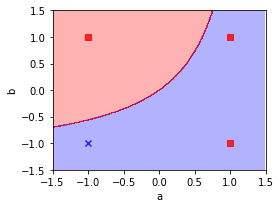

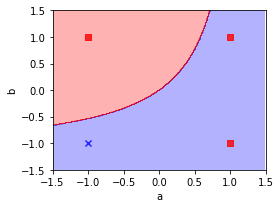

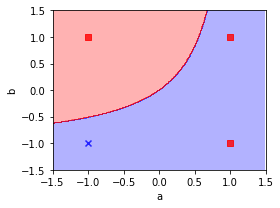

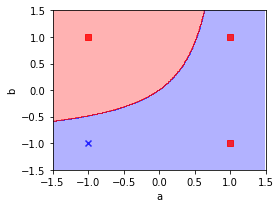

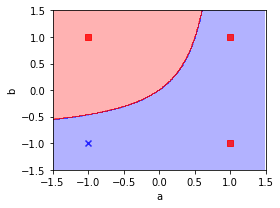

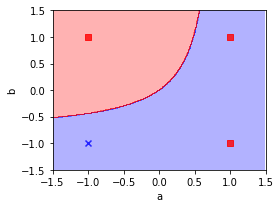

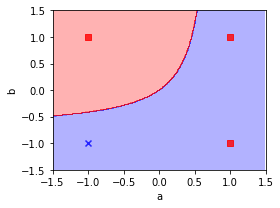

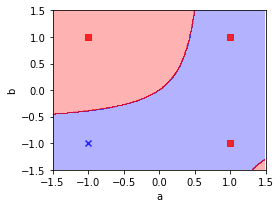

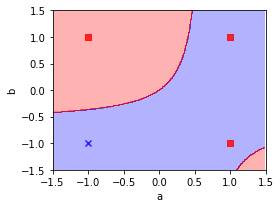

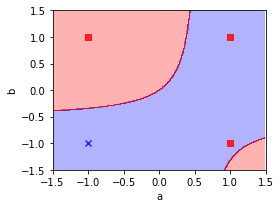

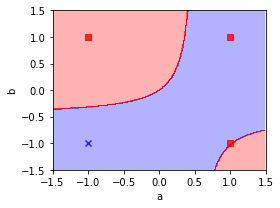

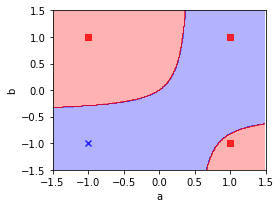

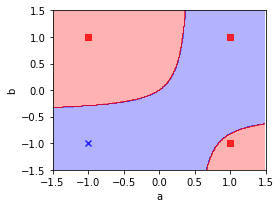

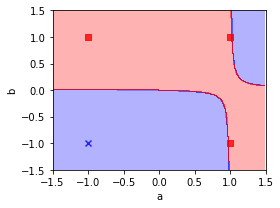

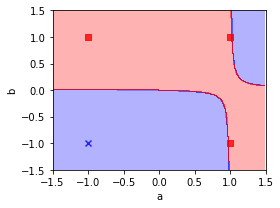

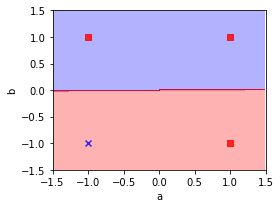

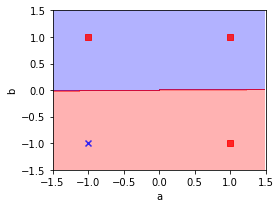

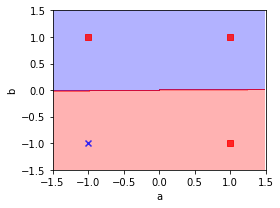

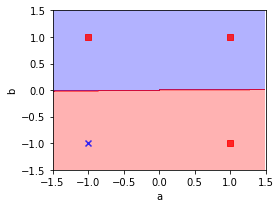

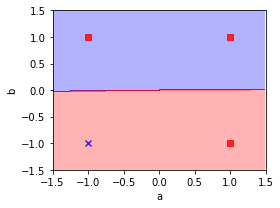

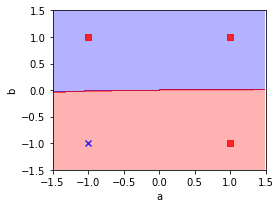

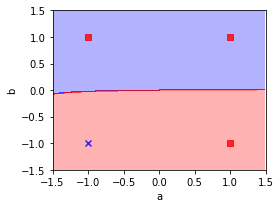

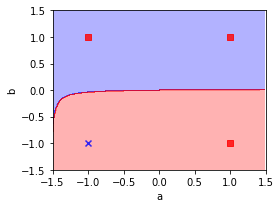

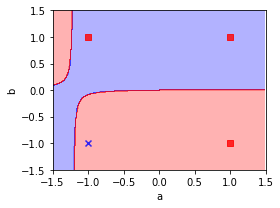

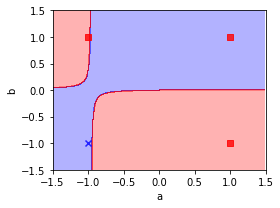

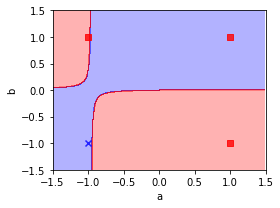

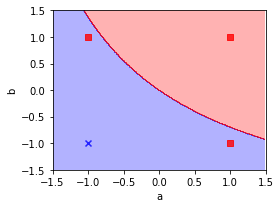

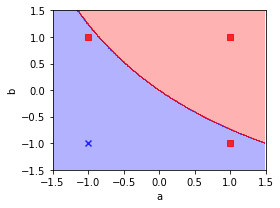

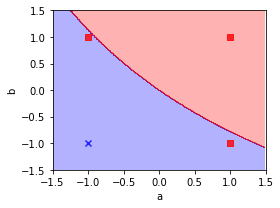

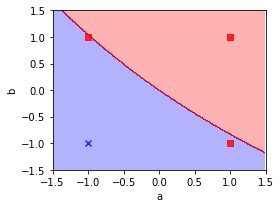

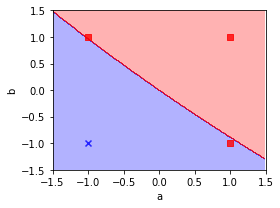

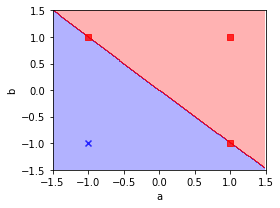

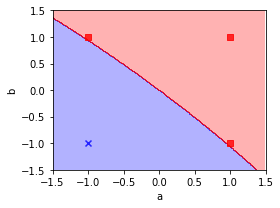

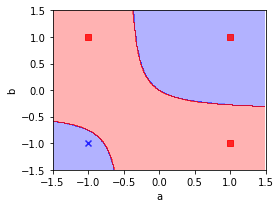

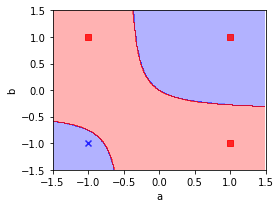

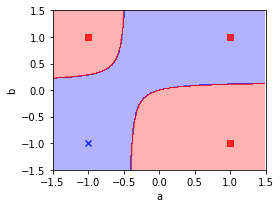

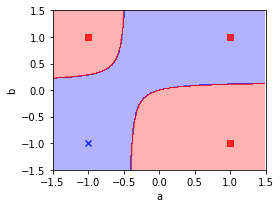

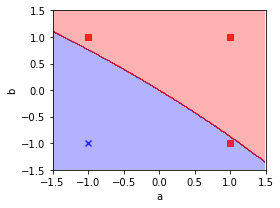

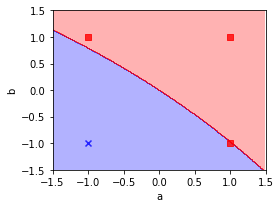

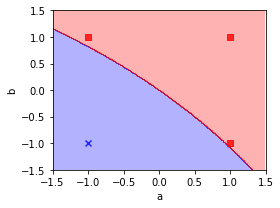

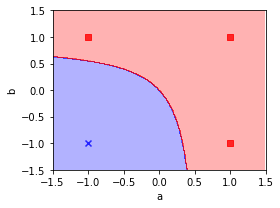

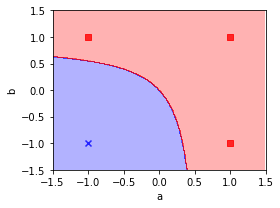

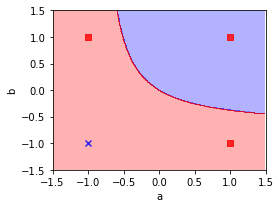

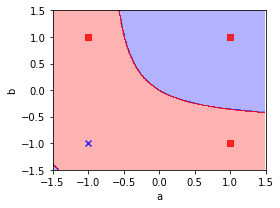

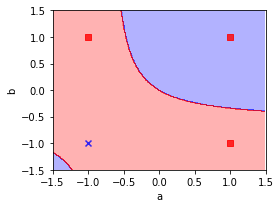

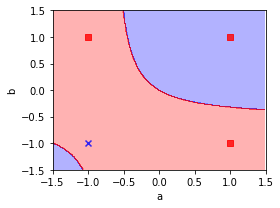

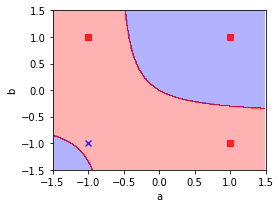

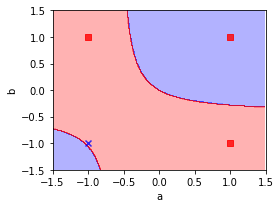

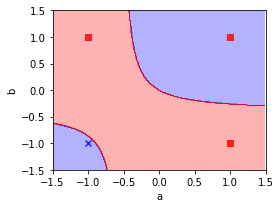

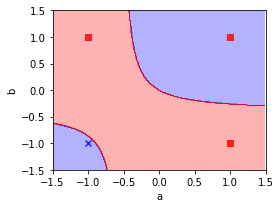

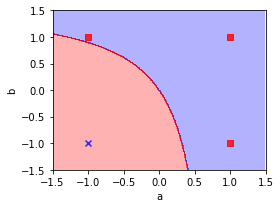

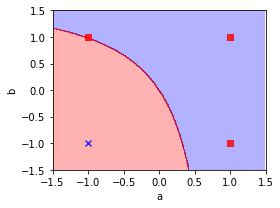

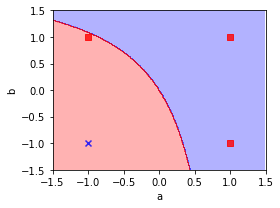

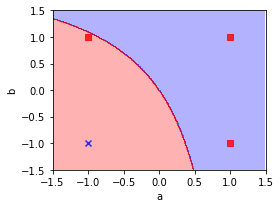

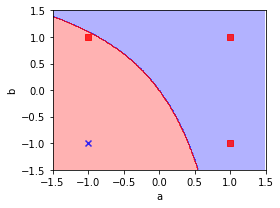

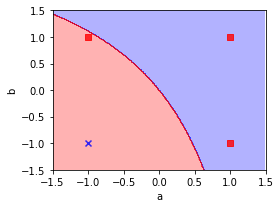

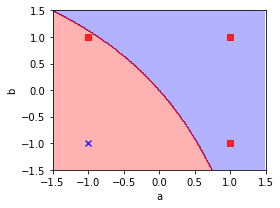

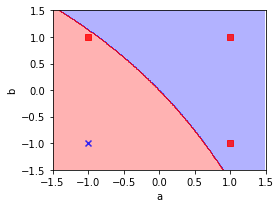

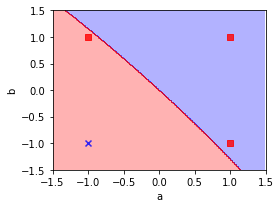

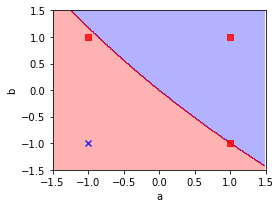

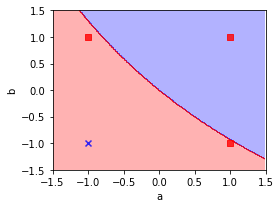

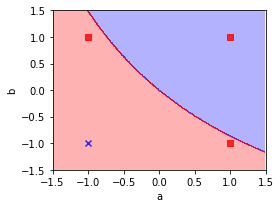

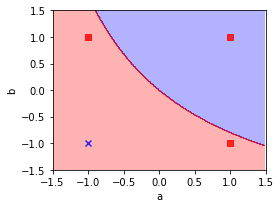

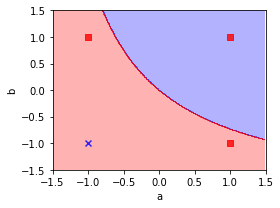

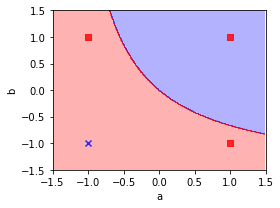

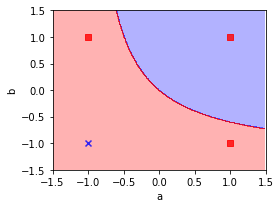

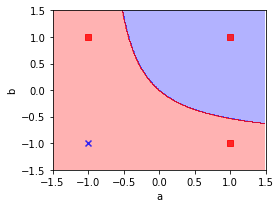

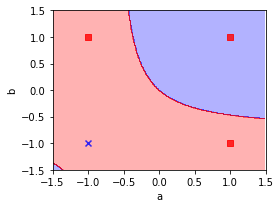

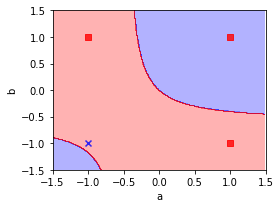

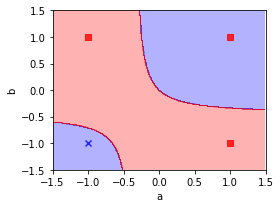

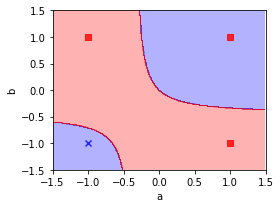

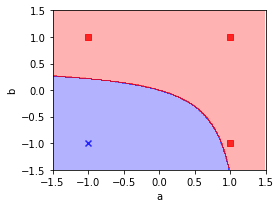

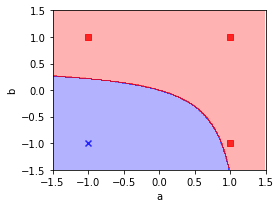

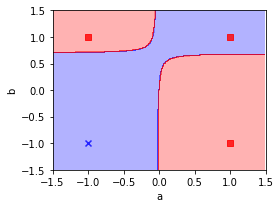

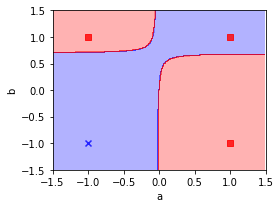

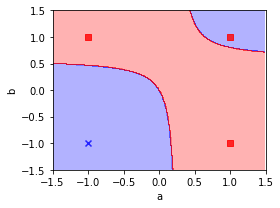

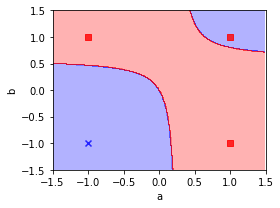

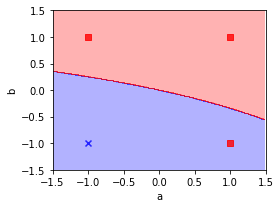

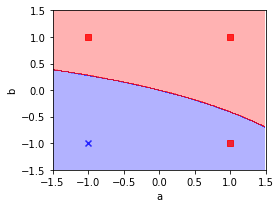

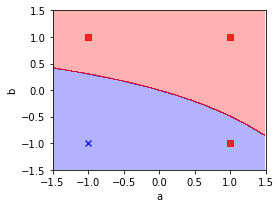

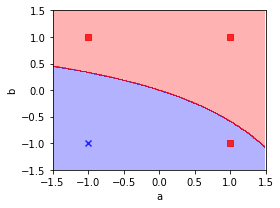

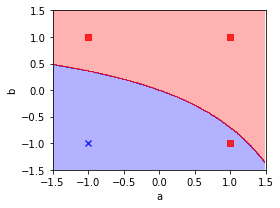

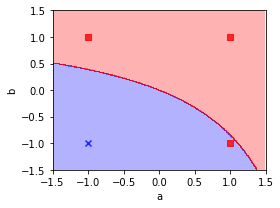

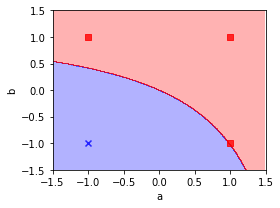

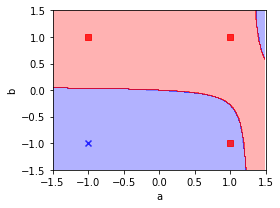

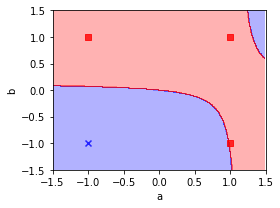

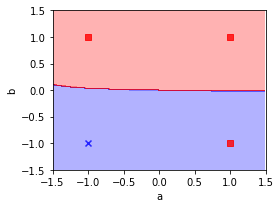

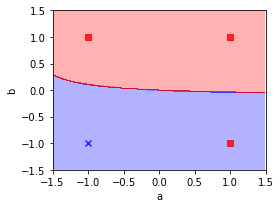

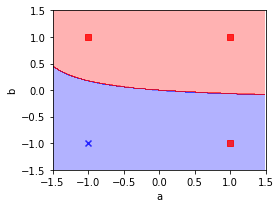

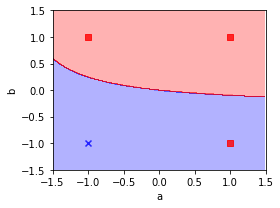

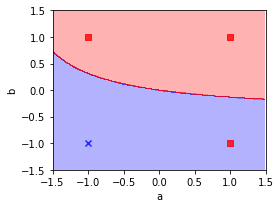

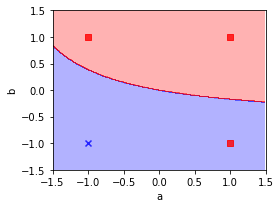

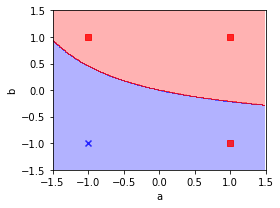

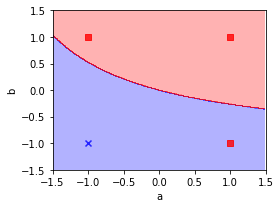

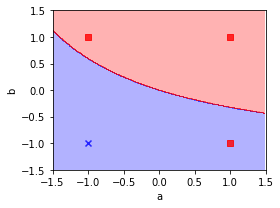

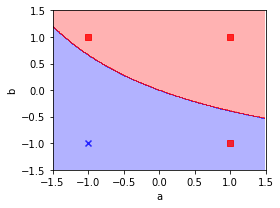

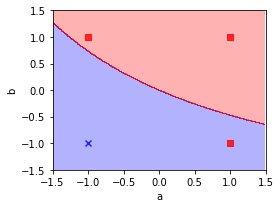

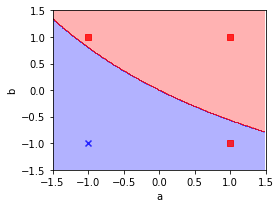

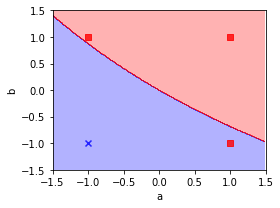

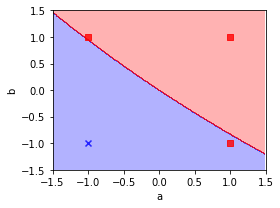

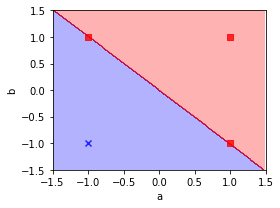

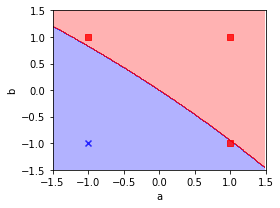

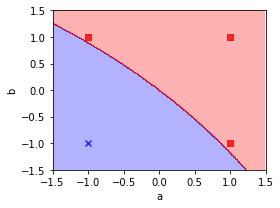

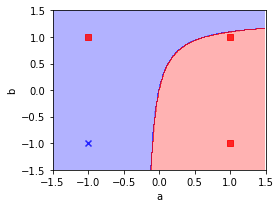

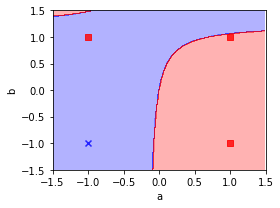

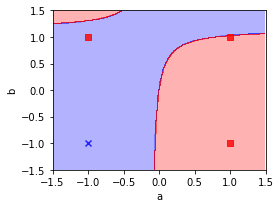

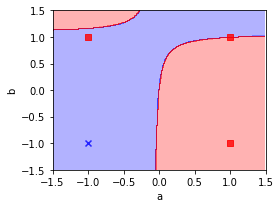

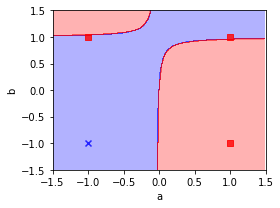

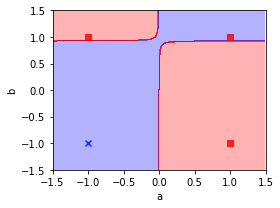

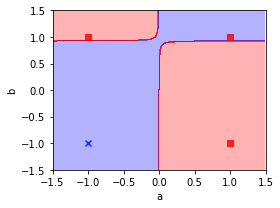

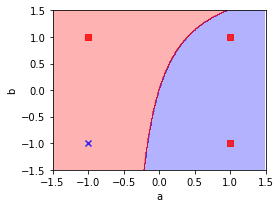

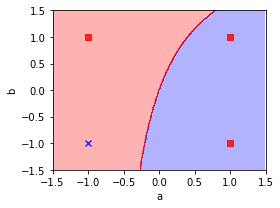

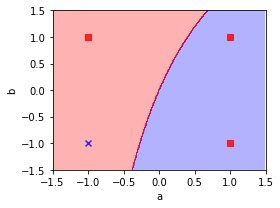

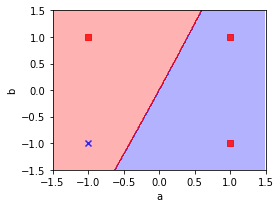

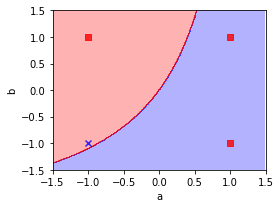

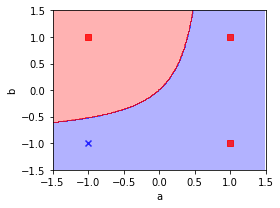

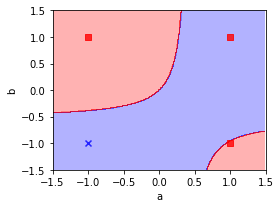

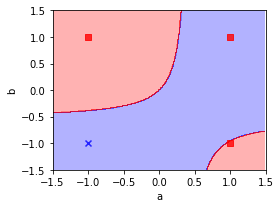

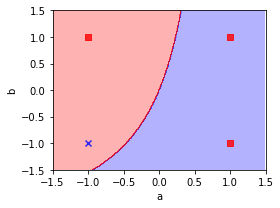

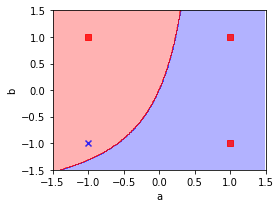

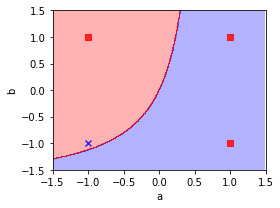

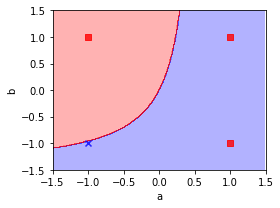

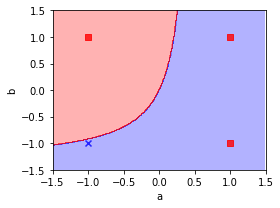

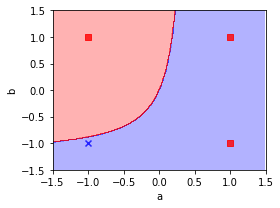

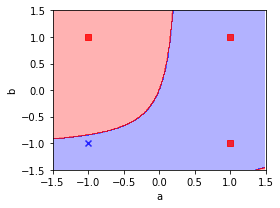

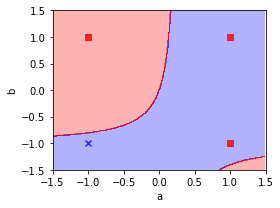

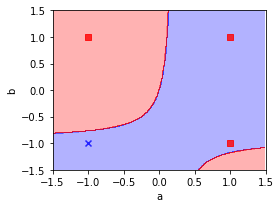

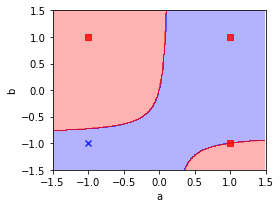

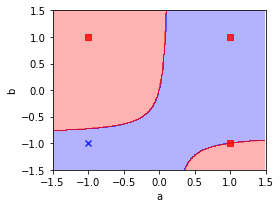

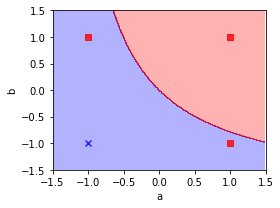

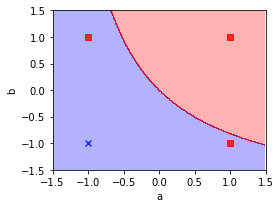

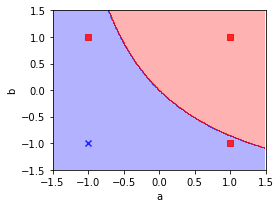

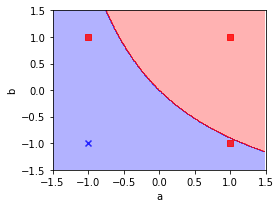

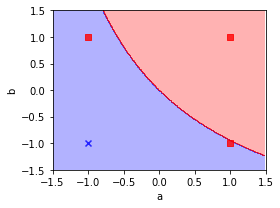

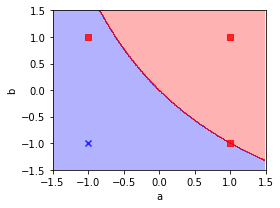

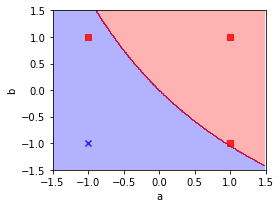

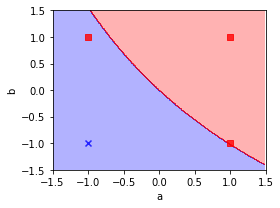

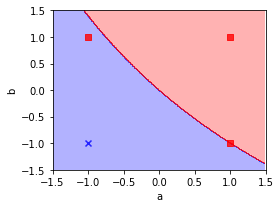

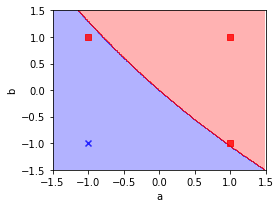

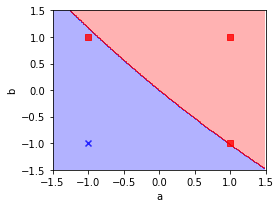

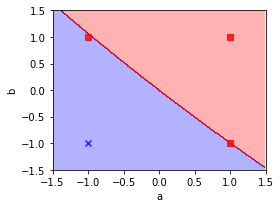

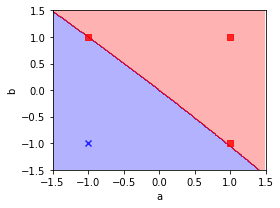

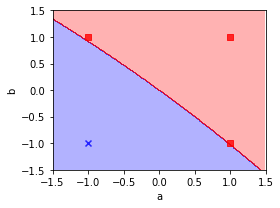

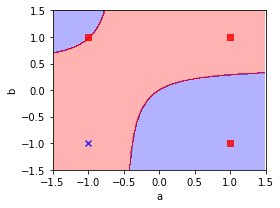

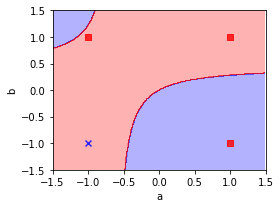

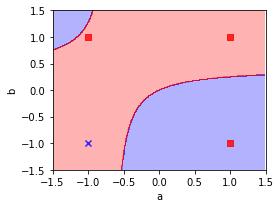

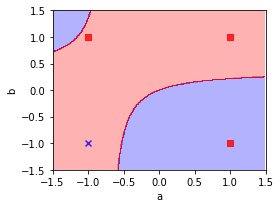

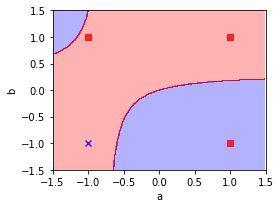

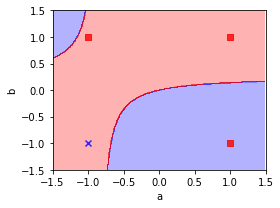

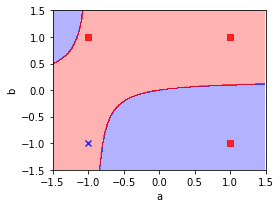

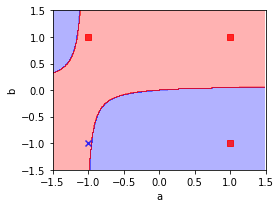

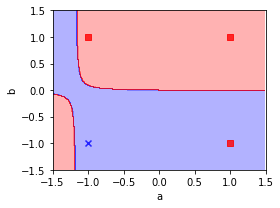

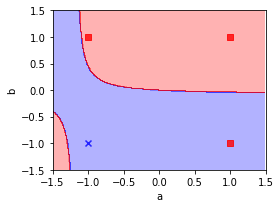

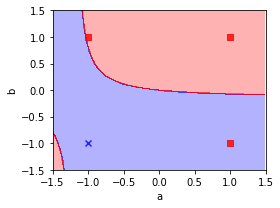

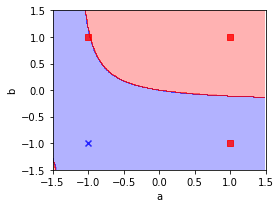

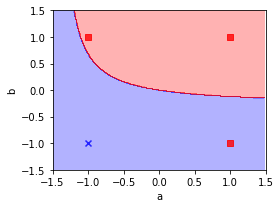

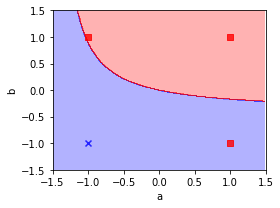

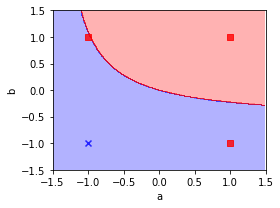

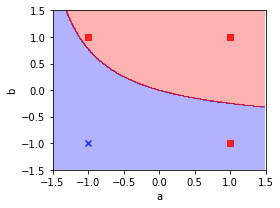

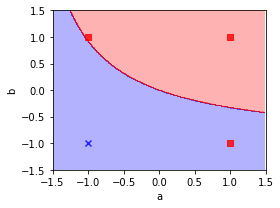

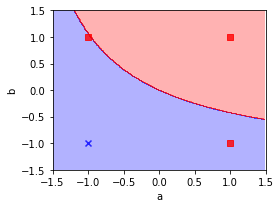

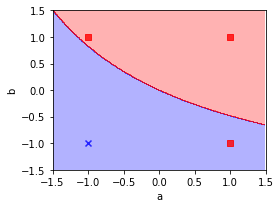

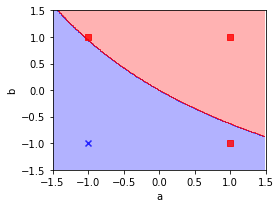

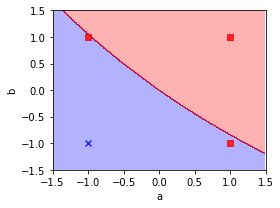

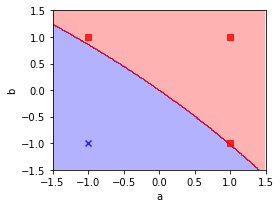

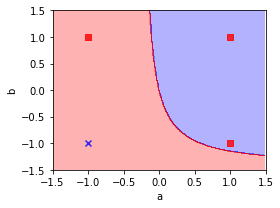

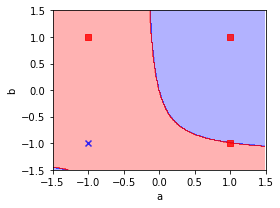

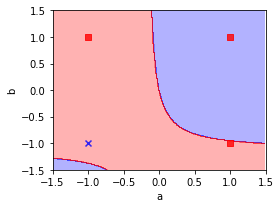

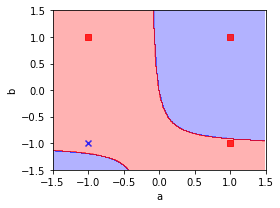

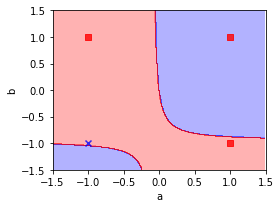

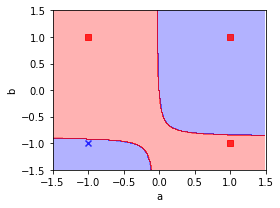

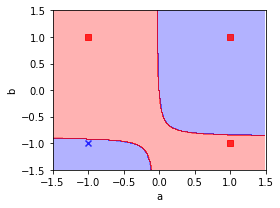

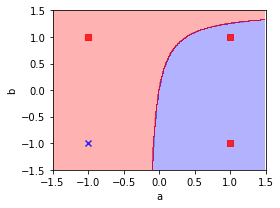

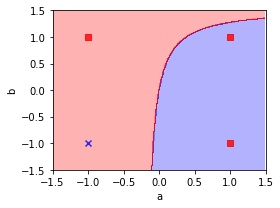

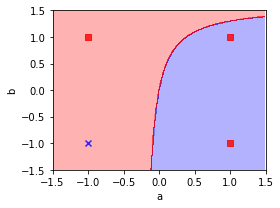

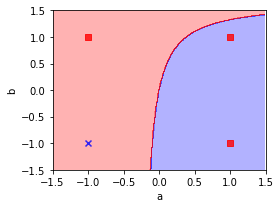

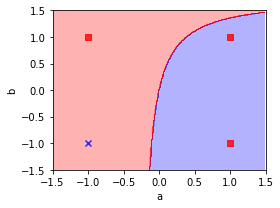

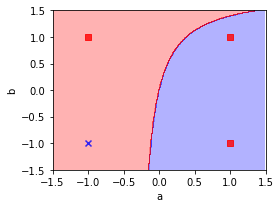

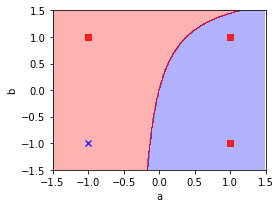

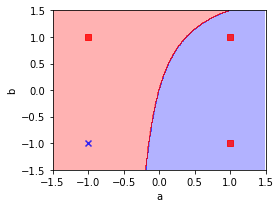

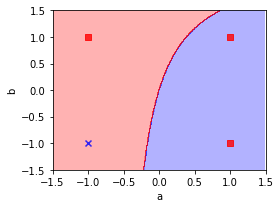

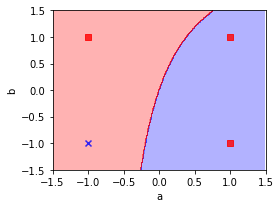

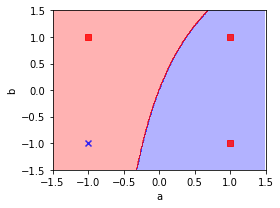

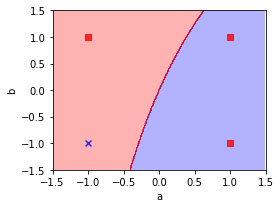

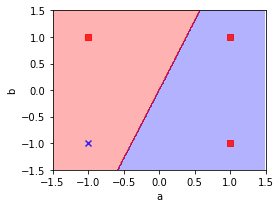

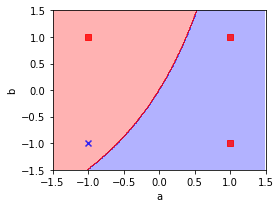

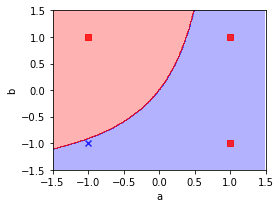

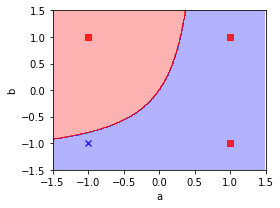

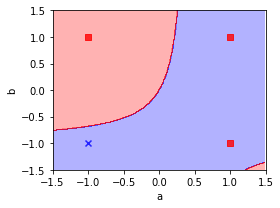

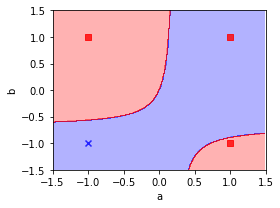

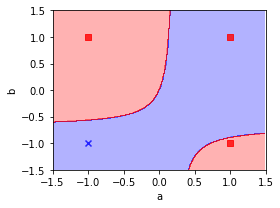

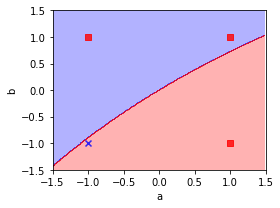

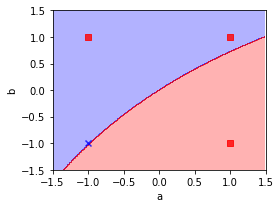

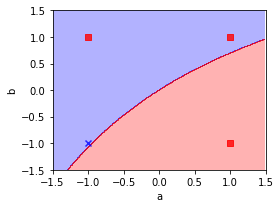

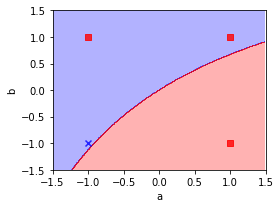

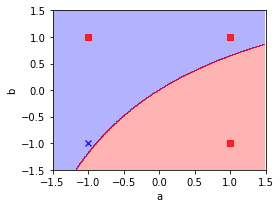

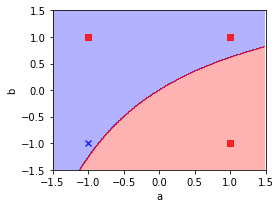

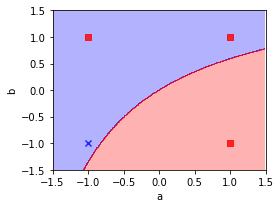

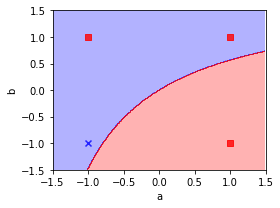

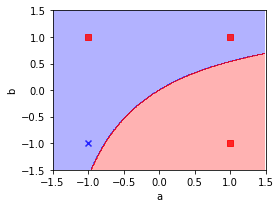

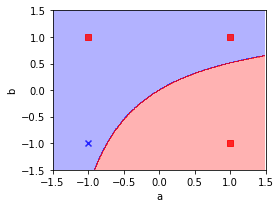

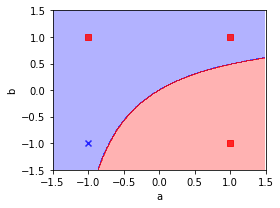

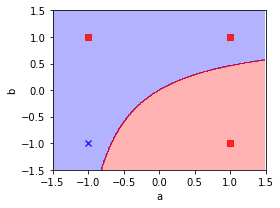

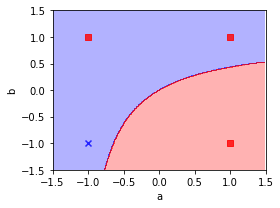

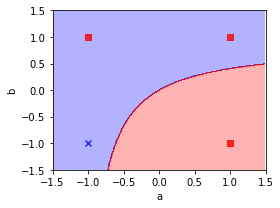

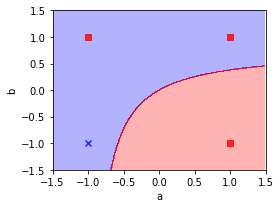

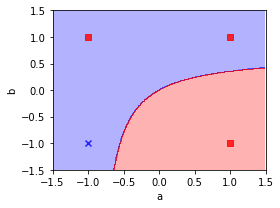

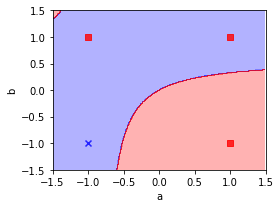

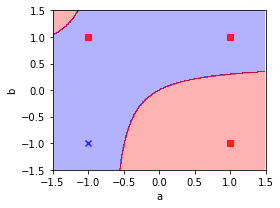

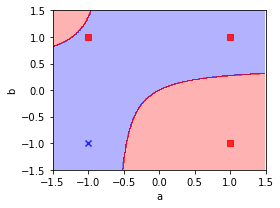

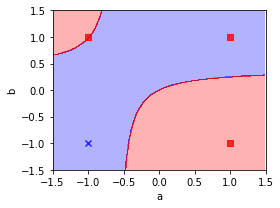

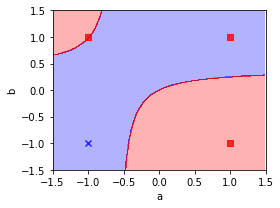

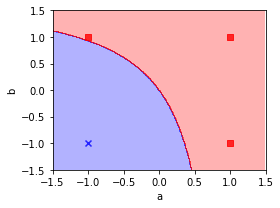

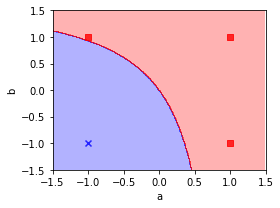

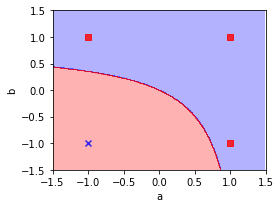

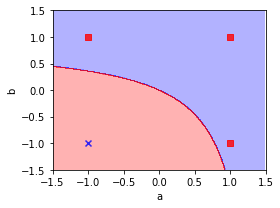

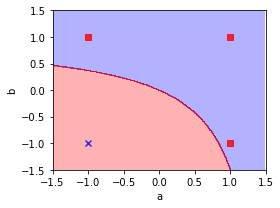

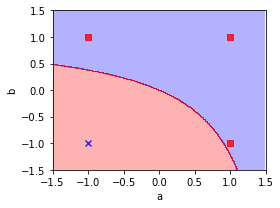

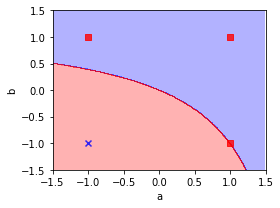

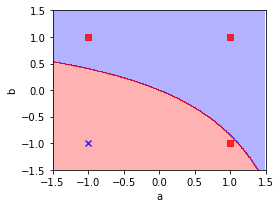

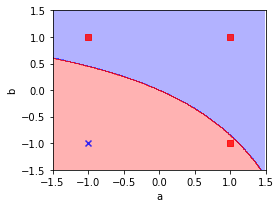

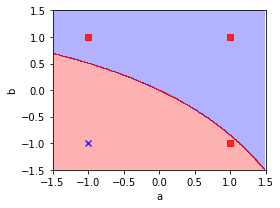

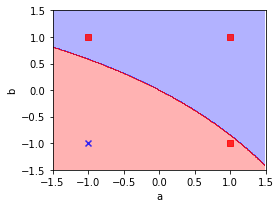

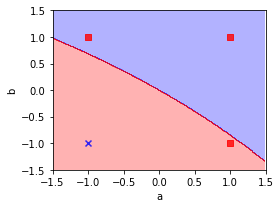

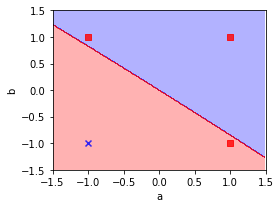

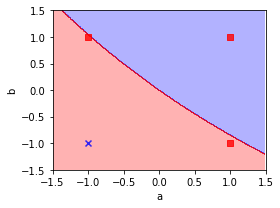

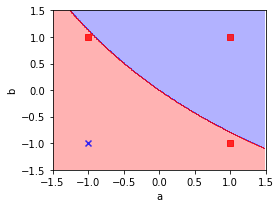

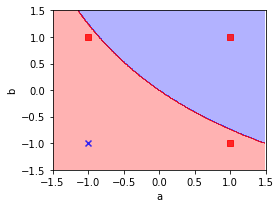

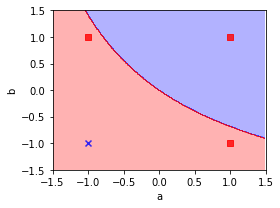

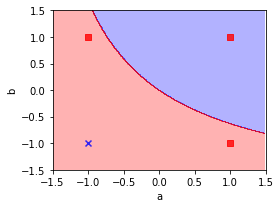

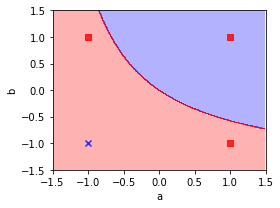

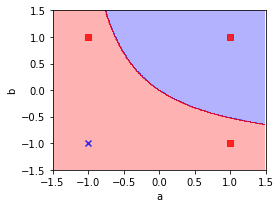

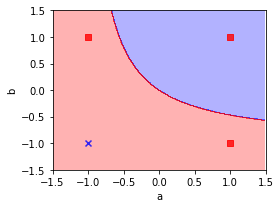

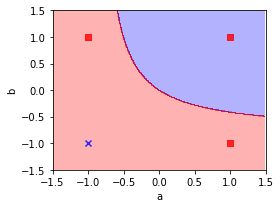

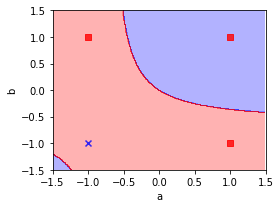

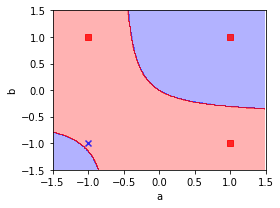

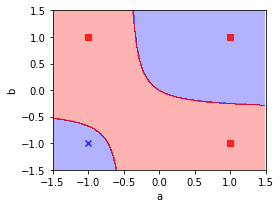

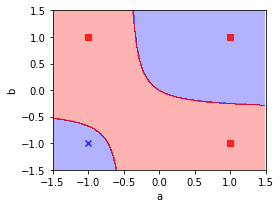

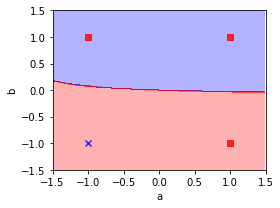

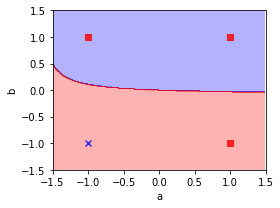

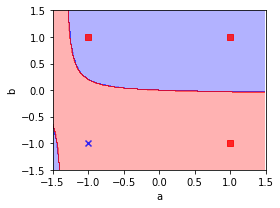

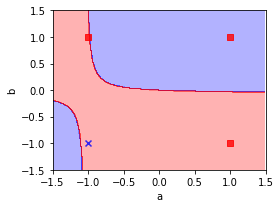

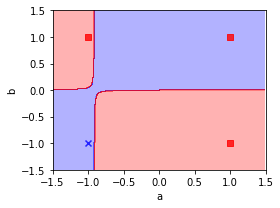

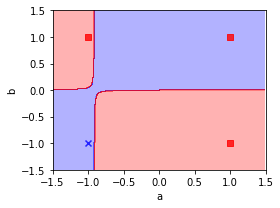

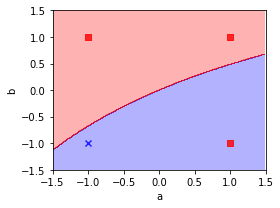

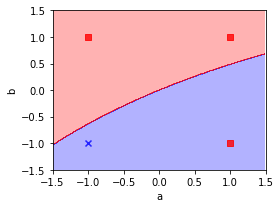

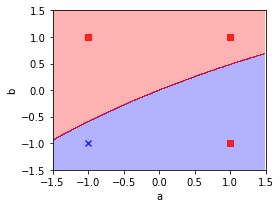

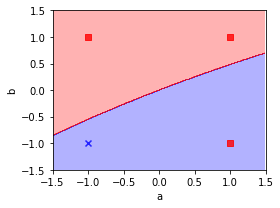

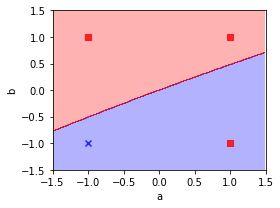

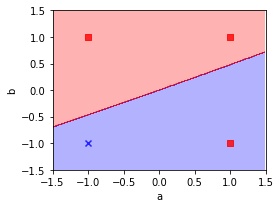

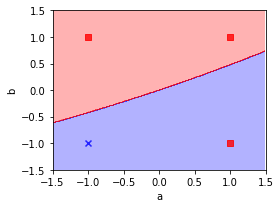

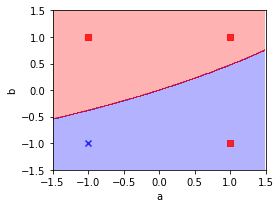

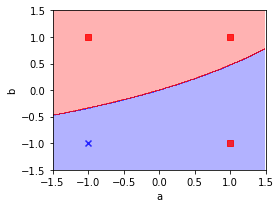

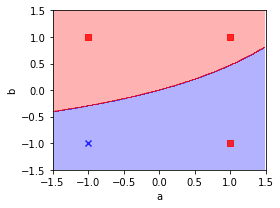

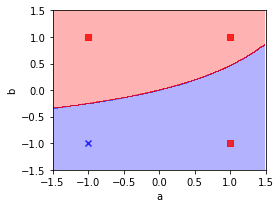

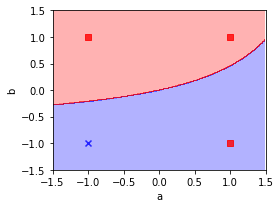

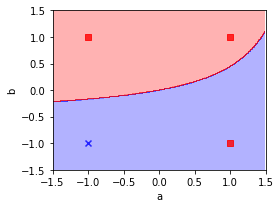

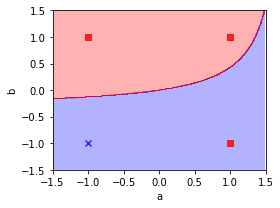

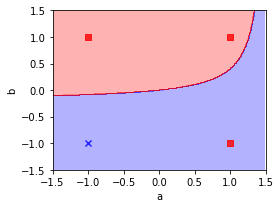

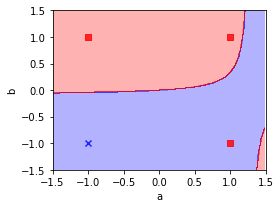

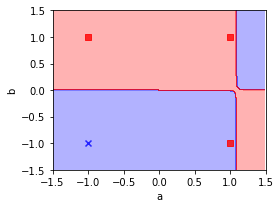

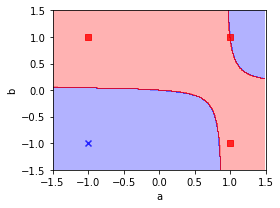

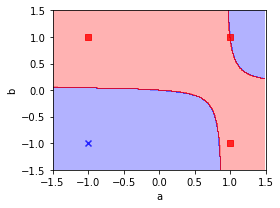

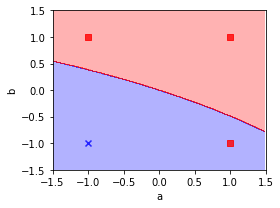

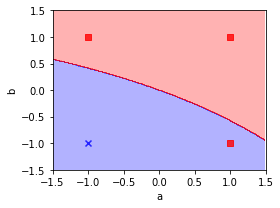

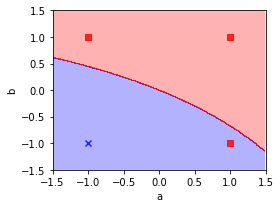

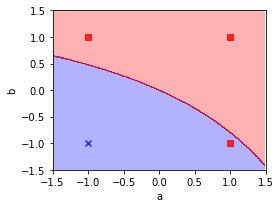

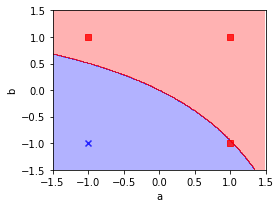

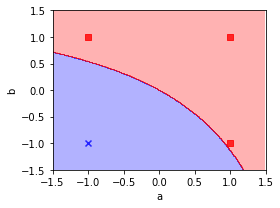

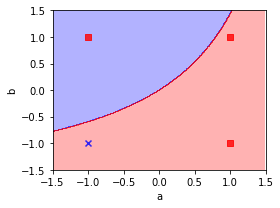

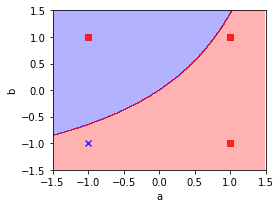

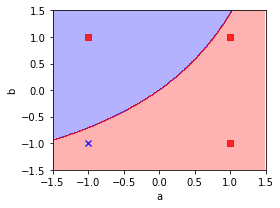

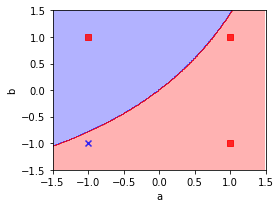

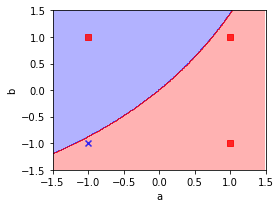

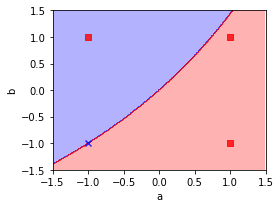

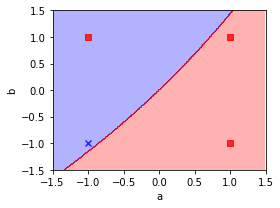

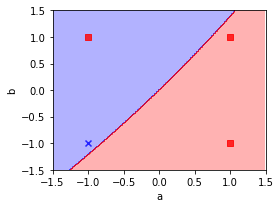

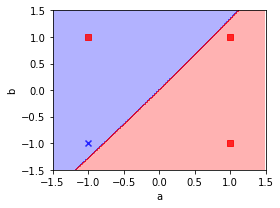

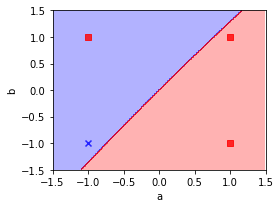

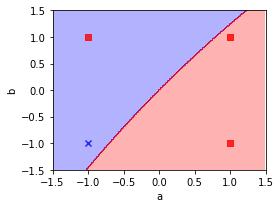

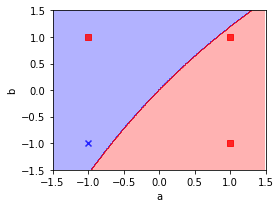

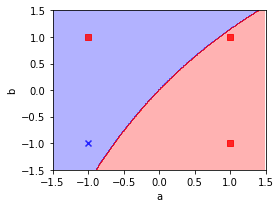

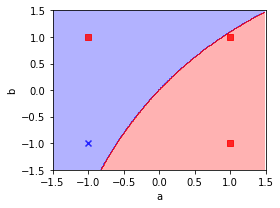

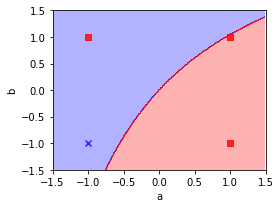

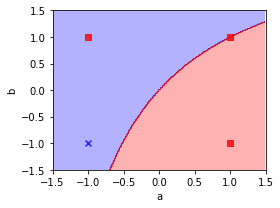

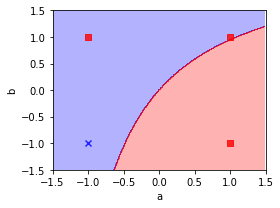

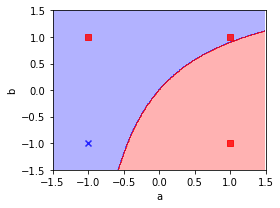

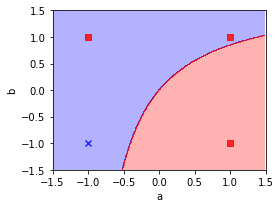

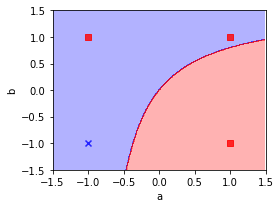

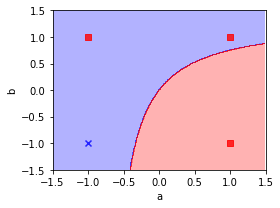

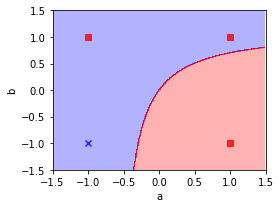

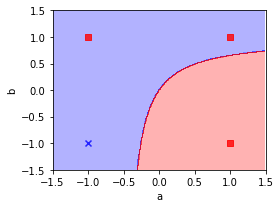

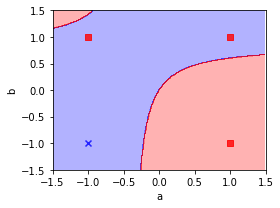

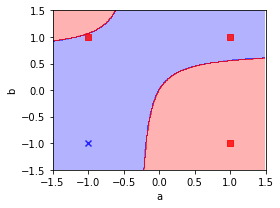

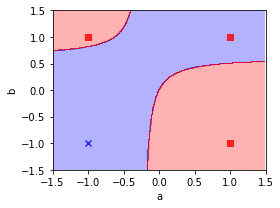

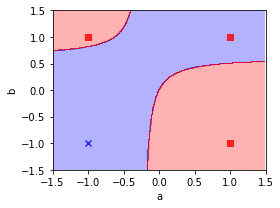

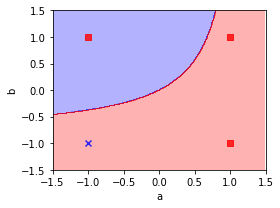

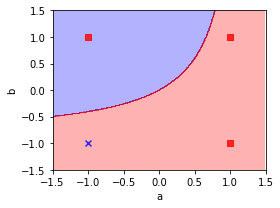

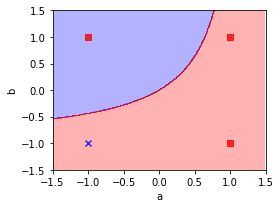

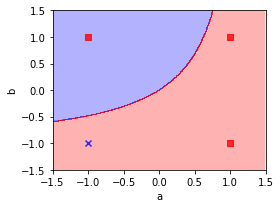

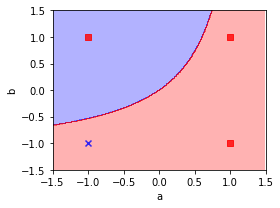

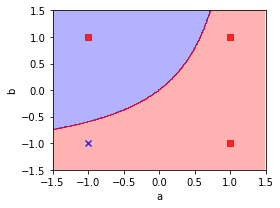

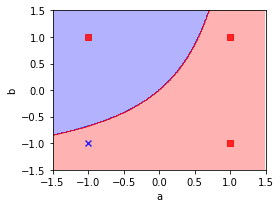

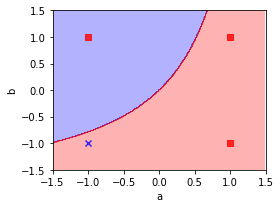

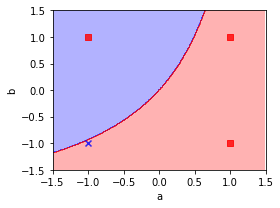

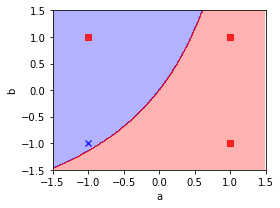

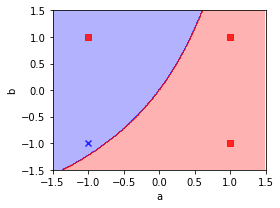

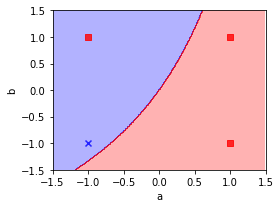

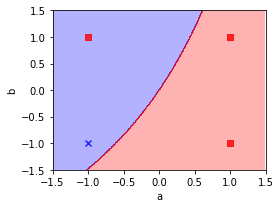

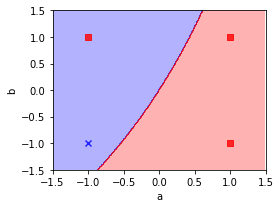

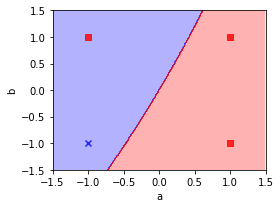

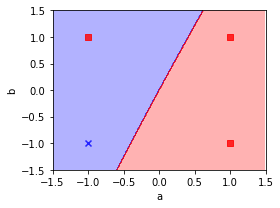

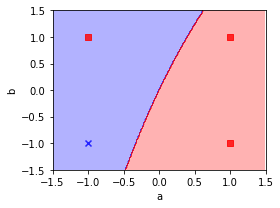

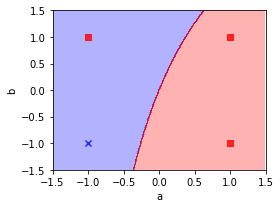

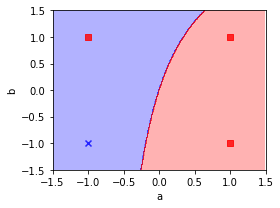

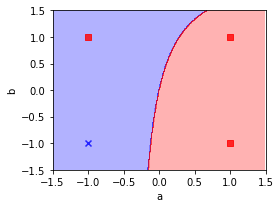

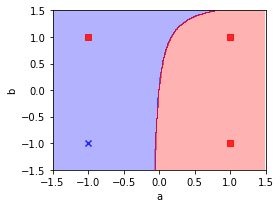

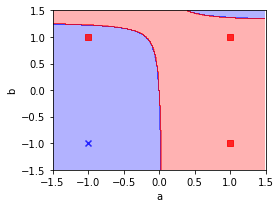

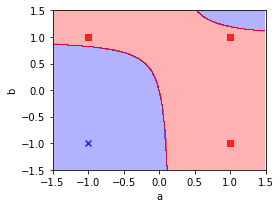

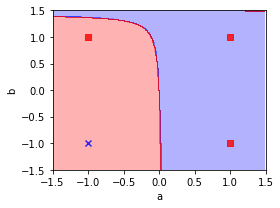

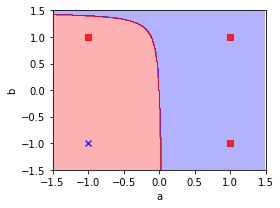

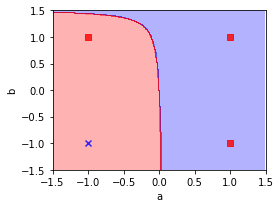

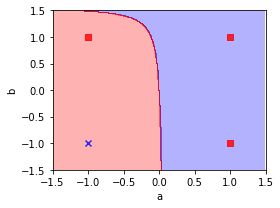

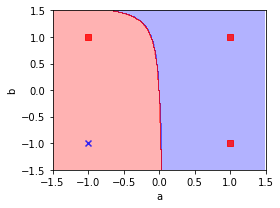

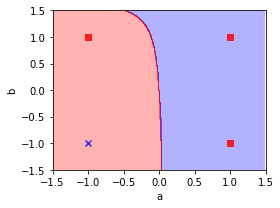

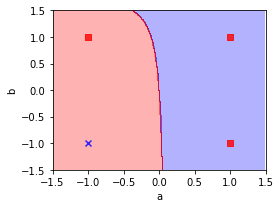

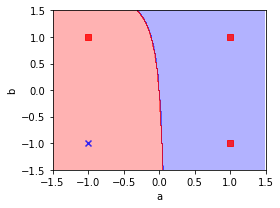

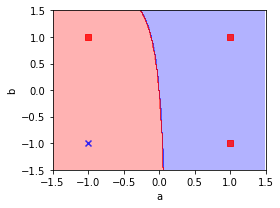

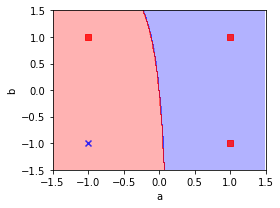

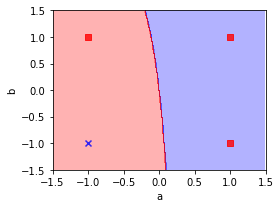

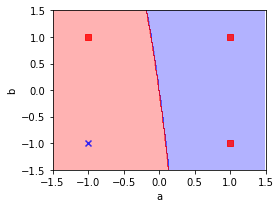

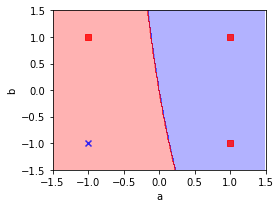

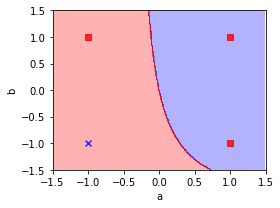

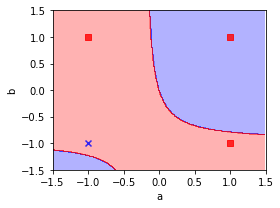

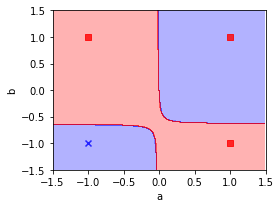

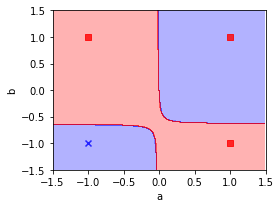

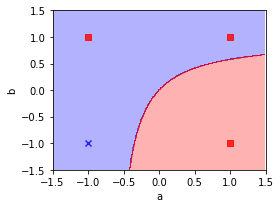

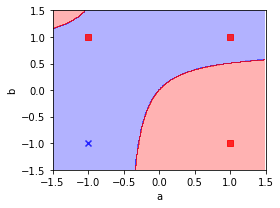

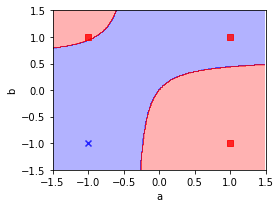

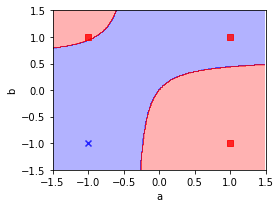

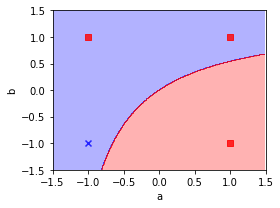

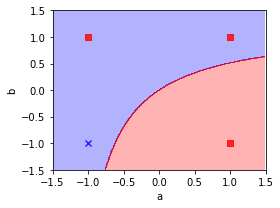

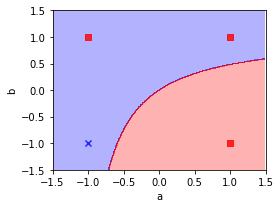

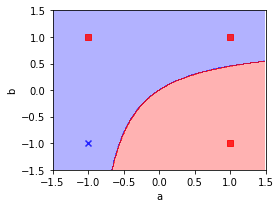

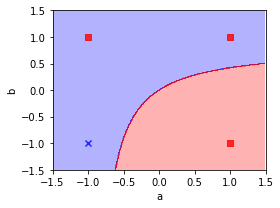

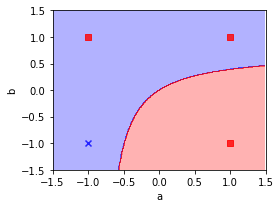

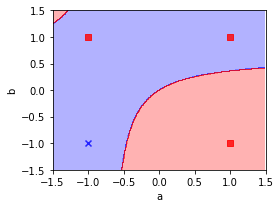

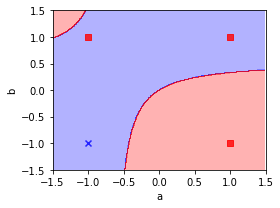

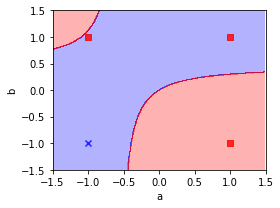

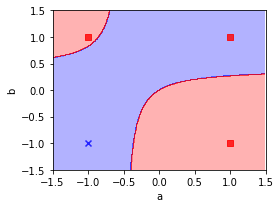

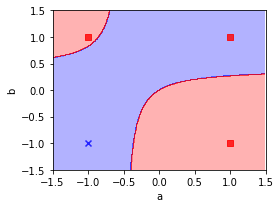

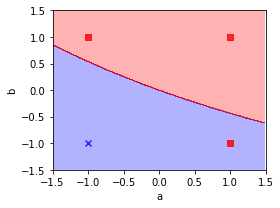

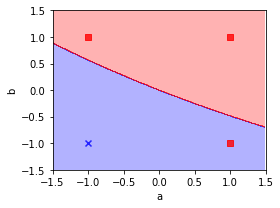

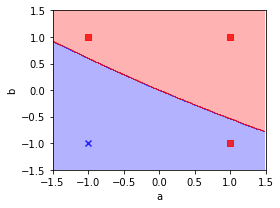

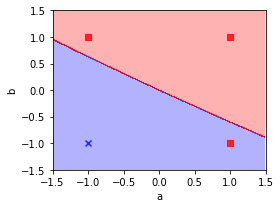

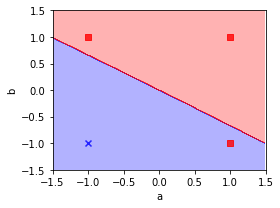

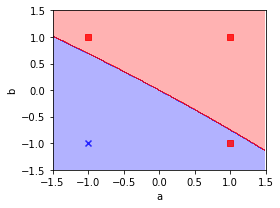

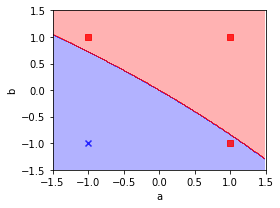

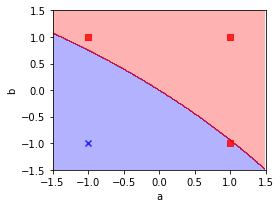

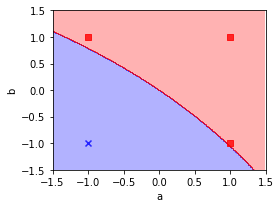

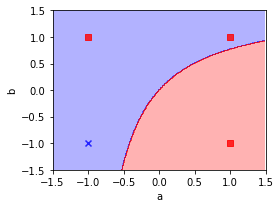

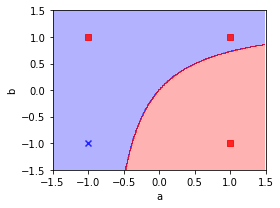

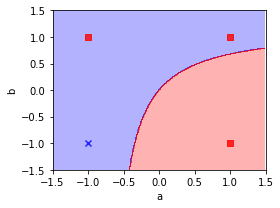

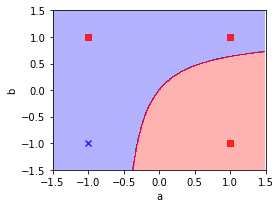

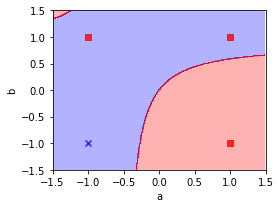

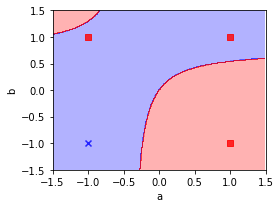

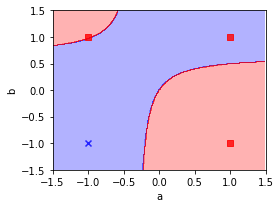

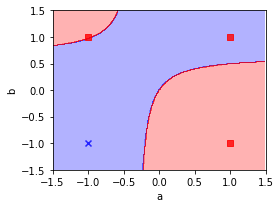

In [14]:
success_dir = "example/success"
failure_dir = "example/failure"
success_count = 1
failure_count = 1

for i in range(100):
    flag, table = m.training_in_order(train_x, train_y, val_y,50)
    imgs = []
    for _,_,w in table:
        raw = plotting(Gate, w)
        imgs.append(raw)

    if flag:
        d = success_dir
        cnt = success_count
        success_count += 1
    else:
        d = failure_dir
        cnt = failure_count
        failure_count += 1
    imgs[0].save("{}/{}.gif".format(d, cnt), save_all=True, append_images=imgs[1:], duration=100, loop=0)